<a href="https://colab.research.google.com/github/nao329/accelerationOpticalFlow/blob/main/accelerationOpticalFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pwd
%cd /content/drive/MyDrive/創成課題/第4回/

/content/drive/MyDrive/創成課題/第4回


### オプティカルフロー

### グレースケール変換のための配列タイプをfloat128にしたらエラーで怒られた?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, convolve

# Load the images
pathL = "./uniformMotionWithNoEdit/0001.png"
pathR = "./uniformMotionWithNoEdit/0002.png"

frameL = plt.imread(pathL)
frameR = plt.imread(pathR)

if frameL is None or frameR is None:
    print("Could not open or find one of the images.")
else:
    # Convert images to grayscale if needed and to float128 for higher precision
    if frameL.ndim == 3:
        frameL = np.dot(frameL[..., :3], [0.2989, 0.5870, 0.1140])
    if frameR.ndim == 3:
        frameR = np.dot(frameR[..., :3], [0.2989, 0.5870, 0.1140])

    frameL = frameL.astype(np.uint16)
    frameR = frameR.astype(np.float128)

    # Define parameters for optical flow calculation
    pyr_scale = 0.5
    levels = 3
    win_size = 15
    iterations = 3
    poly_n = 5
    poly_sigma = 1.2

    # Implement Farneback's optical flow method using NumPy
    def calc_optical_flow_farneback(prev, next, pyr_scale, levels, win_size, iterations, poly_n, poly_sigma):
        # Gaussian smoothing
        prev_blur = gaussian_filter(prev, sigma=poly_sigma)
        next_blur = gaussian_filter(next, sigma=poly_sigma)

        # Compute image gradients using Sobel filters
        sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float128)
        sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float128)

        Ix = convolve(prev_blur, sobel_x)
        Iy = convolve(prev_blur, sobel_y)
        It = next_blur - prev_blur

        # Initialize flow vectors
        u = np.zeros_like(prev, dtype=np.float128)
        v = np.zeros_like(prev, dtype=np.float128)

        # Iteratively update flow estimates
        for _ in range(iterations):
            u_avg = gaussian_filter(u, sigma=win_size / 6.0)
            v_avg = gaussian_filter(v, sigma=win_size / 6.0)

            # Calculate optical flow increment
            num = (Ix * u_avg + Iy * v_avg + It)
            denom = (Ix ** 2 + Iy ** 2 + 1e-10)

            delta_u = -Ix * num / denom
            delta_v = -Iy * num / denom

            u += delta_u
            v += delta_v

        return u, v

    # Calculate optical flow using NumPy implementation
    flowx, flowy = calc_optical_flow_farneback(frameL, frameR, pyr_scale, levels, win_size, iterations, poly_n, poly_sigma)

    # Colorize flow
    def map_val(x, a, b, c, d):
        x = max(min(x, b), a)
        return c + (d - c) * (x - a) / (b - a)

    def colorize_flow(u, v):
        u_min, u_max = np.min(u), np.max(u)
        v_min, v_max = np.min(v), np.max(v)
        u_min, u_max = abs(u_min), abs(u_max)
        v_min, v_max = abs(v_min), abs(v_max)
        d_max = max(u_min, u_max, v_min, v_max)

        h, w = u.shape
        dst = np.zeros((h, w, 3), dtype=np.uint8)

        for y in range(h):
            for x in range(w):
                dst[y, x, 0] = 0
                dst[y, x, 1] = int(map_val(-v[y, x], -d_max, d_max, 0, 255))
                dst[y, x, 2] = int(map_val(u[y, x], -d_max, d_max, 0, 255))

        return dst

    flow_image = colorize_flow(flowx, flowy)

    # Display the optical flow using matplotlib
    plt.imshow(flow_image)
    plt.title('Optical Flow')
    plt.axis('off')
    plt.show()

RuntimeError: array type dtype('float128') not supported

### 既存のオプティカルフローライブラリを使用すると、物体がどのように認識されているか？の確認。

[[[ 0.00e+00  0.00e+00]
  [ 0.00e+00  0.00e+00]
  [ 0.00e+00  0.00e+00]
  ...
  [ 0.00e+00  0.00e+00]
  [ 0.00e+00  0.00e+00]
  [ 0.00e+00  0.00e+00]]

 [[ 0.00e+00  0.00e+00]
  [ 0.00e+00  0.00e+00]
  [ 0.00e+00  0.00e+00]
  ...
  [ 0.00e+00  0.00e+00]
  [ 0.00e+00  0.00e+00]
  [ 0.00e+00  0.00e+00]]

 [[ 0.00e+00  0.00e+00]
  [ 0.00e+00  0.00e+00]
  [ 0.00e+00  0.00e+00]
  ...
  [ 0.00e+00  0.00e+00]
  [ 0.00e+00  0.00e+00]
  [ 0.00e+00  0.00e+00]]

 ...

 [[ 0.00e+00  0.00e+00]
  [ 0.00e+00  0.00e+00]
  [ 0.00e+00  0.00e+00]
  ...
  [-1.68e-44 -9.01e-43]
  [-1.68e-44 -9.01e-43]
  [-1.68e-44 -9.01e-43]]

 [[ 0.00e+00  0.00e+00]
  [ 0.00e+00  0.00e+00]
  [ 0.00e+00  0.00e+00]
  ...
  [-1.68e-44 -9.01e-43]
  [-1.68e-44 -9.01e-43]
  [-1.68e-44 -9.01e-43]]

 [[ 0.00e+00  0.00e+00]
  [ 0.00e+00  0.00e+00]
  [ 0.00e+00  0.00e+00]
  ...
  [-1.68e-44 -9.01e-43]
  [-1.68e-44 -9.01e-43]
  [-1.68e-44 -9.01e-43]]]


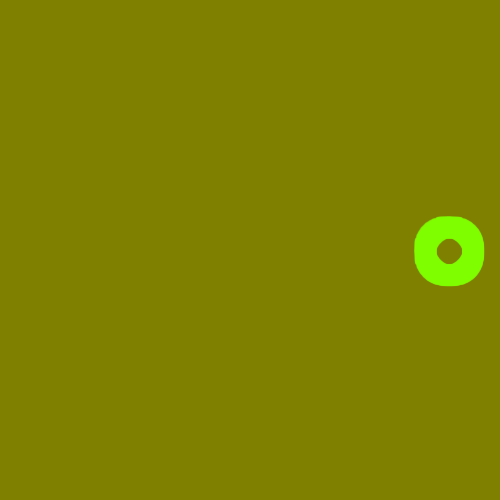

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Load the images
pathL = "./uniformMotionWithNoEdit/0002.png"
pathR = "./uniformMotionWithNoEdit/0001.png"

frameL = cv2.imread(pathL, cv2.IMREAD_GRAYSCALE)
frameR = cv2.imread(pathR, cv2.IMREAD_GRAYSCALE)

if frameL is None or frameR is None:
    print("Could not open or find one of the images.")
else:
    # Calculate optical flow using Farneback's method with standard precision (32-bit float)
    flow = cv2.calcOpticalFlowFarneback(
        frameL.astype(np.float64), frameR.astype(np.float64), None, 0.5, 3, 15, 3, 5, 1.2, 0
    )

    # Split flow into horizontal and vertical components
    flowx, flowy = flow[..., 0], flow[..., 1]

    # Colorize flow
    def map_val(x, a, b, c, d):
        x = max(min(x, b), a)
        return c + (d - c) * (x - a) / (b - a)

    def colorize_flow(u, v):
        u_min, u_max = np.min(u), np.max(u)
        v_min, v_max = np.min(v), np.max(v)
        u_min, u_max = abs(u_min), abs(u_max)
        v_min, v_max = abs(v_min), abs(v_max)
        d_max = max(u_min, u_max, v_min, v_max)

        h, w = u.shape
        dst = np.zeros((h, w, 3), dtype=np.uint8)

        for y in range(h):
            for x in range(w):
                dst[y, x, 0] = 0
                dst[y, x, 1] = int(map_val(-v[y, x], -d_max, d_max, 0, 255))
                dst[y, x, 2] = int(map_val(u[y, x], -d_max, d_max, 0, 255))

        return dst

    flow_image = colorize_flow(flowx, flowy)

    print(flow)
    # Display the optical flow
    cv2_imshow(flow_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

##重心算出

### １フレームの重心のみ算出し表示する。

[[(245, 445), (245, 446), (245, 447), (245, 448), (245, 449), (245, 450), (245, 451), (245, 452), (245, 453), (246, 453), (246, 454), (246, 455), (246, 456), (246, 457), (247, 457), (247, 458), (247, 459), (248, 459), (248, 460), (248, 461), (249, 461), (249, 462), (249, 463), (250, 463), (250, 464), (251, 464), (251, 465), (252, 465), (252, 466), (253, 466), (253, 467), (254, 467), (254, 468), (255, 468), (255, 469), (256, 469), (256, 468), (256, 467), (256, 466), (256, 465), (256, 464), (256, 463), (256, 462), (256, 461), (256, 460), (256, 459), (256, 458), (256, 457), (256, 456), (256, 455), (256, 454), (256, 453), (256, 452), (256, 451), (256, 450), (256, 449), (256, 448), (256, 447), (256, 446), (256, 445), (256, 444), (256, 443), (256, 442), (256, 441), (256, 440), (256, 439), (256, 438), (256, 437), (256, 436), (256, 435), (256, 434), (256, 433), (256, 432), (256, 431), (256, 430), (256, 429), (257, 429), (257, 430), (257, 431), (257, 432), (257, 433), (257, 434), (257, 435), (2

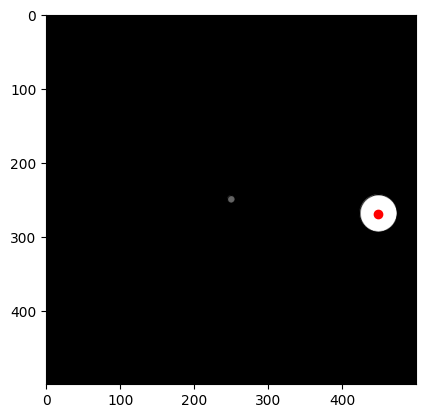

In [7]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal, getcontext

# Load the image using PIL
try:
    img = Image.open("uniformMotionWithNoEdit/0020.png")
except FileNotFoundError:
    print("Could not open or find the image")
    img = None

if img:
    # Convert the image to grayscale
    gray = img.convert("L")

    # Convert grayscale image to numpy array
    gray_np = np.array(gray)
    # Apply binary thresholding
    fg_mask = np.where(gray_np > 127, 255, 0)
    fg_mask = fg_mask.astype(np.uint8)
    # Find contours
    contours = []
    visited = np.zeros_like(fg_mask, dtype=bool)

    def dfs(x, y, contour):
        stack = [(x, y)]
        while stack:
            cx, cy = stack.pop()
            if visited[cx, cy]:
                continue
            visited[cx, cy] = True
            contour.append((cx, cy))
            for nx, ny in [(cx - 1, cy), (cx + 1, cy), (cx, cy - 1), (cx, cy + 1)]:
                if 0 <= nx < fg_mask.shape[0] and 0 <= ny < fg_mask.shape[1]:
                    if fg_mask[nx, ny] == 255 and not visited[nx, ny]:
                        stack.append((nx, ny))

    # Extract contours
    for i in range(fg_mask.shape[0]):
        for j in range(fg_mask.shape[1]):
            if fg_mask[i, j] == 255 and not visited[i, j]:
                contour = []
                dfs(i, j, contour)
                contours.append(contour)

    centroids = []
    print(contours)

    for contour in contours:
        print(contour)
        # Calculate centroid for each contour
        if contour:
            x_coords, y_coords = zip(*contour)
            centroid_x = sum(x_coords) / len(contour)
            centroid_y = sum(y_coords) / len(contour)
            print(type(centroid_x), type(centroid_y))
            centroids.append((centroid_x, centroid_y))

    # Display centroids
    print("Centroids:", centroids)
    # Optional visualization
    plt.imshow(gray_np, cmap='gray')
    for centroid in centroids:
        plt.plot(centroid[1], centroid[0], 'ro')
    plt.show()

# Franeback 従来

### 既存のオプティカルフローの手法

### 既存のオプティカルフローの手法

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

stride_H = 30
stride_W = 30

cap = cv2.VideoCapture("uniformMotionWithNoEdit.mp4")
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*"mp4v")

writer = cv2.VideoWriter("oldOutputUniformMotionWithNoEdit_ver1.mp4", fourcc, fps, (width,height))
bg_subtractor = cv2.createBackgroundSubtractorMOG2()

t1_frame = None
t2_frame = None

def sum_flow_elements(flow, y, h, x, w):
    region = flow[y:y+h, x:x+w]
    total = np.sum(region, axis=(0, 1))
    return total

while True:
  is_read, frame = cap.read()
  if not is_read:
    break
  fg_mask = bg_subtractor.apply(frame)
  _, fg_mask = cv2.threshold(fg_mask, 127, 255, cv2.THRESH_BINARY)

  contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  centroids = []
  for cnt in contours:
    if cv2.contourArea(cnt) > 300:  # ignore small contours
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append((cX, cY))
            cv2.circle(frame, (cX, cY), 5, (255), -1)
  if (t1_frame is not None) and ( t2_frame is not None):
    frame_opt = t2_frame.copy()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    t1_frame_gray = cv2.cvtColor(t1_frame, cv2.COLOR_BGR2GRAY)
    t2_frame_gray = cv2.cvtColor(t2_frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(t1_frame_gray, t2_frame_gray, None, 0.5, 3, 30, 3, 3, 1.1, 0)
    nextFlow = cv2.calcOpticalFlowFarneback(t2_frame_gray, frame_gray, None, 0.5, 3, 30, 3, 3, 1.1, 0)
    Flow = nextFlow - flow

    totalAOF = sum_flow_elements(Flow, 0, height, 0, width)
    for cX, cY in preCentroids:
        point_st = (cX, cY)
        point_ed = (cX + int(totalAOF[0]), cY + int(totalAOF[1]))
        cv2.line(frame_opt, point_st, point_ed, (255, 0, 0), 2)
    preCentroids = centroids.copy()
    writer.write(frame_opt)
    t1_frame = t2_frame.copy()
    t2_frame = frame.copy()
  elif t1_frame is None and t2_frame is not None:
        t1_frame = t2_frame.copy()
        t2_frame = frame.copy()
        writer.write(t2_frame)
        preCentroids = centroids.copy()
  elif t2_frame is None:
    t2_frame = frame.copy()
    writer.write(t2_frame)

writer.release()
cap.release()


### 重心計算方法

(array([[[445, 226]],

       [[444, 227]],

       [[441, 227]],

       [[440, 228]],

       [[439, 228]],

       [[438, 229]],

       [[437, 229]],

       [[436, 230]],

       [[435, 230]],

       [[429, 236]],

       [[429, 237]],

       [[428, 238]],

       [[428, 239]],

       [[427, 240]],

       [[427, 241]],

       [[426, 242]],

       [[426, 245]],

       [[425, 246]],

       [[425, 254]],

       [[426, 255]],

       [[426, 258]],

       [[427, 259]],

       [[427, 260]],

       [[428, 261]],

       [[428, 262]],

       [[429, 263]],

       [[429, 264]],

       [[435, 270]],

       [[436, 270]],

       [[437, 271]],

       [[438, 271]],

       [[439, 272]],

       [[440, 272]],

       [[441, 273]],

       [[445, 273]],

       [[446, 274]],

       [[452, 274]],

       [[453, 273]],

       [[456, 273]],

       [[457, 272]],

       [[459, 272]],

       [[460, 271]],

       [[461, 271]],

       [[464, 268]],

       [[465, 268]],

       [[

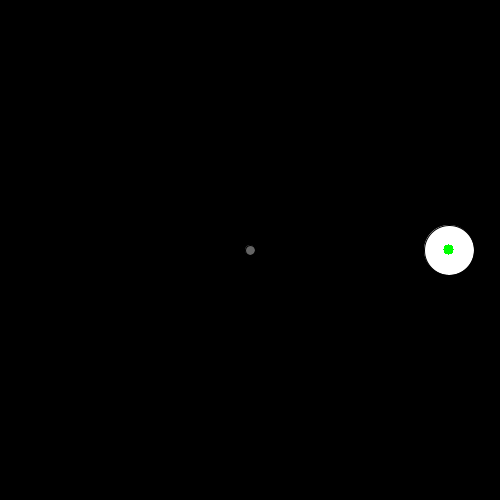

母数1806.0,横重心：810749.5,縦重心：451355.5


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

img = cv2.imread("uniformMotionWithNoEdit/0001.png")
if img is None:
  print("Could not open or find the image")
# cv2_imshow(img)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

_, fg_mask = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
centroids = []
print(contours)
for cnt in contours:
    if cv2.contourArea(cnt) > 500:  # ignore small contours
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append((cX, cY))
            cv2.circle(img, (cX, cY), 5, (0, 255, 0), -1)


cv2_imshow(img)
print(f'母数{M["m00"]},横重心：{M["m10"]},縦重心：{M["m01"]}')

# 提案手法(青木教授)
- 重心のみの速度ベクトルと角度ベクトルを求める.

In [ ]:
import cv2
import numpy as np

stride_H = 30
stride_W = 30

cap = cv2.VideoCapture("uniformMotionWithNoEdit.mp4")
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*"mp4v")

writer = cv2.VideoWriter("outputUniformMotionWithNoEdit2.mp4", fourcc, fps, (width, height))

bg_subtractor = cv2.createBackgroundSubtractorMOG2()

def sum_flow_elements(flow, y, h, x, w):
    region = flow[y:y+h, x:x+w]
    total = np.sum(region, axis=(0, 1))
    return total

t1_frame = None
t2_frame = None

while True:
    is_read, frame = cap.read()
    if not is_read:
        break

    fg_mask = bg_subtractor.apply(frame)
    _, fg_mask = cv2.threshold(fg_mask, 127, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    centroids = []
    for cnt in contours:
        if cv2.contourArea(cnt) > 500:  # ignore small contours
            M = cv2.moments(cnt)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                centroids.append((cX, cY))
                cv2.circle(frame, (cX, cY), 5, (0, 255, 0), -1)
    preCentroids = centroids.copy()
    if t1_frame is not None and t2_frame is not None:
        frame_opt = t2_frame.copy()
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        t1_frame_gray = cv2.cvtColor(t1_frame, cv2.COLOR_BGR2GRAY)
        t2_frame_gray = cv2.cvtColor(t2_frame, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(t1_frame_gray, t2_frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        nextFlow = cv2.calcOpticalFlowFarneback(t2_frame_gray, frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        Flow = nextFlow - flow

        for cX, cY in preCentroids:
            point_st = (cX, cY)
            point_ed = (cX + int(Flow[cY, cX, 0]*100), cY + int(Flow[cY, cX, 1]*100))
            cv2.line(frame_opt, point_st, point_ed, (255, 0, 0), 2)

        writer.write(frame_opt)
        t1_frame = t2_frame.copy()
        t2_frame = frame.copy()
    else:
        t2_frame = frame.copy()
        if t1_frame is None:
            t1_frame = t2_frame.copy()

cap.release()
writer.release()


# 滑らかなオプティカルフロー

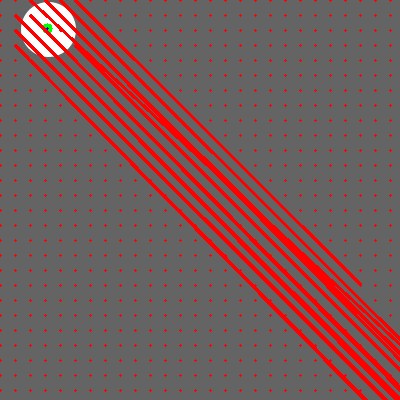

Optical Flow (u, v): [[ 1.6530083e-36  2.0458202e-35  1.2189034e-34 ...  1.8668196e-25
   1.5421755e-25  1.2175314e-25]
 [ 1.8573986e-35  1.9491375e-34  1.3516985e-33 ...  1.3679976e-25
   1.1333721e-25  8.9874658e-26]
 [ 6.1454007e-35  8.5296598e-34  6.3892313e-33 ...  2.1402047e-24
   1.7757892e-24  1.4113739e-24]
 ...
 [ 1.2213359e-36  1.0668957e-35 -4.1638684e-33 ...  2.2670362e-32
   1.8796318e-32  1.4922273e-32]
 [ 1.0126269e-36  8.8457837e-36 -3.4523222e-33 ...  1.8831775e-32
   1.5613690e-32  1.2395607e-32]
 [ 8.0391789e-37  7.0226102e-36 -2.7407762e-33 ...  1.4978572e-32
   1.2418946e-32  9.8593200e-33]] [[ 1.6161035e-36  1.7244181e-35  1.4042318e-34 ...  2.9768761e-25
   2.4689396e-25  1.9610029e-25]
 [ 1.2184676e-35  9.3169016e-35  1.0438040e-33 ...  3.7274706e-25
   3.0871342e-25  2.4467975e-25]
 [ 2.9021214e-35  3.1047841e-34  4.3114583e-33 ...  4.5212015e-25
   3.7485773e-25  2.9759531e-25]
 ...
 [ 3.5598999e-37  1.9521538e-36  6.2667413e-34 ... -1.6894800e-33
  -1.400771

In [ ]:
import cv2
import numpy as np

def compute_optical_flow(image1, image2):
    # 画像の前処理
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Farneback法によるオプティカルフローの計算
    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None,
                                        pyr_scale=0.5, levels=3, winsize=15,
                                        iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
    u = flow[..., 0]
    v = flow[..., 1]

    return u, v

# 物体のセグメンテーションと重心計算（仮想的な例）
def segment_and_compute_centroid(image):
    # 簡単な二値化によるセグメンテーション
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

    # 重心の計算
    moments = cv2.moments(binary)
    if moments['m00'] != 0:
        cx = int(moments['m10'] / moments['m00'])
        cy = int(moments['m01'] / moments['m00'])
    else:
        cx, cy = 0, 0

    return cx, cy

# 実行例
image1 = cv2.imread('opticalflow_val/0025.jpg')
image2 = cv2.imread('opticalflow_val/0026.jpg')

u, v = compute_optical_flow(image1, image2)
cx, cy = segment_and_compute_centroid(image1)
width = image1.shape[1]
height = image1.shape[0]
stride_H = 15
stride_W = 15

# 結果の表示
cv2.circle(image1, (cx, cy), 5, (0, 255, 0), -1)
point_st = (cx, cy)
point_ed = (cx + int(u[cy, cx]), cy + int(v[cy, cx]))
cv2.line(image1, point_st, point_ed, (255, 0, 0), 2)

for h in range(0, height, stride_H):
    for w in range(0, width, stride_W):
        point_st = (w, h)
        point_ed = (w + int(u[h, w]*1000), h + int(v[h, w]*1000))
        cv2.line(image1, point_st, point_ed, (0, 0, 255), 2)

# 結果の画像を表示または保存
cv2_imshow(image1)
cv2.waitKey(0)
cv2.destroyAllWindows()

print("Optical Flow (u, v):", u, v)
print("Centroid (cx, cy):", cx, cy)


# オプティカルフローの確率的削減

KeyPoint (74, 37): u=1.9948970079421997, v=2.0166192054748535, magnitude=2.836611903695458, angle (radians)=0.7908130884170532, angle (degrees)=45.31024932861328
KeyPoint (56, 3): u=2.0151376724243164, v=1.9996672868728638, magnitude=2.838916888007321, angle (radians)=0.7815448641777039, angle (degrees)=44.77922058105469
KeyPoint (74, 21): u=1.993699550628662, v=1.9878299236297607, magnitude=2.815369550068841, angle (radians)=0.7839239239692688, angle (degrees)=44.915531158447266
KeyPoint (56, 55): u=1.9986960887908936, v=2.0071942806243896, magnitude=2.8325986188514736, angle (radians)=0.7875195741653442, angle (degrees)=45.121543884277344
KeyPoint (22, 37): u=1.9909043312072754, v=1.9770585298538208, magnitude=2.8057905279061086, angle (radians)=0.7819087505340576, angle (degrees)=44.80006790161133
KeyPoint (37, 4): u=1.9880799055099487, v=2.011577606201172, magnitude=2.828233755626024, angle (radians)=0.7912729978561401, angle (degrees)=45.33660125732422
KeyPoint (22, 21): u=1.99146

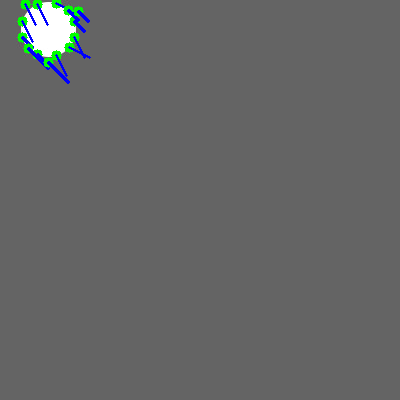

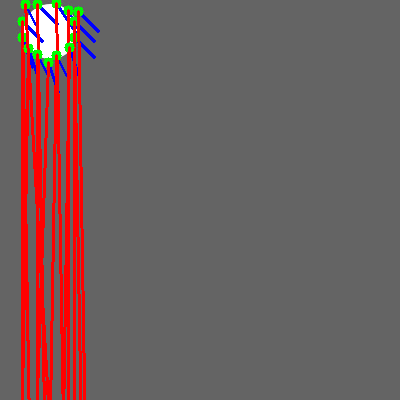

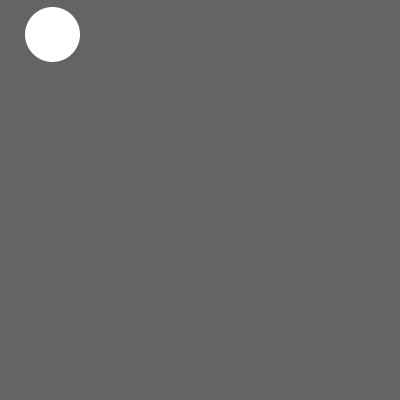

In [ ]:
import cv2
import numpy as np

def compute_optical_flow_at_keypoints(image1, image2, keypoints):
    # 画像の前処理
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # オプティカルフローの計算
    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None,
                                        pyr_scale=0.5, levels=3, winsize=15,
                                        iterations=3, poly_n=5, poly_sigma=1.2, flags=0)

    results = []
    for kp in keypoints:
        cx, cy = kp.ravel()
        cx = int(cx)
        cy = int(cy)
        u = flow[cy, cx, 0]
        v = flow[cy, cx, 1]

        # 大きさの計算
        magnitude = np.sqrt(u**2 + v**2)

        # 角度の計算
        angle = np.arctan2(v, u)  # ラジアン
        angle_degrees = np.degrees(angle)  # 度に変換

        results.append((cx, cy, u, v, magnitude, angle, angle_degrees))

    return results

# 物体のセグメンテーションと重心計算（仮想的な例）
def segment_and_compute_centroid(image):
    # 簡単な二値化によるセグメンテーション
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

    # 重心の計算
    moments = cv2.moments(binary)
    if moments['m00'] != 0:
        cx = int(moments['m10'] / moments['m00'])
        cy = int(moments['m01'] / moments['m00'])
    else:
        cx, cy = 0, 0

    return cx, cy

# 特徴点を検出する関数
def detect_keypoints(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.01, minDistance=10)
    return keypoints

# 加速度ベクトルを計算する関数
def compute_acceleration(results1, results2, dt):
    accelerations = []
    for (cx1, cy1, u1, v1, mag1, ang1, ang_deg1), (cx2, cy2, u2, v2, mag2, ang2, ang_deg2) in zip(results1, results2):
        # 速度ベクトルの変化量
        du = (u2 - u1) / dt
        dv = (v2 - v1) / dt

        # 加速度ベクトルの大きさ
        accel_magnitude = np.sqrt(du**2 + dv**2)

        # 加速度ベクトルの角度
        accel_angle = np.arctan2(dv, du)
        accel_angle_degrees = np.degrees(accel_angle)

        accelerations.append((cx1, cy1, du, dv, accel_magnitude, accel_angle, accel_angle_degrees))
    return accelerations

# 実行例
image1 = cv2.imread('opticalflow_val/0025.jpg')
image2 = cv2.imread('opticalflow_val/0026.jpg')
image3 = cv2.imread('opticalflow_val/0027.jpg')

# 特徴点を検出
keypoints = detect_keypoints(image1)

# 各特徴点におけるオプティカルフローを計算
results1 = compute_optical_flow_at_keypoints(image1, image2, keypoints)
results2 = compute_optical_flow_at_keypoints(image2, image3, keypoints)

# フレーム間の時間差（秒）
dt = 1 / 60.0  # 例えば、30 FPS の動画の場合

# 加速度ベクトルを計算
accelerations = compute_acceleration(results1, results2, dt)

# 結果の表示
for (cx, cy, u, v, magnitude, angle, angle_degrees) in results1:
    cv2.circle(image1, (cx, cy), 5, (0, 255, 0), -1)
    point_st = (cx, cy)
    point_ed = (cx + int(u)*10, cy + int(v)*10)
    cv2.line(image1, point_st, point_ed, (255, 0, 0), 2)
    print(f"KeyPoint ({cx}, {cy}): u={u}, v={v}, magnitude={magnitude}, angle (radians)={angle}, angle (degrees)={angle_degrees}")

for (cx, cy, u, v, magnitude, angle, angle_degrees) in results2:
    cv2.circle(image2, (cx, cy), 5, (0, 255, 0), -1)
    point_st = (cx, cy)
    point_ed = (cx + int(u)*10, cy + int(v)*10)
    cv2.line(image2, point_st, point_ed, (255, 0, 0), 2)
    print(f"KeyPoint ({cx}, {cy}): u={u}, v={v}, magnitude={magnitude}, angle (radians)={angle}, angle (degrees)={angle_degrees}")

for (cx, cy, du, dv, magnitude, angle, angle_degrees) in accelerations:
    cv2.circle(image2, (cx, cy), 5, (0, 255, 0), -1)
    point_st = (cx, cy)
    point_ed = (cx + int(du)*10, cy + int(dv)*10)
    cv2.line(image2, point_st, point_ed, (0, 0, 255), 2)
    print(f"Acceleration ({cx}, {cy}): du={du}, dv={dv}, magnitude={magnitude}, angle (radians)={angle}, angle (degrees)={angle_degrees}")

# 結果の画像を表示または保存
cv2_imshow(image1)
cv2_imshow(image2)
cv2_imshow(image3)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
image1 = cv2.imread('ball1.jpg')

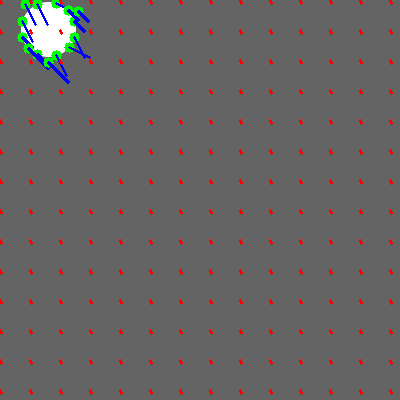

In [ ]:
width = image1.shape[1]
height = image1.shape[0]
stride_H = 30
stride_W = 30

for h in range(0, height, stride_H):
  for w in range(0, width, stride_W):
    point_st = (w, h)
    point_ed = (w + int(u), h + int(v))
    cv2.line(image1, point_st, point_ed, (0, 0, 255), 2)

cv2_imshow(image1)

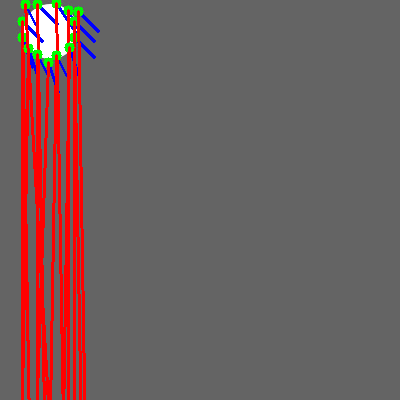

In [ ]:
cv2_imshow(image2)

# 最小浮動小数丸め誤差

In [ ]:
# prompt: coding opticalflow

# 最小浮動小数丸め誤差

def compute_optical_flow(image1, image2):
    # 画像の前処理
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # 勾配の計算
    Ix = cv2.Sobel(gray1, cv2.CV_64F, 1, 0, ksize=5)
    Iy = cv2.Sobel(gray1, cv2.CV_64F, 0, 1, ksize=5)
    It = cv2.subtract(gray2, gray1)

    # Lucas-Kanade法による速度ベクトルの計算
    window_size = 5
    half_window = window_size // 2
    u = np.zeros(gray1.shape)
    v = np.zeros(gray1.shape)

    for i in range(half_window, gray1.shape[0] - half_window):
        for j in range(half_window, gray1.shape[1] - half_window):
            Ix_window = Ix[i - half_window:i + half_window + 1, j - half_window:j + half_window + 1].flatten()
            Iy_window = Iy[i - half_window:i + half_window + 1, j - half_window:j + half_window + 1].flatten()
            It_window = It[i - half_window:i + half_window + 1, j - half_window:j + half_window + 1].flatten()

            A = np.vstack((Ix_window, Iy_window)).T
            b = -It_window

            nu = np.linalg.lstsq(A, b, rcond=None)[0]
            u[i, j] = nu[0]
            v[i, j] = nu[1]

    return u, v

# 物体のセグメンテーションと重心計算（仮想的な例）
def segment_and_compute_centroid(image):
    # 簡単な二値化によるセグメンテーション
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

    # 重心の計算
    moments = cv2.moments(binary)
    if moments['m00'] != 0:
        cx = int(moments['m10'] / moments['m00'])
        cy = int(moments['m01'] / moments['m00'])
    else:
        cx, cy = 0, 0

    return cx, cy

# 実行例
image1 = cv2.imread('demo/0001.jpg')
image2 = cv2.imread('demo/0002.jpg')

u, v = compute_optical_flow(image1, image2)
cx, cy = segment_and_compute_centroid(image1)
width = image1.shape[1]
height = image1.shape[0]
stride_H = 15
stride_W = 15

# 結果の表示
cv2.circle(image1, (cx, cy), 5, (0, 255, 0), -1)
point_st = (cx, cy)
point_ed = (cx + int(u[cy,cx]), cy + int(v[cy,cx]))
cv2.line(image1, point_st, point_ed, (255, 0, 0), 2)

for h in range(0, height, stride_H):
  for w in range(0, width, stride_W):
    point_st = (w, h)
    point_ed = (w + int(u[h,w]), h + int(v[h,w]))
    cv2.line(image1, point_st, point_ed, (0, 0, 255), 2)

cv2_imshow(image1)


print("Optical Flow (u, v):", u, v)
print("Centroid (cx, cy):", cx, cy)


NameError: name 'cv2' is not defined

In [ ]:
image1 = cv2.imread('ball1.jpg')
image2 = cv2.imread('ball2.jpg')

# u, v = compute_optical_flow(image1, image2)
# cx, cy = segment_and_compute_centroid(image1)

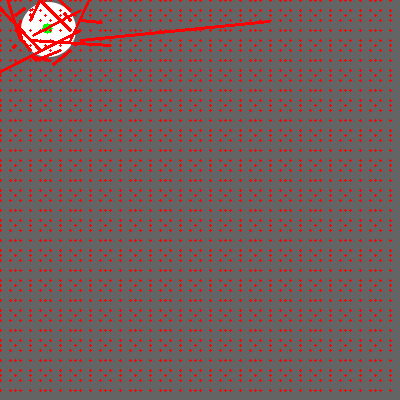

In [ ]:
width = image1.shape[1]
height = image1.shape[0]
stride_H = 10
stride_W = 10

for h in range(0, height, stride_H):
  for w in range(0, width, stride_W):
    point_st = (w, h)
    point_ed = (w + int(u[h,w]*100), h + int(v[h,w]*100))
    cv2.line(image1, point_st, point_ed, (0, 0, 255), 2)

cv2_imshow(image1)

In [ ]:
def total(x):
  total = np.sum(x, axis=(0, 1))
  return total

totalU=total(u)
totalV=total(v)

array([[[  0,   0, 255],
        [  0,   0, 255],
        [100, 100, 100],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       [[  0,   0, 255],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       [[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       ...,

       [[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       [[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       [[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]]], dtype=uint8)
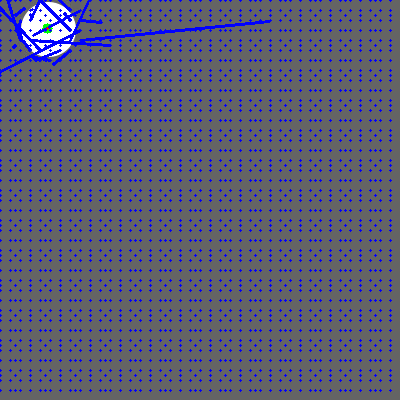

In [ ]:
point_st = (cx, cy)
point_ed = (cx + int(u[cy,cx]), cy + int(v[cy,cx]))
cv2.line(image1, point_st, point_ed, (255, 0, 0), 2)

# point_st = (cx, cy)
# point_ed = (cx + int(totalU*1000), cy + int(totalV*1000))
# cv2.line(image1, point_st, point_ed, (255, 0, 0), 2)

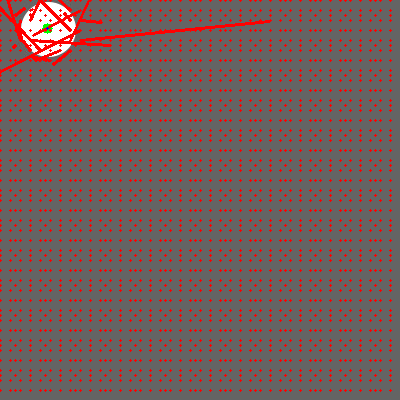

In [ ]:
cv2_imshow(image1)

array([[[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       ...,

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]]], dtype=uint8)
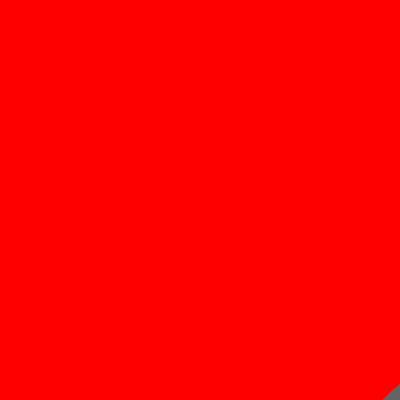

In [ ]:
point_st = (cx, cy)
point_ed = (cx + int(u[cy,cx]), cy + int(v[cy,cx]))
cv2.line(image1, point_st, point_ed, (255, 0, 0), 1000)

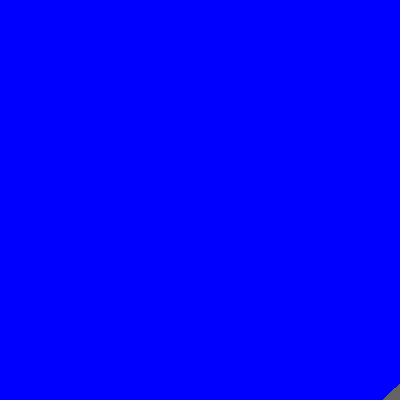

In [ ]:
cv2_imshow(image1)

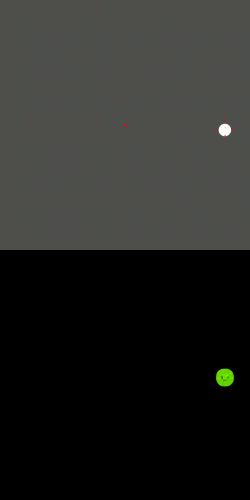

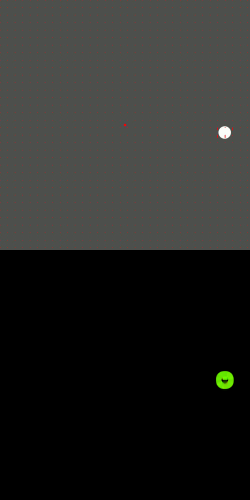

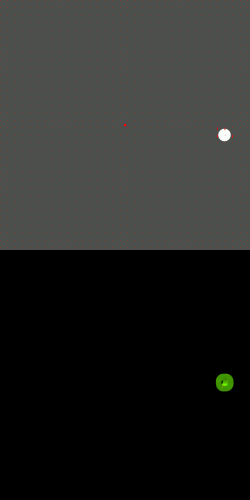

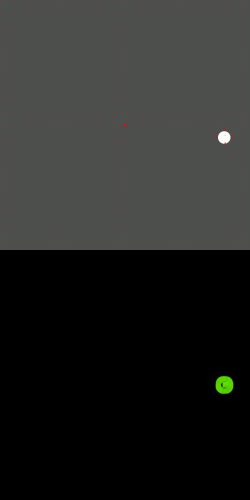

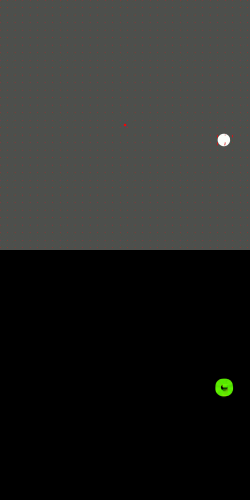

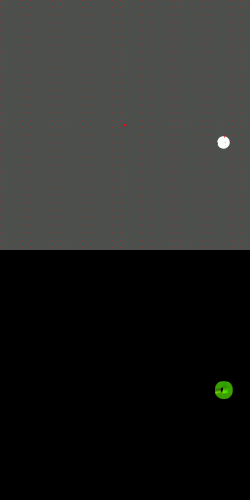

KeyboardInterrupt: 

In [ ]:
cap = cv2.VideoCapture("outputUniformMotionDemo.mp4")

ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[..., 1] = 255

codec = cv2.VideoWriter_fourcc(*'mp4v')
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
writer = cv2.VideoWriter('Opticaldemo.avi', codec, fps, (width, height))

while(1):
    ret, frame2 = cap.read()
    if not ret:
        print('No frames grabbed!')
        break
    next = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    frame2 = np.vstack((frame2, bgr))
    writer.write(frame2)
    frame2 = cv2.resize(frame2, None, fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA)
    cv2_imshow(frame2)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    prvs = next
cap.release()
writer.release()
# cv2.destroyAllWindows()

In [ ]:
cap.release()
writer.release()

# 物体の重心を抽出.

# keypointsを加速度ベクトルのみにする.

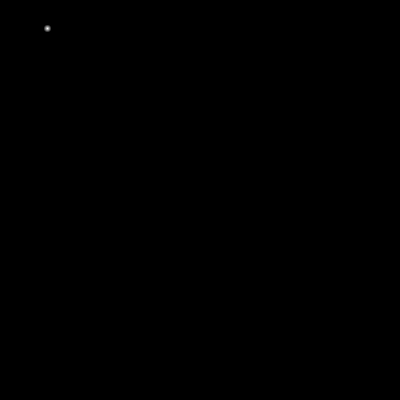

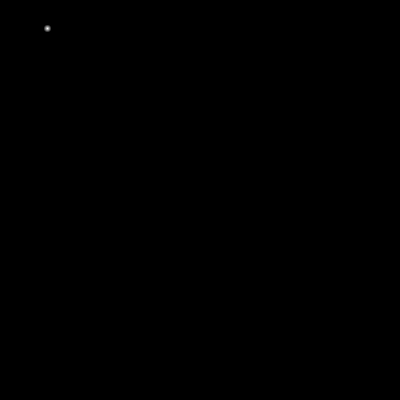

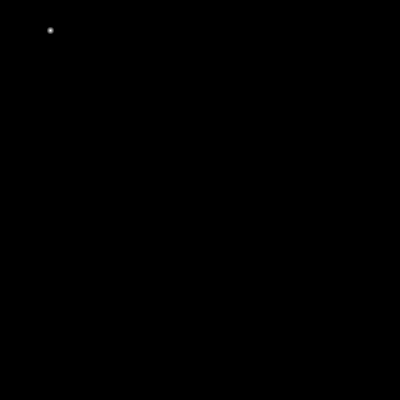

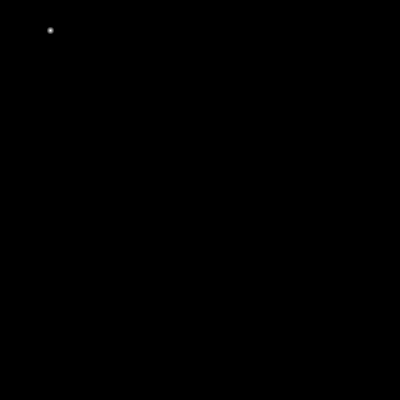

Frame 1 to Frame 2: KeyPoint (47, 28): u=0.0, v=0.0, magnitude=0.0, angle (radians)=0.0, angle (degrees)=0.0
Frame 2 to Frame 3: KeyPoint (50, 30): u=0.0, v=0.0, magnitude=0.0, angle (radians)=0.0, angle (degrees)=0.0
Acceleration: KeyPoint (50, 30): du=0.0, dv=0.0, magnitude=0.0, angle (radians)=0.0, angle (degrees)=0.0


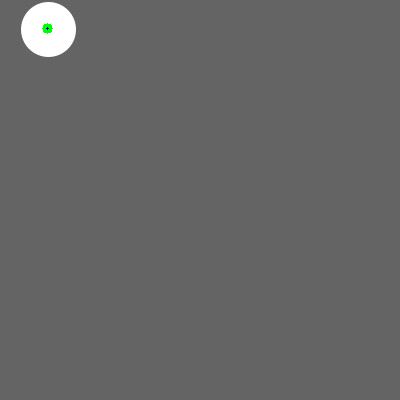

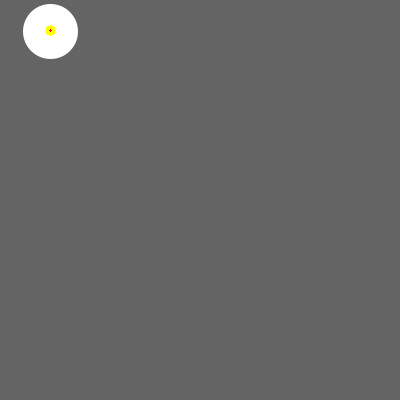

In [ ]:
import cv2
import numpy as np

def create_gradient_mask(shape, center, radius):
    y, x = np.ogrid[:shape[0], :shape[1]]
    mask = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    mask = np.clip(mask, 0, radius)
    mask = (radius - mask) / radius
    mask = mask * 255  # マスクを0-255の範囲にスケーリング
    return mask.astype(np.uint8)

# def apply_gradient_mask(image, mask):
#     return cv2.multiply(image, mask.astype(np.uint8) / 255.0)
def apply_gradient_mask(image, mask):
    return (image * (mask.astype(np.uint8) / 255.0)).astype(np.uint8)


def compute_optical_flow_at_centroid(image1, image2, cx, cy):
    # 画像の前処理
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # グラデーションマスクの作成
    radius = 4  # マスクの半径
    mask = create_gradient_mask(gray1.shape, (cx, cy), radius)

    # グラデーションマスクを適用
    masked_gray1 = apply_gradient_mask(gray1, mask)
    masked_gray2 = apply_gradient_mask(gray2, mask)

    cv2_imshow(masked_gray1)
    cv2_imshow(masked_gray2)

    # オプティカルフローの計算
    flow = cv2.calcOpticalFlowFarneback(masked_gray1, masked_gray2, None,
                                        pyr_scale=0.5, levels=3, winsize=15,
                                        iterations=3, poly_n=5, poly_sigma=1.2, flags=0)

    u = flow[cy, cx, 0]
    v = flow[cy, cx, 1]

    # 大きさの計算
    magnitude = np.sqrt(u**2 + v**2)

    # 角度の計算
    angle = np.arctan2(v, u)  # ラジアン
    angle_degrees = np.degrees(angle)  # 度に変換

    return (cx, cy, u, v, magnitude, angle, angle_degrees)

# 物体のセグメンテーションと重心計算（仮想的な例）
def segment_and_compute_centroid(image):
    # 簡単な二値化によるセグメンテーション
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

    # 重心の計算
    moments = cv2.moments(binary)
    if moments['m00'] != 0:
        cx = int(moments['m10'] / moments['m00'])
        cy = int(moments['m01'] / moments['m00'])
    else:
        cx, cy = 0, 0

    return cx, cy

# 加速度ベクトルを計算する関数
def compute_acceleration(result1, result2, dt):
    (cx1, cy1, u1, v1, mag1, ang1, ang_deg1) = result1
    (cx2, cy2, u2, v2, mag2, ang2, ang_deg2) = result2

    # 速度ベクトルの変化量
    du = (u2 - u1) / dt
    dv = (v2 - v1) / dt

    # 加速度ベクトルの大きさ
    accel_magnitude = np.sqrt(du**2 + dv**2)

    # 加速度ベクトルの角度
    accel_angle = np.arctan2(dv, du)
    accel_angle_degrees = np.degrees(accel_angle)

    return (cx2, cy2, du, dv, accel_magnitude, accel_angle, accel_angle_degrees)

# 実行例
image1 = cv2.imread('opticalflow_val/0025.jpg')
image2 = cv2.imread('opticalflow_val/0026.jpg')
image3 = cv2.imread('opticalflow_val/0027.jpg')

# 各画像の重心を計算
cx1, cy1 = segment_and_compute_centroid(image1)
cx2, cy2 = segment_and_compute_centroid(image2)
cx3, cy3 = segment_and_compute_centroid(image3)

# 重心におけるオプティカルフローを計算
result1 = compute_optical_flow_at_centroid(image1, image2, cx1, cy1)
result2 = compute_optical_flow_at_centroid(image2, image3, cx2, cy2)

# フレーム間の時間差（秒）
dt = 1 / 60.0  # 例えば、30 FPS の動画の場合

# 加速度ベクトルを計算
acceleration = compute_acceleration(result1, result2, dt)

# 結果の表示
(cx1, cy1, u1, v1, mag1, ang1, ang_deg1) = result1
(cx2, cy2, u2, v2, mag2, ang2, ang_deg2) = result2
(cx3, cy3, du, dv, accel_magnitude, accel_angle, accel_angle_degrees) = acceleration

# image1 にオプティカルフローを描画
cv2.circle(image1, (cx1, cy1), 5, (0, 255, 0), -1)
point_st = (cx1, cy1)
point_ed = (cx1 + int(u1*10**10), cy1 + int(v1*10**10))
cv2.line(image1, point_st, point_ed, (255, 0, 0), 2)
print(f"Frame 1 to Frame 2: KeyPoint ({cx1}, {cy1}): u={u1}, v={v1}, magnitude={mag1}, angle (radians)={ang1}, angle (degrees)={ang_deg1}")

# image2 にオプティカルフローを描画
cv2.circle(image2, (cx2, cy2), 5, (0, 255, 0), -1)
point_st = (cx2, cy2)
point_ed = (cx2 + int(u2*10**12), cy2 + int(v2*10**12))
cv2.line(image2, point_st, point_ed, (255, 0, 0), 2)
print(f"Frame 2 to Frame 3: KeyPoint ({cx2}, {cy2}): u={u2}, v={v2}, magnitude={mag2}, angle (radians)={ang2}, angle (degrees)={ang_deg2}")

# image2 に加速度ベクトルを描画
cv2.circle(image2, (cx2, cy2), 5, (0, 255, 255), -1)  # Yellow circle for acceleration
point_st = (cx2, cy2)
point_ed = (cx2 + int(du*10**10), cy2 + int(dv*10**10))
cv2.line(image2, point_st, point_ed, (0, 0, 255), 2)
print(f"Acceleration: KeyPoint ({cx3}, {cy3}): du={du}, dv={dv}, magnitude={accel_magnitude}, angle (radians)={accel_angle}, angle (degrees)={accel_angle_degrees}")

# 結果の画像を表示または保存
cv2_imshow(image1)
cv2_imshow(image2)
cv2.waitKey(0)
cv2.destroyAllWindows()


## 全フレームに適用

In [ ]:
import cv2
import numpy as np
import glob
import os

def create_gradient_mask(shape, center, radius):
    y, x = np.ogrid[:shape[0], :shape[1]]
    mask = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    mask = np.clip(mask, 0, radius)
    mask = (radius - mask) / radius
    mask = mask * 255  # マスクを0-255の範囲にスケーリング
    return mask.astype(np.uint8)

def apply_gradient_mask(image, mask):
    return (image * (mask.astype(np.float32) / 255.0)).astype(np.uint8)

def compute_optical_flow_at_centroid(image1, image2, cx, cy, prev_cx, prev_cy):
    # 画像の前処理
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # グラデーションマスクの作成
    radius = 50  # マスクの半径
    mask = create_gradient_mask(gray1.shape, (prev_cx, prev_cy), radius)

    # グラデーションマスクを適用
    masked_gray1 = apply_gradient_mask(gray1, mask)
    masked_gray2 = apply_gradient_mask(gray2, mask)

    # オプティカルフローの計算
    flow = cv2.calcOpticalFlowFarneback(masked_gray1, masked_gray2, None,
                                        pyr_scale=0.5, levels=3, winsize=15,
                                        iterations=3, poly_n=5, poly_sigma=1.2, flags=0)

    u = flow[cy, cx, 0]
    v = flow[cy, cx, 1]

    # 大きさの計算
    magnitude = np.sqrt(u**2 + v**2)

    # 角度の計算
    angle = np.arctan2(v, u)  # ラジアン
    angle_degrees = np.degrees(angle)  # 度に変換

    return (cx, cy, u, v, magnitude, angle, angle_degrees)

def segment_and_compute_centroid(image):
    # 簡単な二値化によるセグメンテーション
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

    # 重心の計算
    moments = cv2.moments(binary)
    if moments['m00'] != 0:
        cx = int(moments['m10'] / moments['m00'])
        cy = int(moments['m01'] / moments['m00'])
    else:
        cx, cy = 0, 0

    return cx, cy

def compute_acceleration(result1, result2, dt):
    (cx1, cy1, u1, v1, mag1, ang1, ang_deg1) = result1
    (cx2, cy2, u2, v2, mag2, ang2, ang_deg2) = result2

    # 速度ベクトルの変化量
    du = (u2 - u1) / dt
    dv = (v2 - v1) / dt

    # 加速度ベクトルの大きさ
    accel_magnitude = np.sqrt(du**2 + dv**2)

    # 加速度ベクトルの角度
    accel_angle = np.arctan2(dv, du)
    accel_angle_degrees = np.degrees(accel_angle)

    return (cx2, cy2, du, dv, accel_magnitude, accel_angle, accel_angle_degrees)

# 画像が格納されているフォルダのパス
image_folder = 'newmethod'

# 画像ファイルをすべて取得
image_files = sorted(glob.glob(os.path.join(image_folder, '*.png')))

# フレーム間の時間差（秒）
dt = 1 / 30.0  # 例えば、30 FPS の動画の場合

# 初期フレームの重心を計算
initial_frame = cv2.imread(image_files[0])
prev_cx, prev_cy = segment_and_compute_centroid(initial_frame)

# すべてのフレームを処理
for i in range(len(image_files) - 2):
    image1 = cv2.imread(image_files[i])
    image2 = cv2.imread(image_files[i + 1])
    image3 = cv2.imread(image_files[i + 2])

    # 各画像の重心を計算
    cx1, cy1 = segment_and_compute_centroid(image1)
    cx2, cy2 = segment_and_compute_centroid(image2)
    cx3, cy3 = segment_and_compute_centroid(image3)

    # 重心におけるオプティカルフローを計算
    result1 = compute_optical_flow_at_centroid(image1, image2, cx1, cy1, prev_cx, prev_cy)
    result2 = compute_optical_flow_at_centroid(image2, image3, cx2, cy2, cx1, cy1)

    # 加速度ベクトルを計算
    acceleration = compute_acceleration(result1, result2, dt)

    # 結果の表示
    (cx1, cy1, u1, v1, mag1, ang1, ang_deg1) = result1
    (cx2, cy2, u2, v2, mag2, ang2, ang_deg2) = result2
    (cx3, cy3, du, dv, accel_magnitude, accel_angle, accel_angle_degrees) = acceleration

    # image1 にオプティカルフローを描画
    cv2.circle(image1, (cx1, cy1), 5, (0, 255, 0), -1)
    point_st = (cx1, cy1)
    point_ed = (cx1 + int(u1 * 10 ** 7), cy1 + int(v1 * 10 ** 7))  # スケールを適切に調整
    cv2.line(image1, point_st, point_ed, (255, 0, 0), 2)
    print(f"Frame {i+1} to Frame {i+2}: KeyPoint ({cx1}, {cy1}): u={u1}, v={v1}, magnitude={mag1}, angle (radians)={ang1}, angle (degrees)={ang_deg1}")

    # image2 にオプティカルフローを描画
    cv2.circle(image2, (cx2, cy2), 5, (0, 255, 0), -1)
    point_st = (cx2, cy2)
    point_ed = (cx2 + int(u2 * 10 ** 7), cy2 + int(v2 * 10 ** 7))  # スケールを適切に調整
    cv2.line(image2, point_st, point_ed, (255, 0, 0), 2)
    print(f"Frame {i+2} to Frame {i+3}: KeyPoint ({cx2}, {cy2}): u={u2}, v={v2}, magnitude={mag2}, angle (radians)={ang2}, angle (degrees)={ang_deg2}")

    # image2 に加速度ベクトルを描画
    cv2.circle(image2, (cx2, cy2), 5, (0, 255, 255), -1)  # Yellow circle for acceleration
    point_st = (cx2, cy2)
    point_ed = (cx2 + int(du * 10 ** 6), cy2 + int(dv * 10 ** 6))  # スケールを適切に調整
    cv2.line(image2, point_st, point_ed, (0, 0, 255), 2)
    print(f"Acceleration: KeyPoint ({cx3}, {cy3}): du={du}, dv={dv}, magnitude={accel_magnitude}, angle (radians)={accel_angle}, angle (degrees)={accel_angle_degrees}")

    # 結果の画像を表示または保存
    # print(f'Result Frame {i+1}')
    # cv2_imshow(image1)
    print(f'Result Frame {i+2}')
    cv2_imshow(image2)
    cv2.waitKey(0)

    # 次のフレームのために重心を更新
    prev_cx, prev_cy = cx1, cy1

cv2.destroyAllWindows()


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Feature Tracking


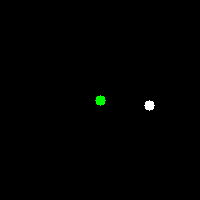

Feature Tracking


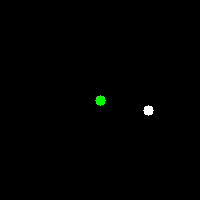

Feature Tracking


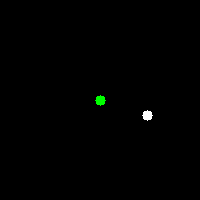

Feature Tracking


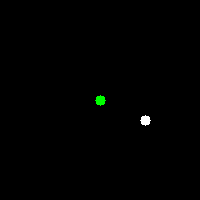

Feature Tracking


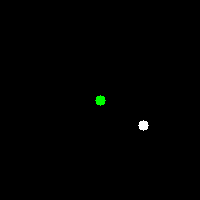

Feature Tracking


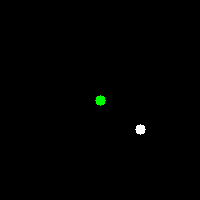

Feature Tracking


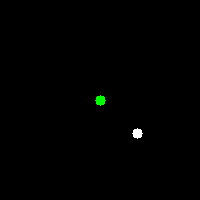

Feature Tracking


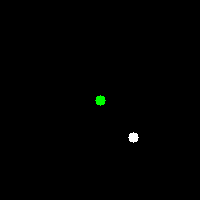

Feature Tracking


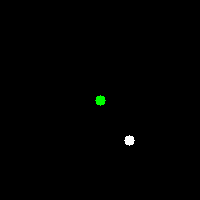

Feature Tracking


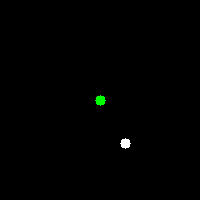

Feature Tracking


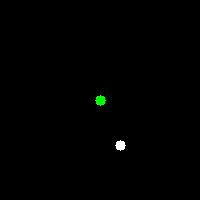

Feature Tracking


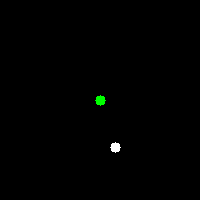

Feature Tracking


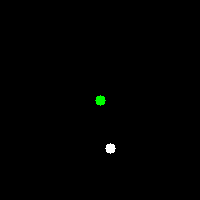

Feature Tracking


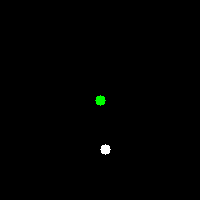

Feature Tracking


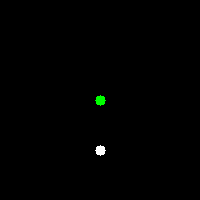

Feature Tracking


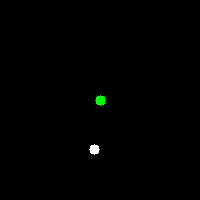

Feature Tracking


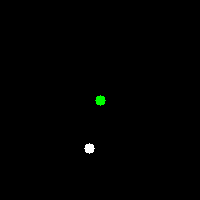

Feature Tracking


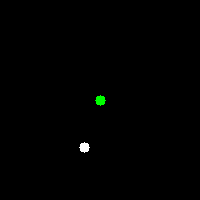

Feature Tracking


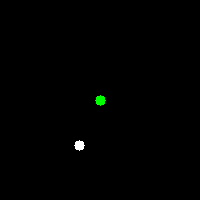

Feature Tracking


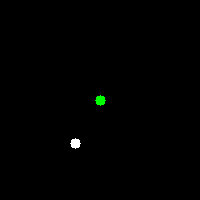

Feature Tracking


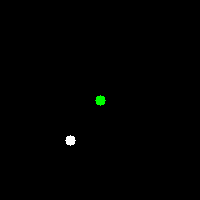

Feature Tracking


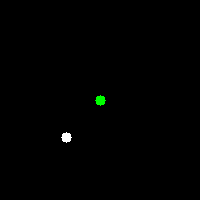

Feature Tracking


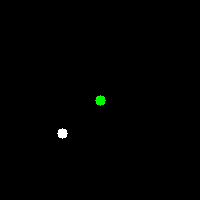

Feature Tracking


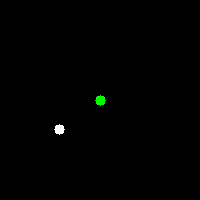

Feature Tracking


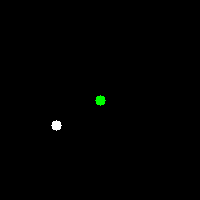

Feature Tracking


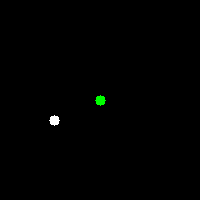

Feature Tracking


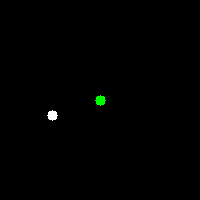

Feature Tracking


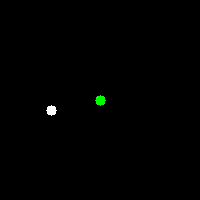

Feature Tracking


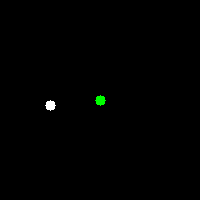

Feature Tracking


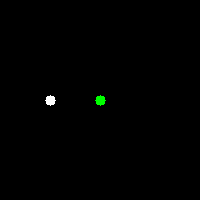

Feature Tracking


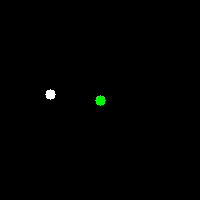

Feature Tracking


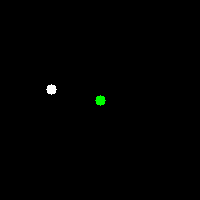

Feature Tracking


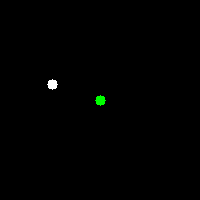

Feature Tracking


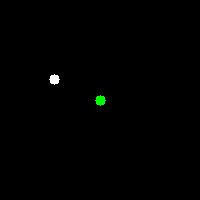

Feature Tracking


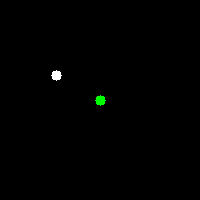

Feature Tracking


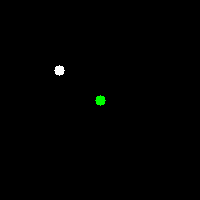

Feature Tracking


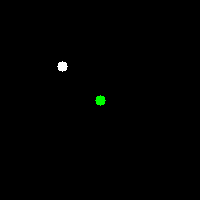

Feature Tracking


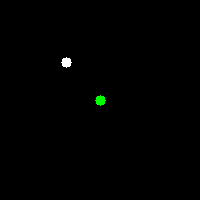

Feature Tracking


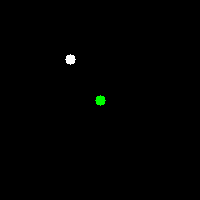

Feature Tracking


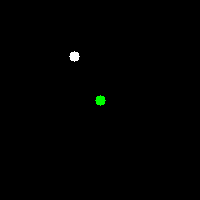

Feature Tracking


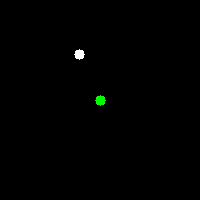

Feature Tracking


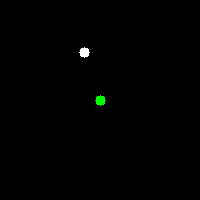

Feature Tracking


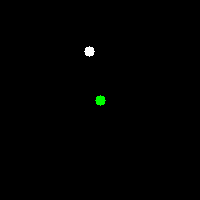

Feature Tracking


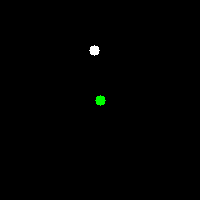

Feature Tracking


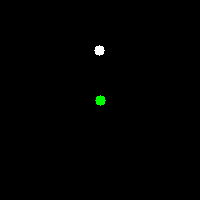

Feature Tracking


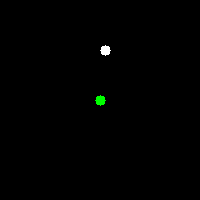

Feature Tracking


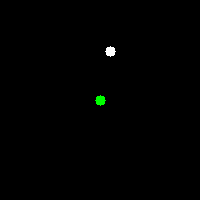

Feature Tracking


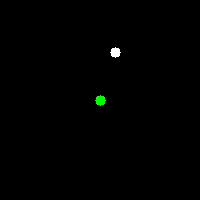

Feature Tracking


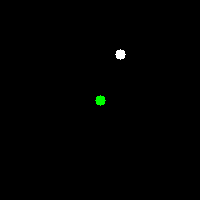

Feature Tracking


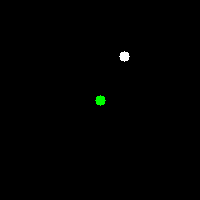

Feature Tracking


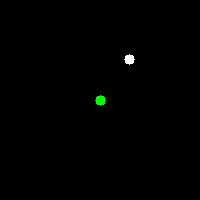

Feature Tracking


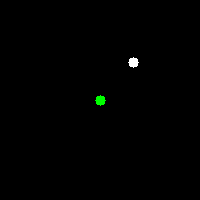

Feature Tracking


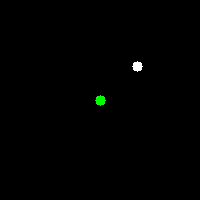

Feature Tracking


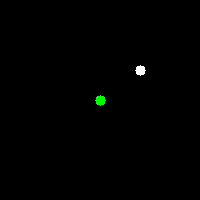

Feature Tracking


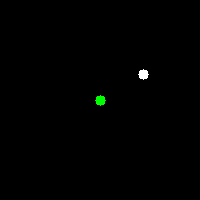

Feature Tracking


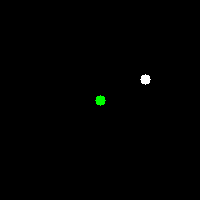

Feature Tracking


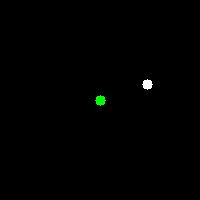

Feature Tracking


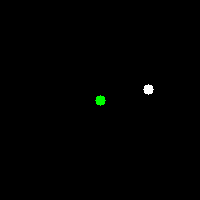

Feature Tracking


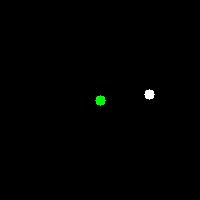

In [ ]:
import cv2
import numpy as np

# シミュレーションパラメータ
num_frames = 60
frame_size = (200, 200)
radius = 50
center = (100, 100)
omega = 2 * np.pi / num_frames  # 一周するための角速度

# フレームの生成
frames = []
for t in range(num_frames):
    frame = np.zeros(frame_size, dtype=np.uint8)
    x = int(center[0] + radius * np.cos(omega * t))
    y = int(center[1] + radius * np.sin(omega * t))
    cv2.circle(frame, (x, y), 5, 255, -1)
    frames.append(frame)

# 重心の検出と追跡
lk_params = dict(winSize=(5, 5), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
p0 = np.array([[center]], dtype=np.float32)  # 初期位置を重心に設定

# 特徴点の追跡
for i in range(1, num_frames):
    p1, st, err = cv2.calcOpticalFlowPyrLK(frames[i-1], frames[i], p0, None, **lk_params)
    if p1 is not None:
        p0 = p1
    else:
        p0 = np.array([[center]], dtype=np.float32)  # トラッキングが失敗した場合、中心に戻す

    # ベクトルの表示
    vis = cv2.cvtColor(frames[i], cv2.COLOR_GRAY2BGR)
    for pt in p1:
        x, y = pt.ravel()
        cv2.circle(vis, (int(x), int(y)), 5, (0, 255, 0), -1)

    print('Feature Tracking')
    cv2_imshow(vis)
    cv2.waitKey(50)

cv2.destroyAllWindows()


# 円運動を行う物体の加速度オプティカルフロー

Circular Motion


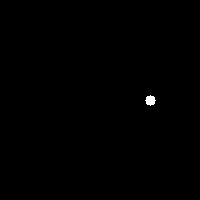

Circular Motion


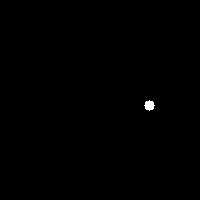

Circular Motion


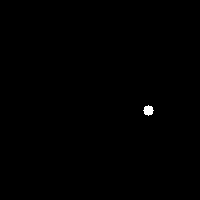

Circular Motion


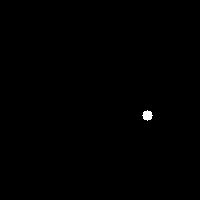

Circular Motion


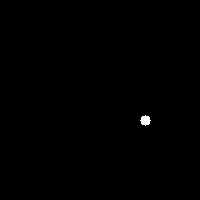

Circular Motion


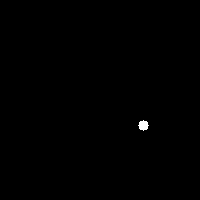

Circular Motion


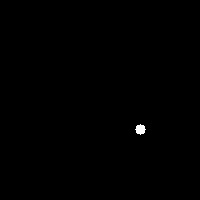

Circular Motion


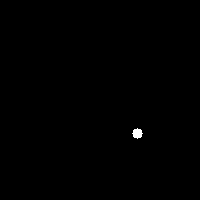

Circular Motion


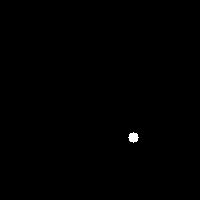

Circular Motion


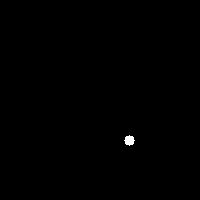

Circular Motion


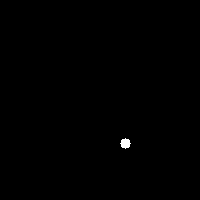

Circular Motion


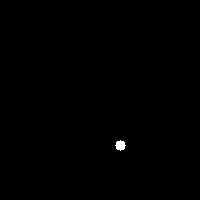

Circular Motion


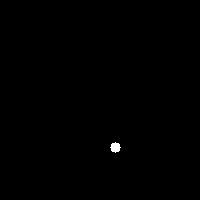

Circular Motion


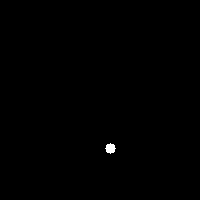

Circular Motion


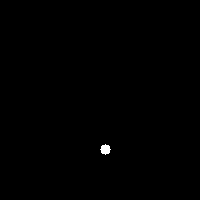

Circular Motion


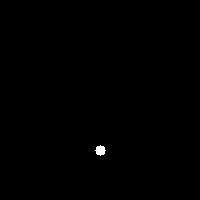

Circular Motion


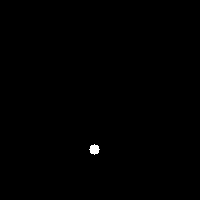

Circular Motion


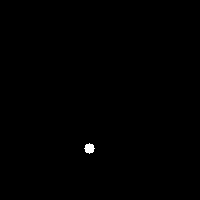

Circular Motion


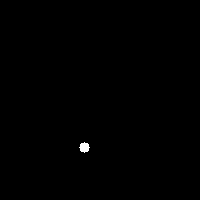

Circular Motion


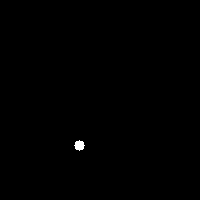

Circular Motion


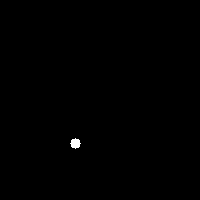

Circular Motion


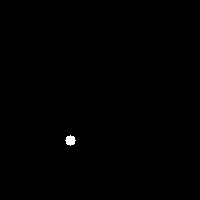

Circular Motion


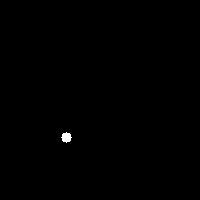

Circular Motion


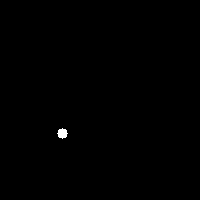

Circular Motion


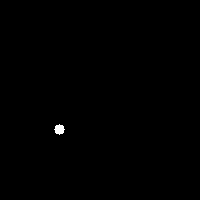

Circular Motion


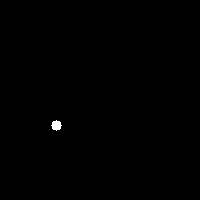

Circular Motion


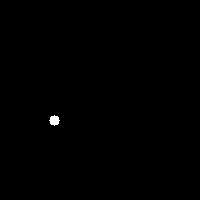

Circular Motion


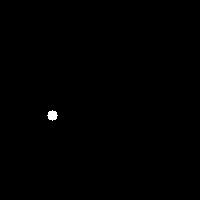

Circular Motion


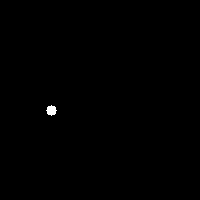

Circular Motion


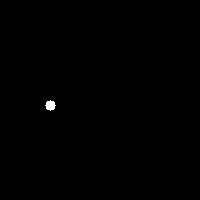

Circular Motion


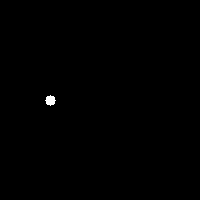

Circular Motion


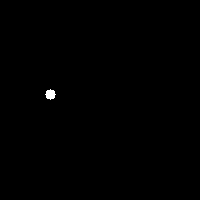

Circular Motion


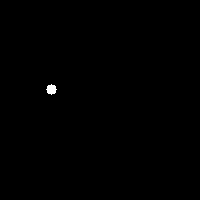

Circular Motion


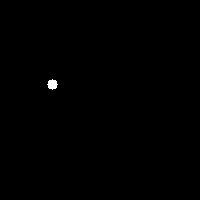

Circular Motion


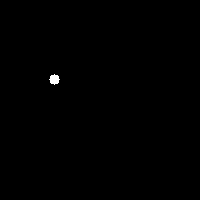

Circular Motion


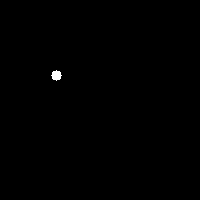

Circular Motion


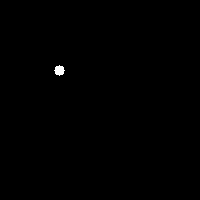

Circular Motion


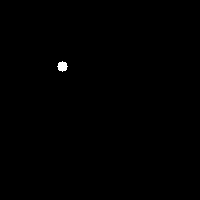

Circular Motion


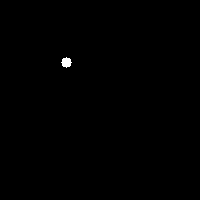

Circular Motion


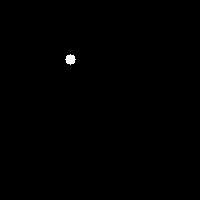

Circular Motion


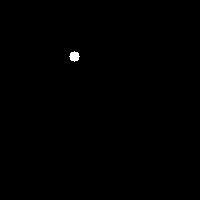

Circular Motion


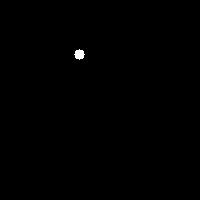

Circular Motion


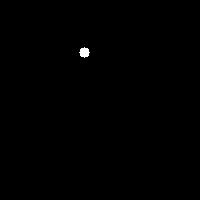

Circular Motion


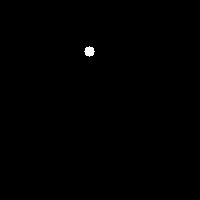

Circular Motion


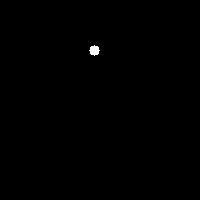

Circular Motion


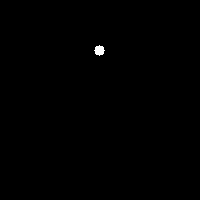

Circular Motion


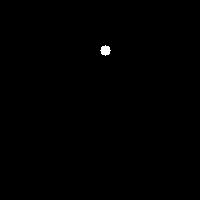

Circular Motion


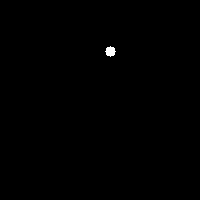

Circular Motion


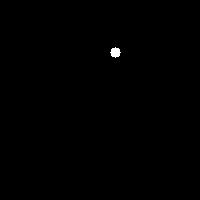

Circular Motion


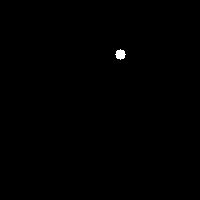

Circular Motion


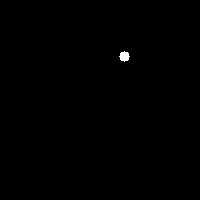

Circular Motion


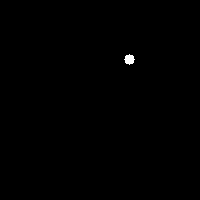

Circular Motion


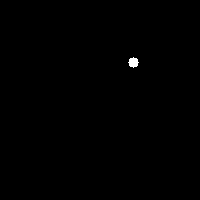

Circular Motion


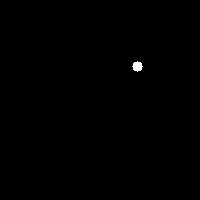

Circular Motion


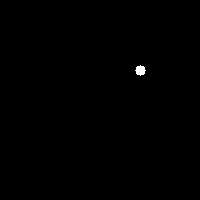

Circular Motion


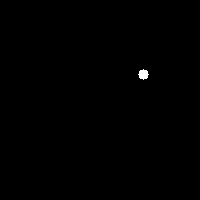

Circular Motion


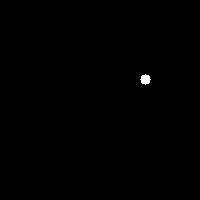

Circular Motion


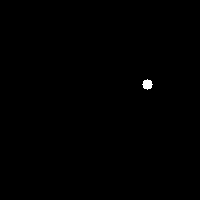

Circular Motion


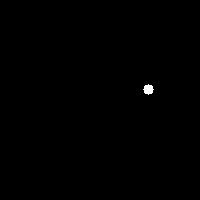

Circular Motion


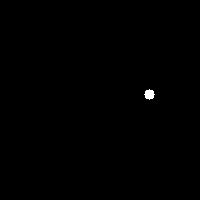

In [ ]:
import cv2
import numpy as np

# シミュレーションパラメータ
num_frames = 60
frame_size = (200, 200)
radius = 50
center = (100, 100)
omega = 2 * np.pi / num_frames  # 一周するための角速度

# フレームの生成
frames = []
for t in range(num_frames):
    frame = np.zeros(frame_size, dtype=np.uint8)
    x = int(center[0] + radius * np.cos(omega * t))
    y = int(center[1] + radius * np.sin(omega * t))
    cv2.circle(frame, (x, y), 5, 255, -1)
    frames.append(frame)

# フレームの表示（確認用）
for frame in frames:
    print('Circular Motion')
    cv2_imshow(frame)
    cv2.waitKey(100)

cv2.destroyAllWindows()


Optical Flow


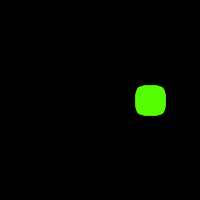

Optical Flow


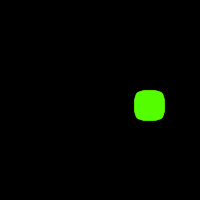

Optical Flow


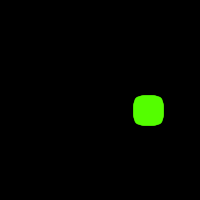

Optical Flow


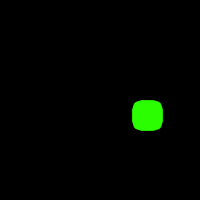

Optical Flow


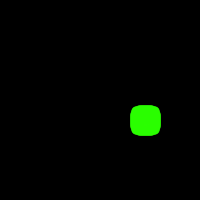

Optical Flow


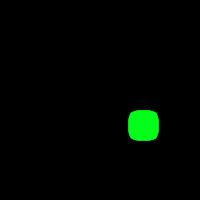

Optical Flow


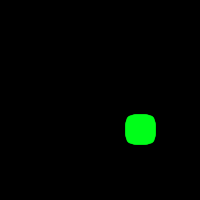

Optical Flow


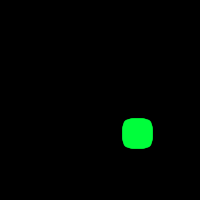

Optical Flow


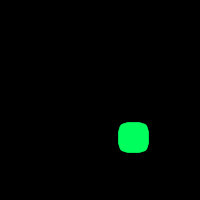

Optical Flow


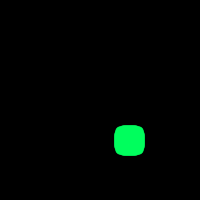

Optical Flow


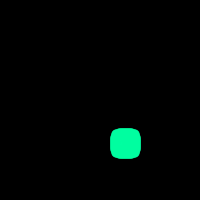

Optical Flow


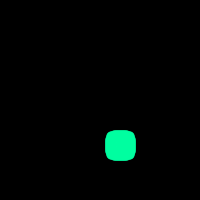

Optical Flow


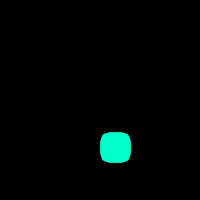

Optical Flow


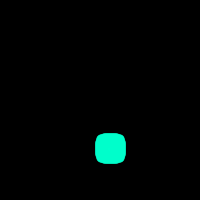

Optical Flow


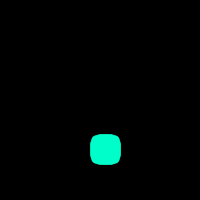

Optical Flow


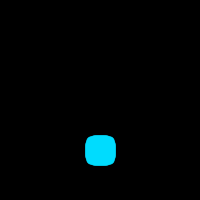

Optical Flow


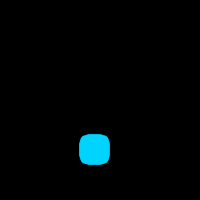

Optical Flow


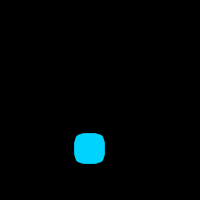

Optical Flow


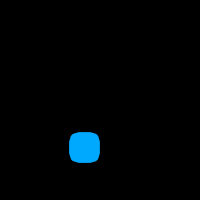

Optical Flow


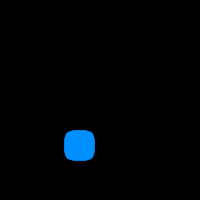

Optical Flow


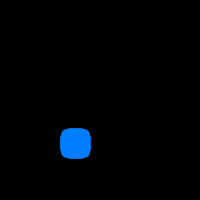

Optical Flow


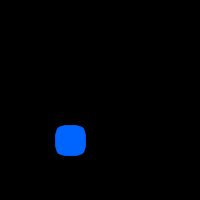

Optical Flow


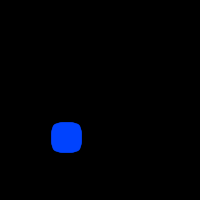

Optical Flow


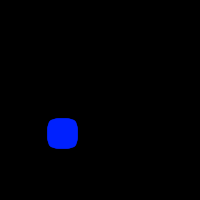

Optical Flow


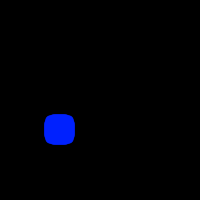

Optical Flow


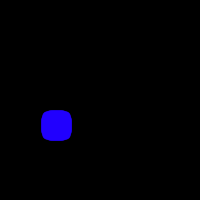

Optical Flow


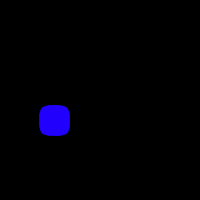

Optical Flow


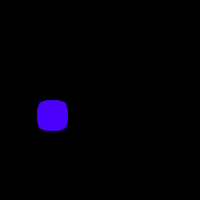

Optical Flow


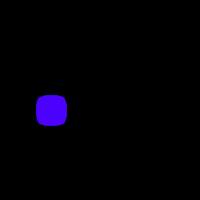

Optical Flow


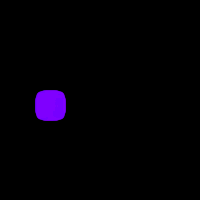

Optical Flow


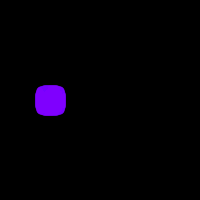

Optical Flow


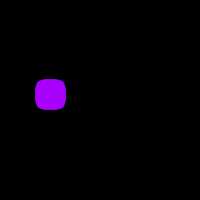

Optical Flow


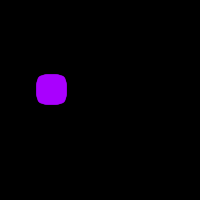

Optical Flow


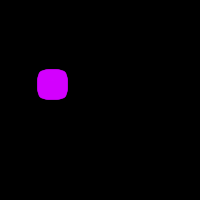

Optical Flow


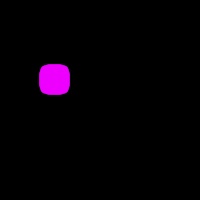

Optical Flow


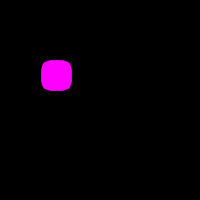

Optical Flow


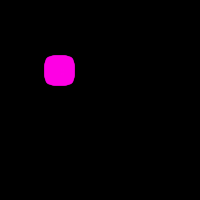

Optical Flow


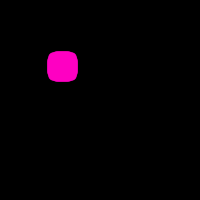

Optical Flow


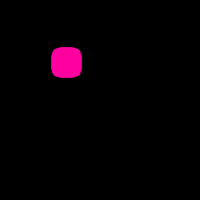

Optical Flow


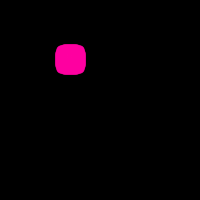

Optical Flow


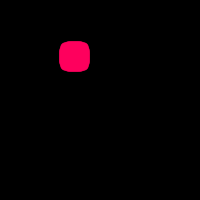

Optical Flow


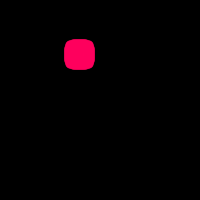

Optical Flow


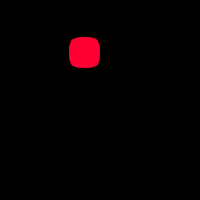

Optical Flow


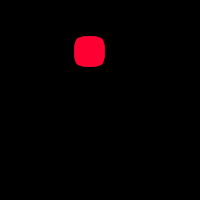

Optical Flow


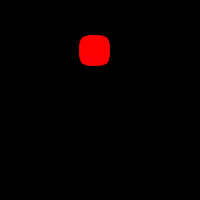

Optical Flow


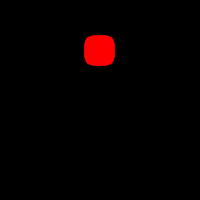

Optical Flow


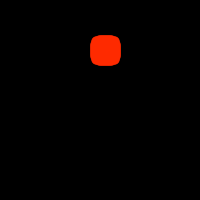

Optical Flow


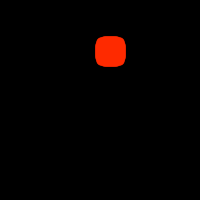

Optical Flow


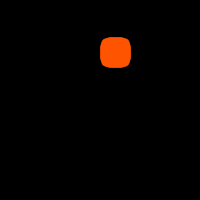

Optical Flow


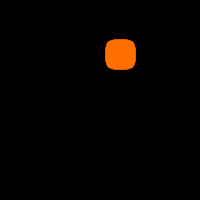

Optical Flow


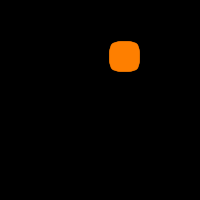

Optical Flow


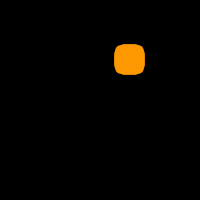

Optical Flow


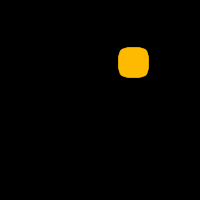

Optical Flow


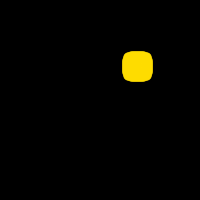

Optical Flow


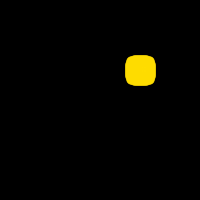

Optical Flow


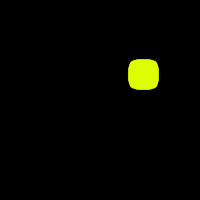

Optical Flow


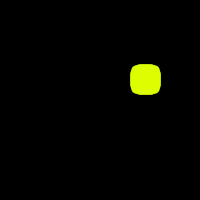

Optical Flow


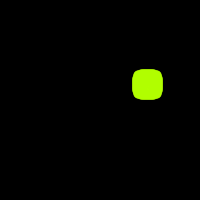

Optical Flow


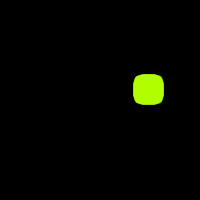

In [ ]:
# オプティカルフローの計算と可視化
for i in range(num_frames - 1):
    frame1 = frames[i]
    frame2 = frames[i + 1]

    # オプティカルフローの計算
    flow = cv2.calcOpticalFlowFarneback(frame1, frame2, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    # 結果の可視化
    hsv = np.zeros_like(cv2.cvtColor(frame1, cv2.COLOR_GRAY2BGR))
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 1] = 255
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    print('Optical Flow')
    cv2_imshow(rgb)
    cv2.waitKey(100)

cv2.destroyAllWindows()


0


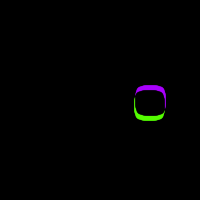

1


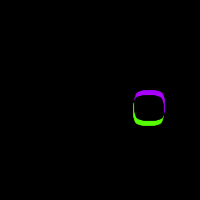

2


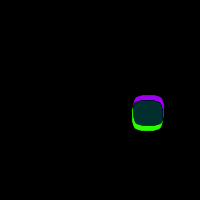

3


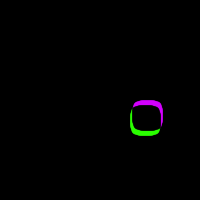

4


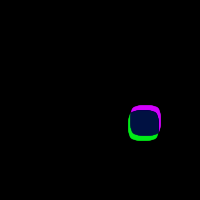

5


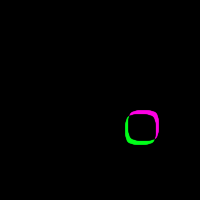

6


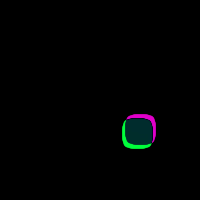

7


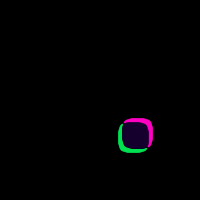

8


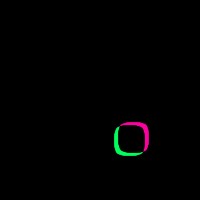

9


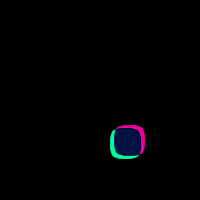

10


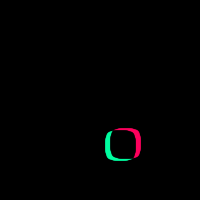

11


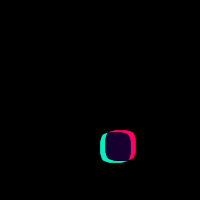

12


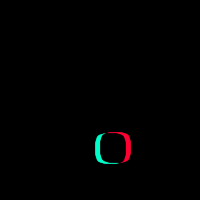

13


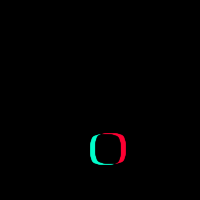

14


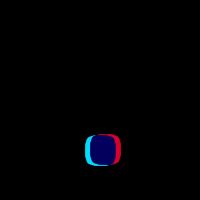

15


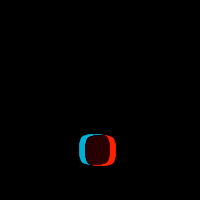

16


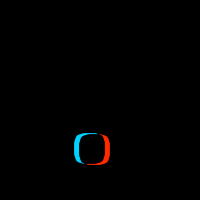

17


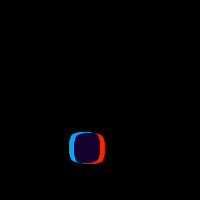

18


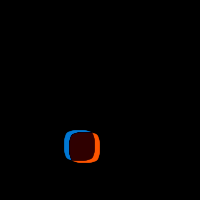

19


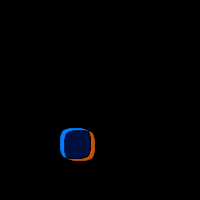

20


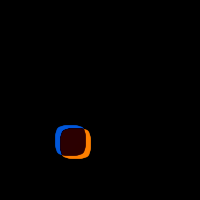

21


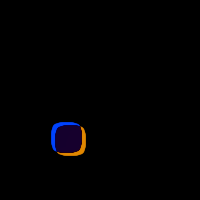

22


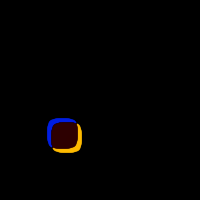

23


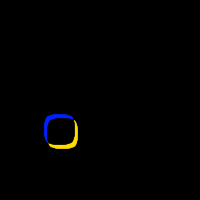

24


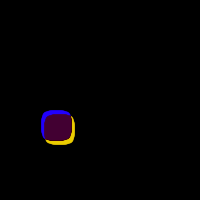

25


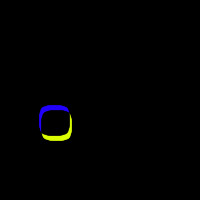

26


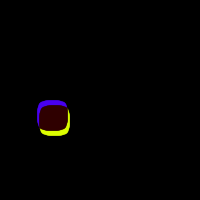

27


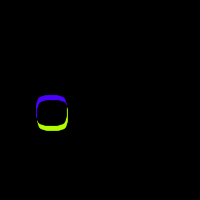

28


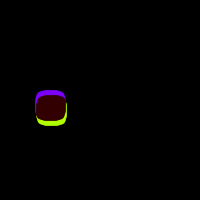

29


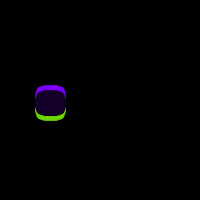

30


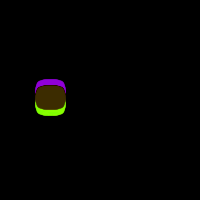

31


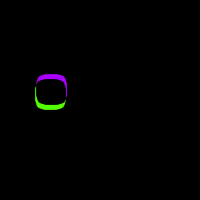

32


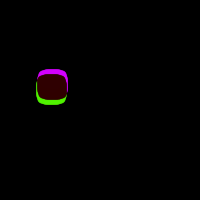

33


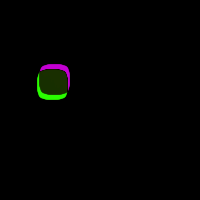

34


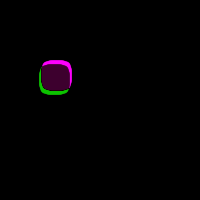

35


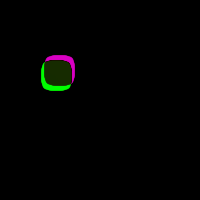

36


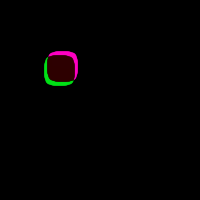

37


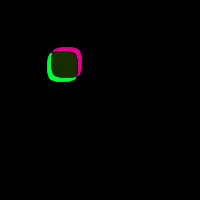

38


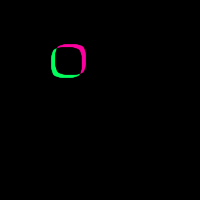

39


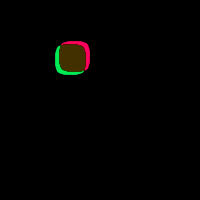

40


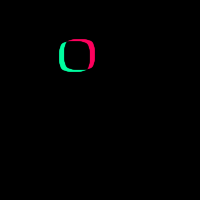

41


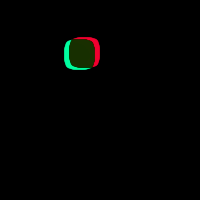

42


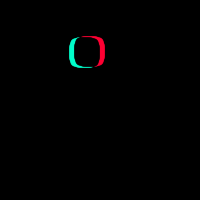

43


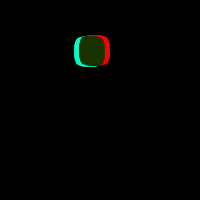

44


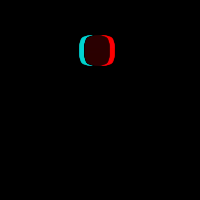

45


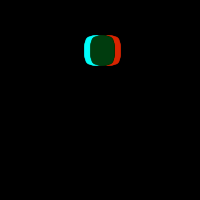

46


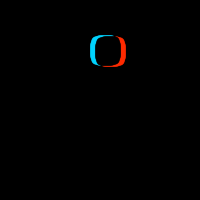

47


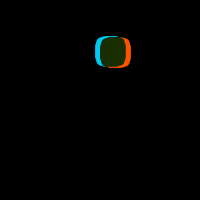

48


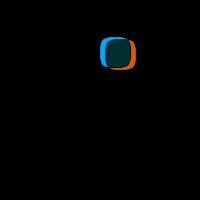

49


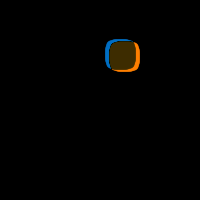

50


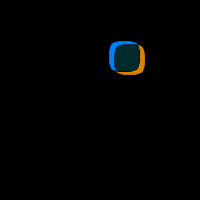

51


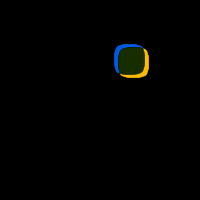

52


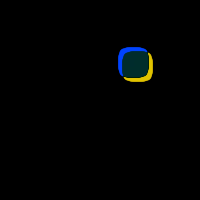

53


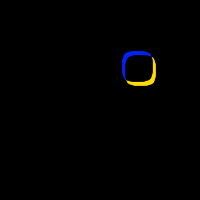

54


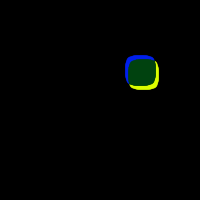

55


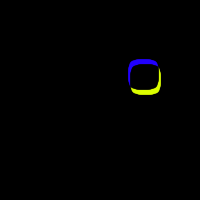

56


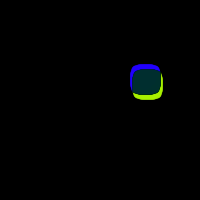

57


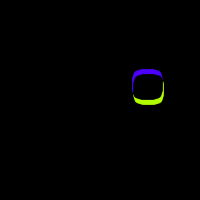

In [ ]:
# 加速度の計算と可視化
accelerations = []
for i in range(num_frames - 2):
    frame1 = frames[i]
    frame2 = frames[i + 1]
    frame3 = frames[i + 2]

    # 速度ベクトルの計算
    flow1 = cv2.calcOpticalFlowFarneback(frame1, frame2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    flow2 = cv2.calcOpticalFlowFarneback(frame2, frame3, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    # 加速度ベクトルの計算
    acceleration = flow2 - flow1
    accelerations.append(acceleration)

    # 結果の可視化
    hsv = np.zeros_like(cv2.cvtColor(frame1, cv2.COLOR_GRAY2BGR))
    mag, ang = cv2.cartToPolar(acceleration[..., 0], acceleration[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 1] = 255
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    print(i)
    cv2_imshow(rgb)
    cv2.waitKey(100)

cv2.destroyAllWindows()


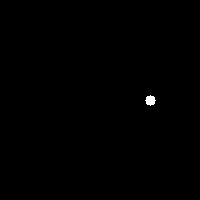

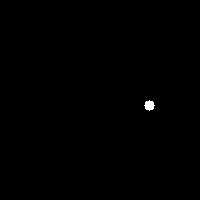

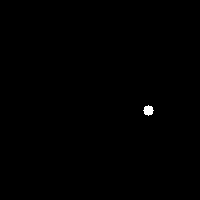

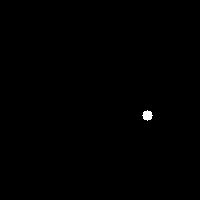

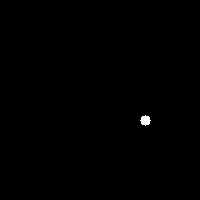

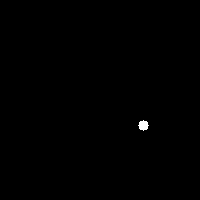

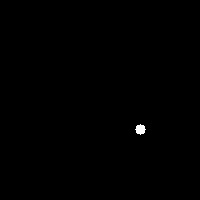

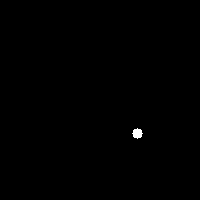

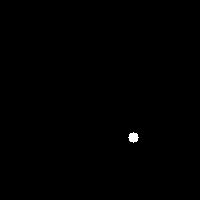

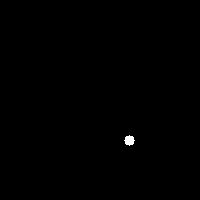

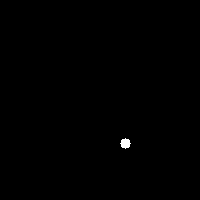

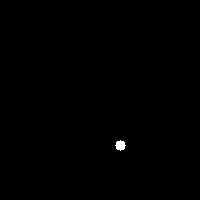

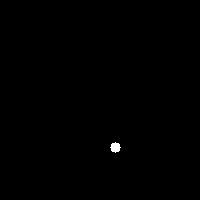

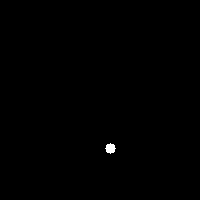

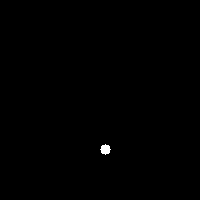

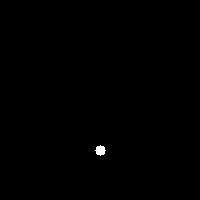

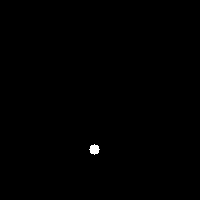

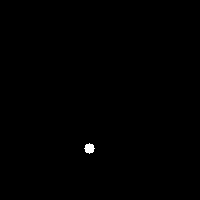

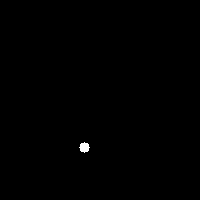

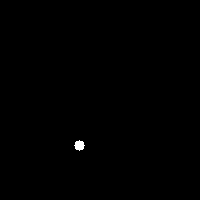

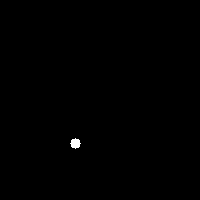

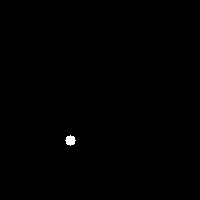

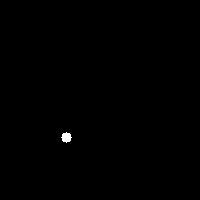

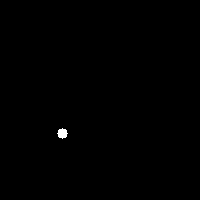

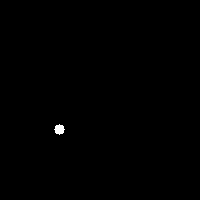

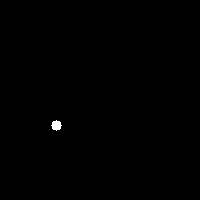

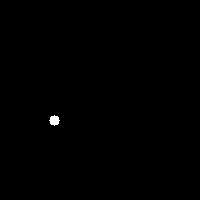

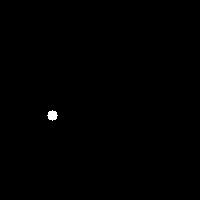

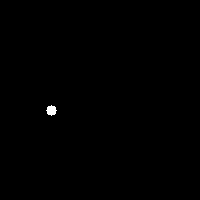

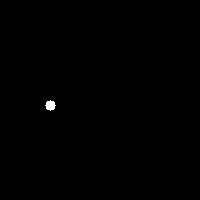

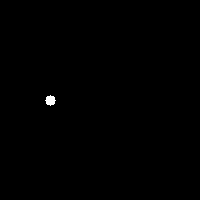

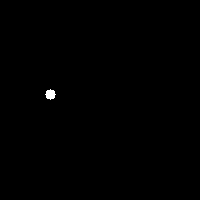

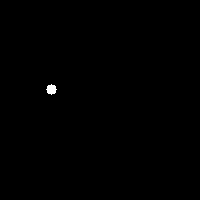

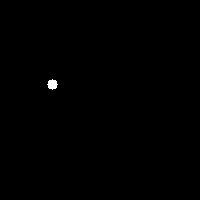

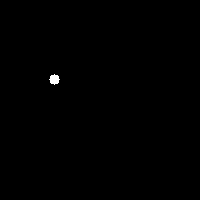

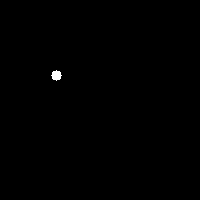

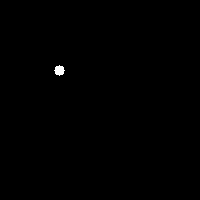

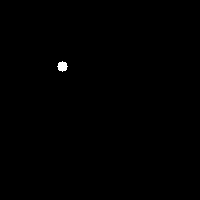

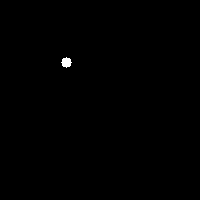

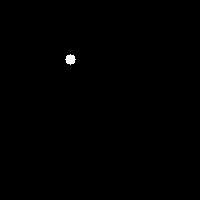

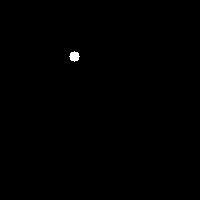

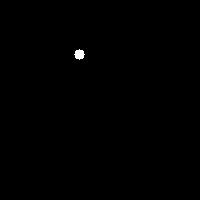

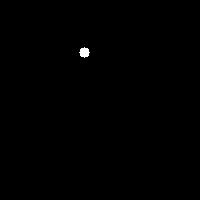

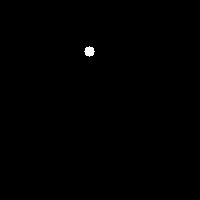

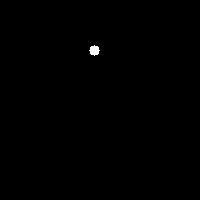

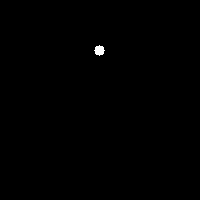

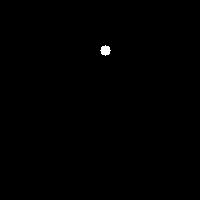

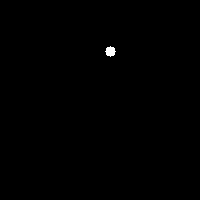

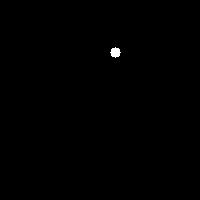

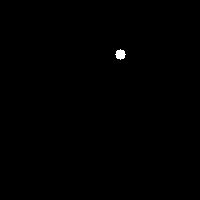

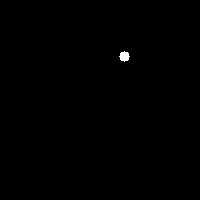

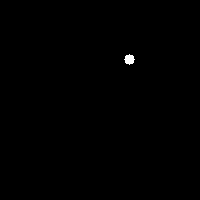

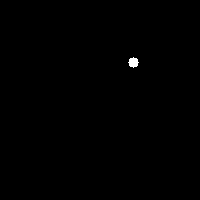

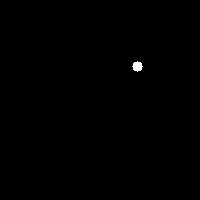

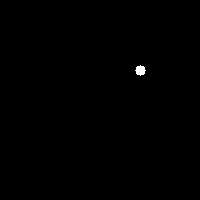

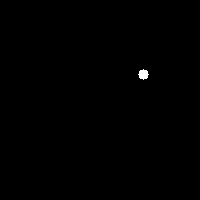

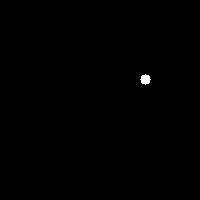

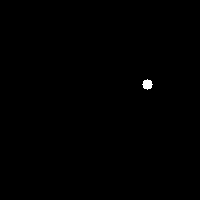

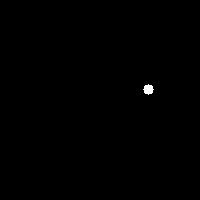

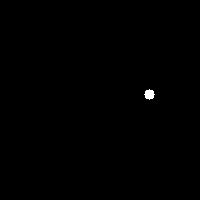

In [ ]:
import cv2
import numpy as np

# シミュレーションパラメータ
num_frames = 60
frame_size = (200, 200)
radius = 50
center = (100, 100)
omega = 2 * np.pi / num_frames  # 一周するための角速度

# フレームの生成
frames = []
for t in range(num_frames):
    frame = np.zeros(frame_size, dtype=np.uint8)
    x = int(center[0] + radius * np.cos(omega * t))
    y = int(center[1] + radius * np.sin(omega * t))
    cv2.circle(frame, (x, y), 5, 255, -1)
    frames.append(frame)

# フレームの表示（確認用）
for frame in frames:
    cv2_imshow(frame)
    cv2.waitKey(100)

cv2.destroyAllWindows()


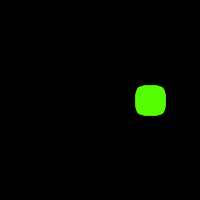

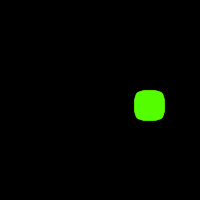

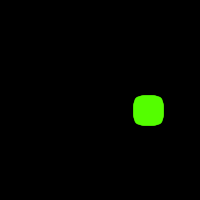

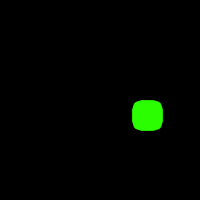

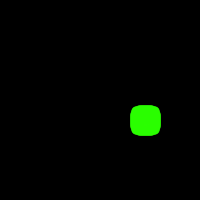

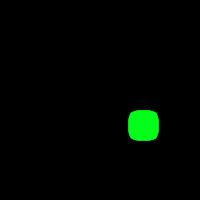

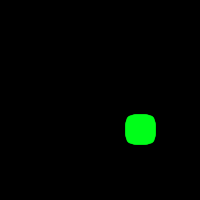

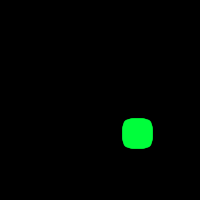

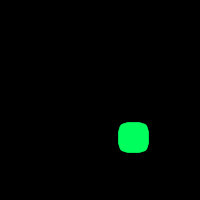

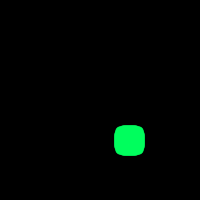

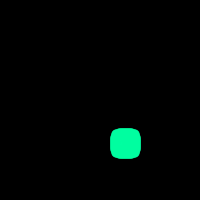

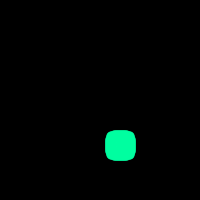

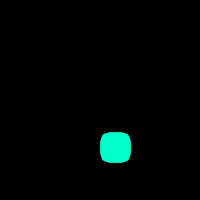

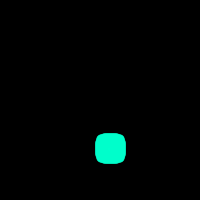

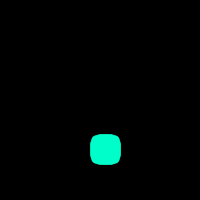

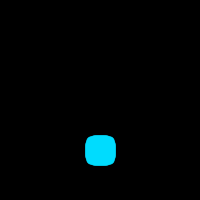

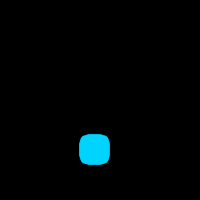

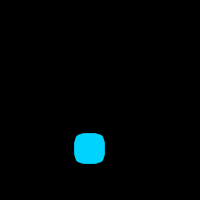

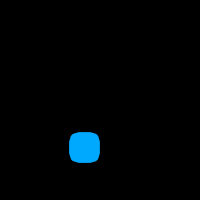

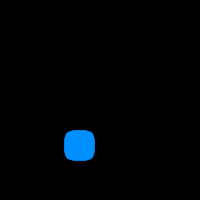

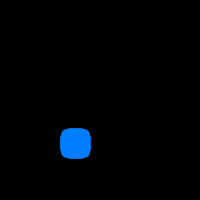

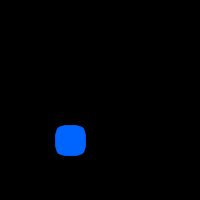

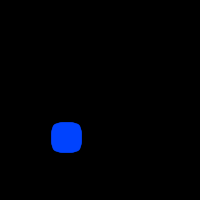

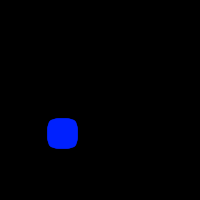

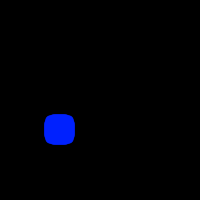

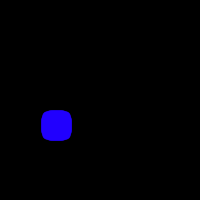

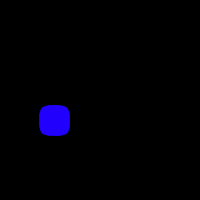

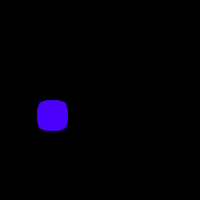

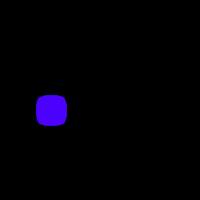

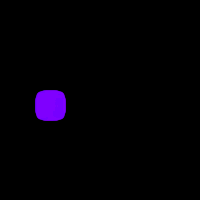

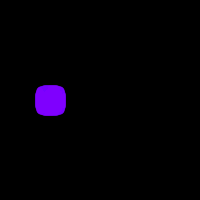

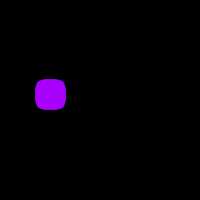

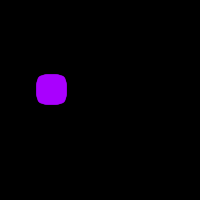

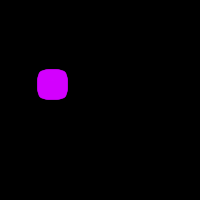

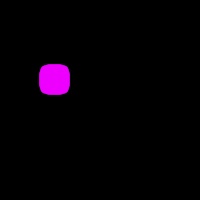

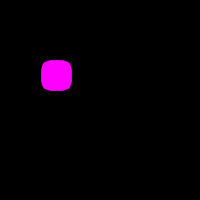

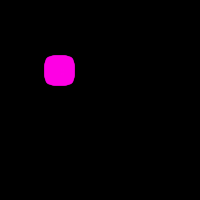

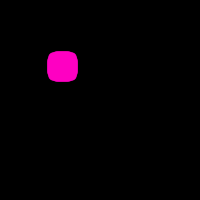

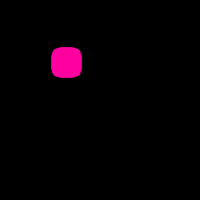

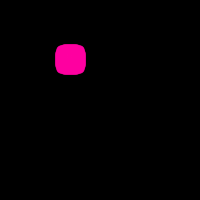

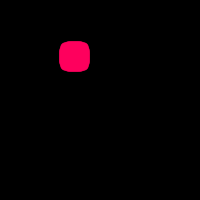

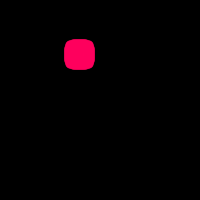

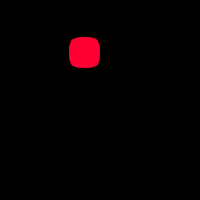

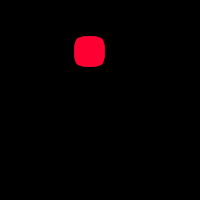

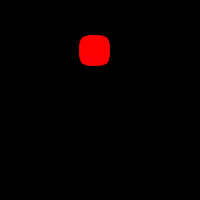

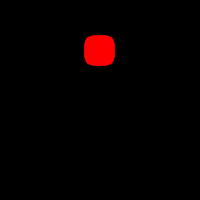

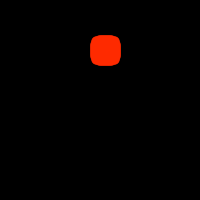

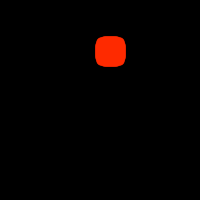

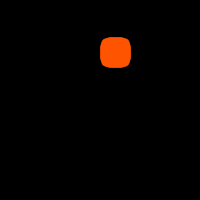

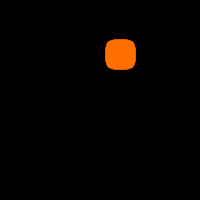

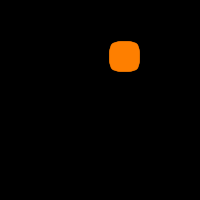

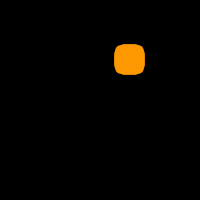

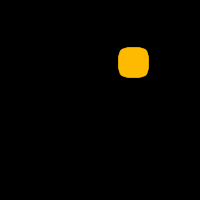

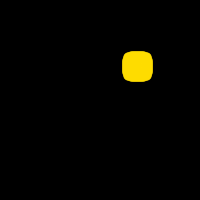

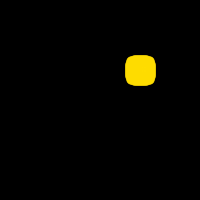

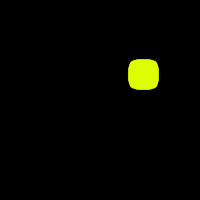

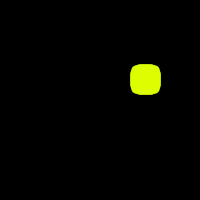

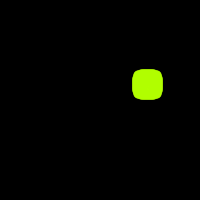

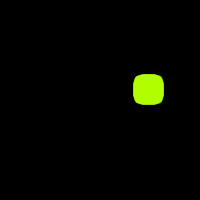

In [ ]:
# オプティカルフローの計算と可視化
for i in range(num_frames - 1):
    frame1 = frames[i]
    frame2 = frames[i + 1]

    # オプティカルフローの計算
    flow = cv2.calcOpticalFlowFarneback(frame1, frame2, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    # 結果の可視化
    hsv = np.zeros_like(cv2.cvtColor(frame1, cv2.COLOR_GRAY2BGR))
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 1] = 255
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    cv2_imshow(rgb)
    cv2.waitKey(100)

cv2.destroyAllWindows()


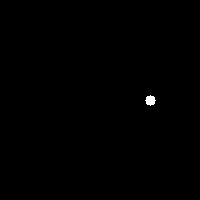

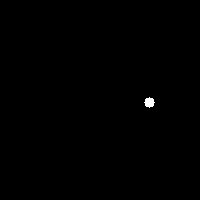

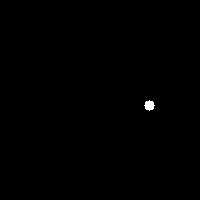

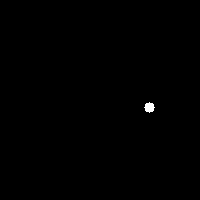

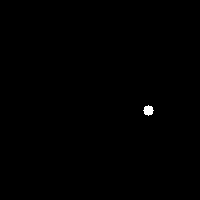

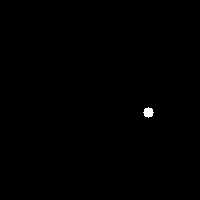

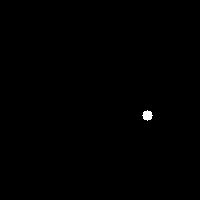

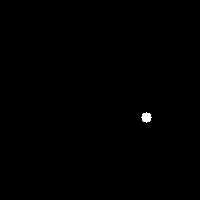

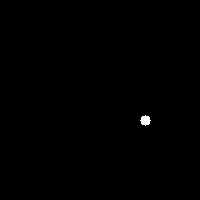

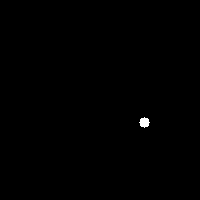

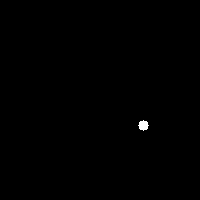

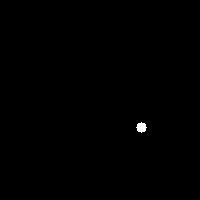

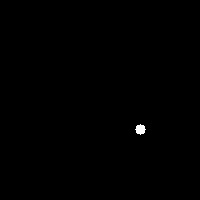

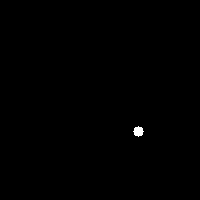

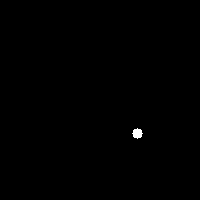

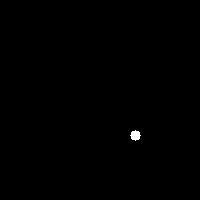

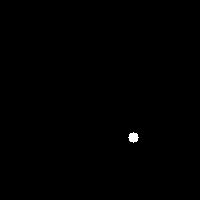

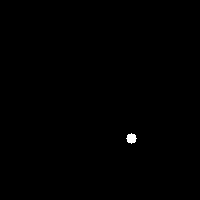

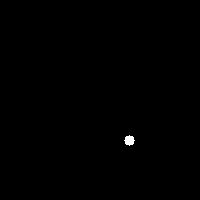

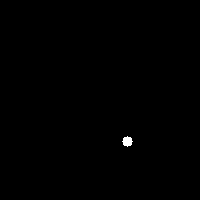

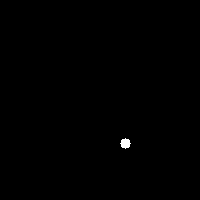

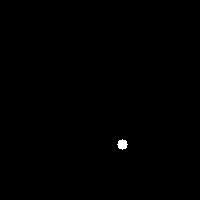

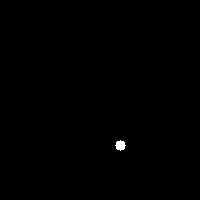

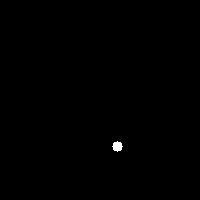

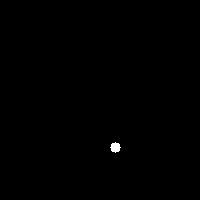

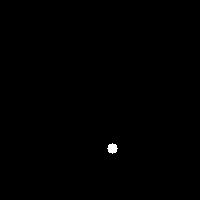

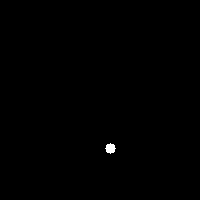

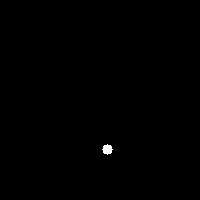

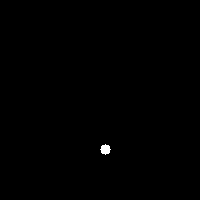

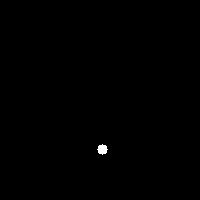

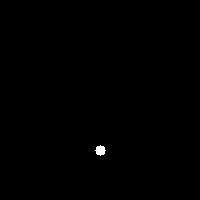

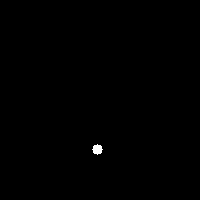

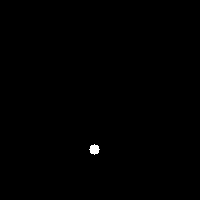

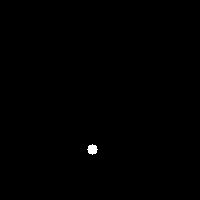

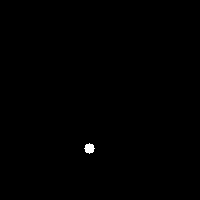

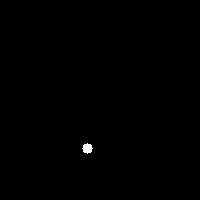

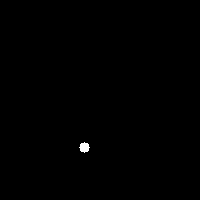

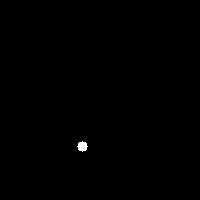

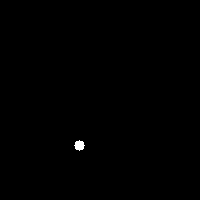

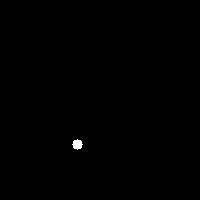

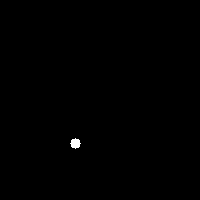

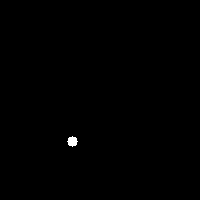

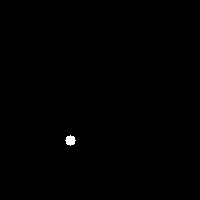

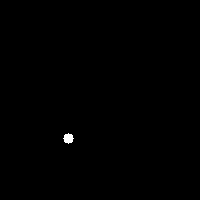

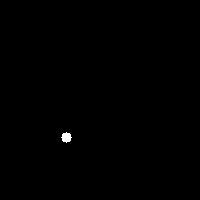

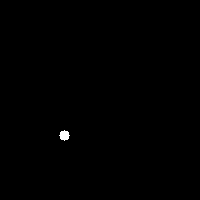

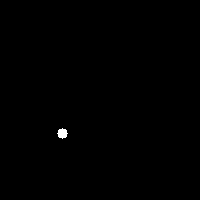

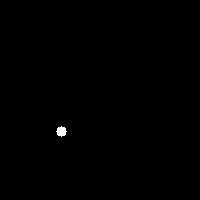

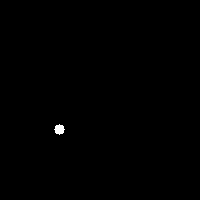

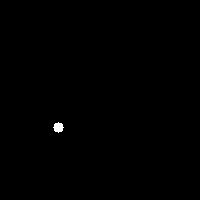

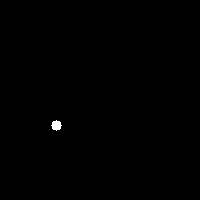

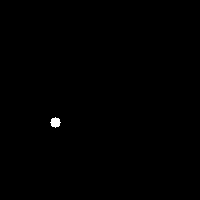

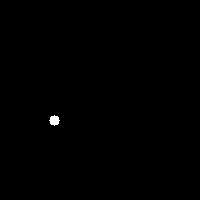

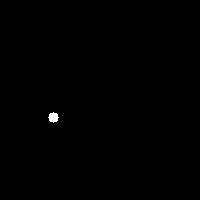

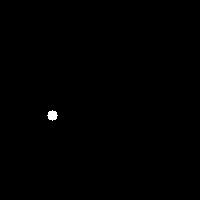

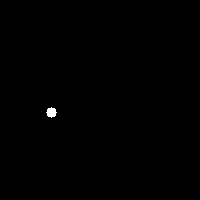

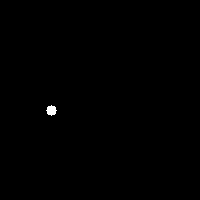

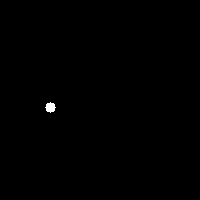

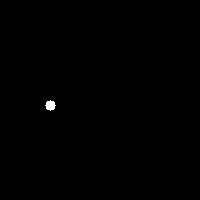

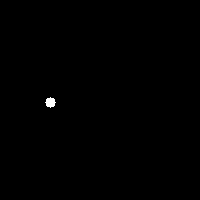

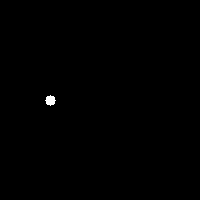

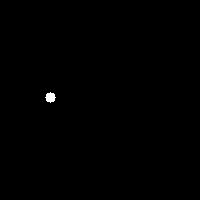

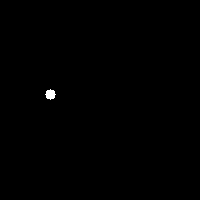

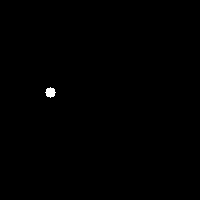

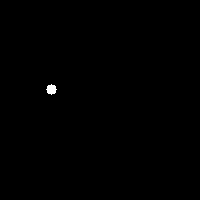

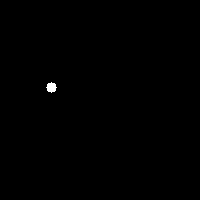

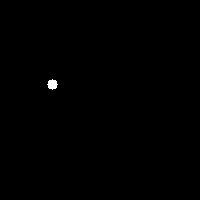

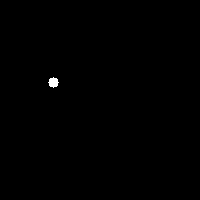

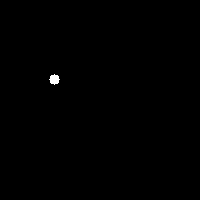

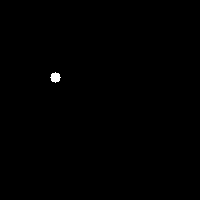

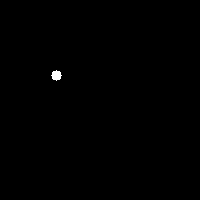

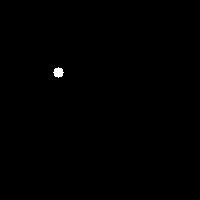

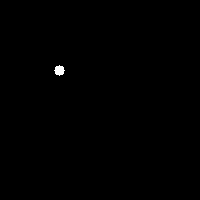

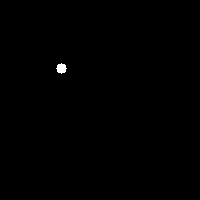

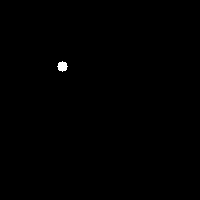

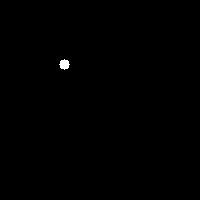

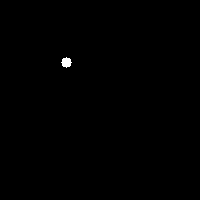

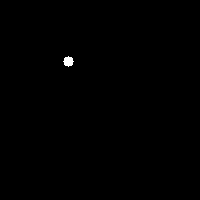

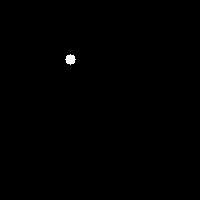

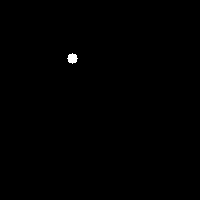

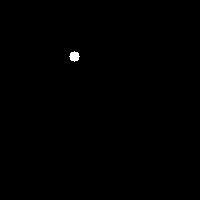

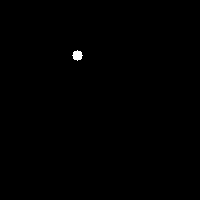

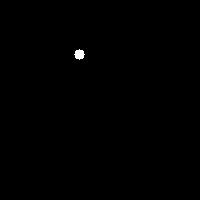

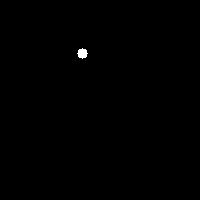

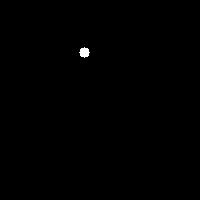

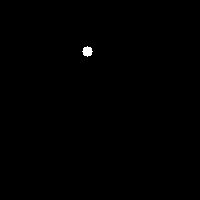

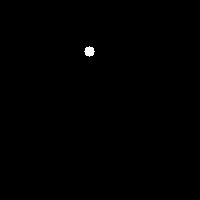

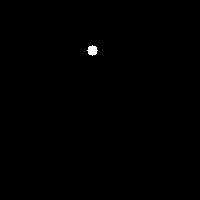

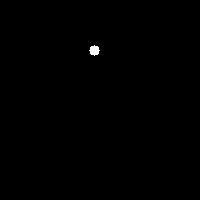

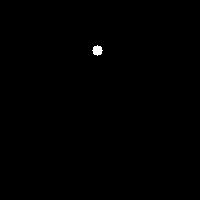

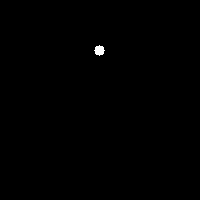

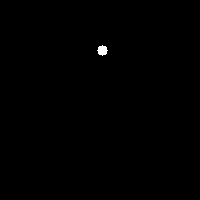

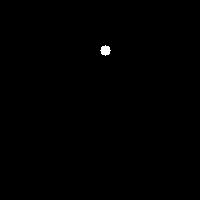

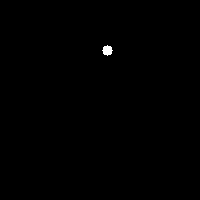

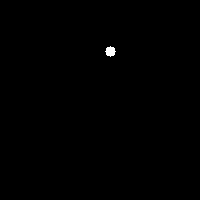

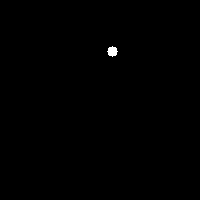

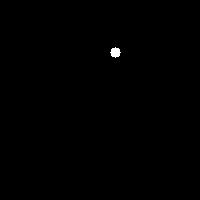

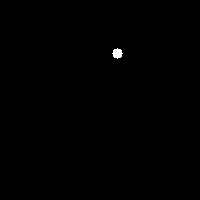

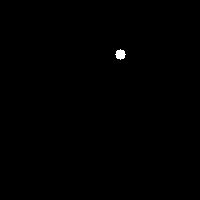

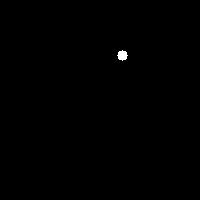

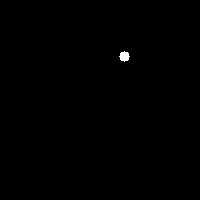

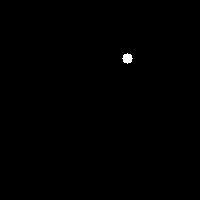

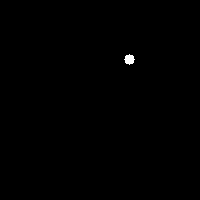

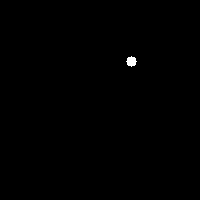

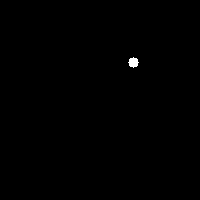

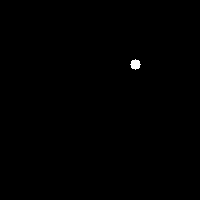

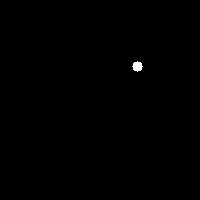

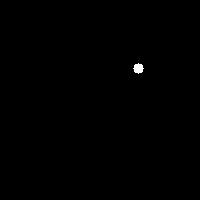

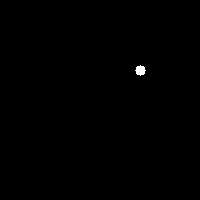

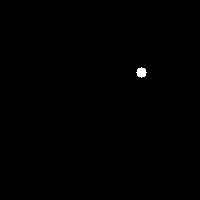

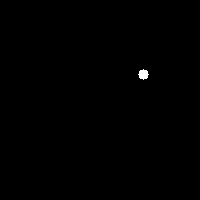

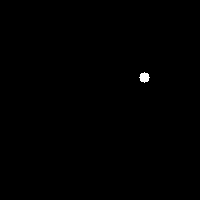

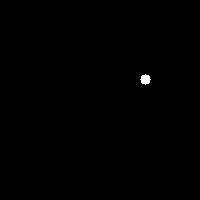

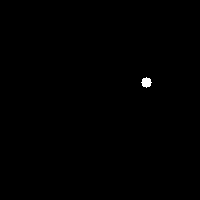

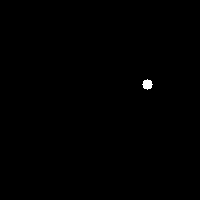

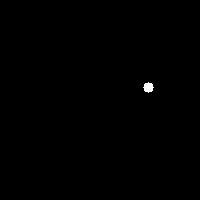

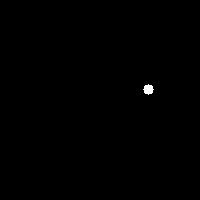

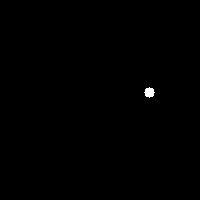

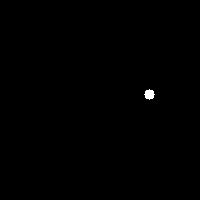

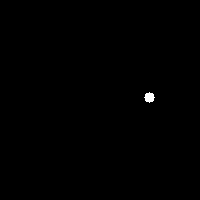

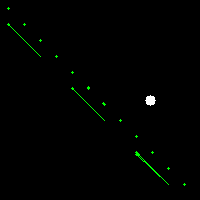

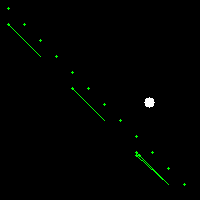

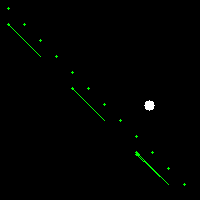

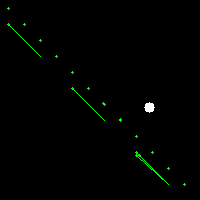

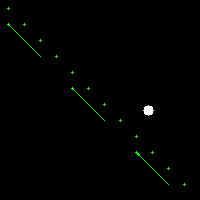

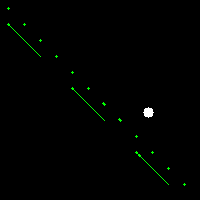

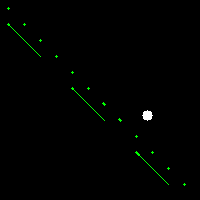

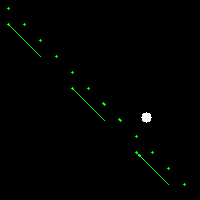

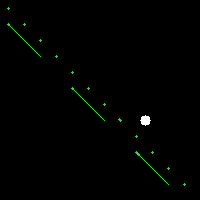

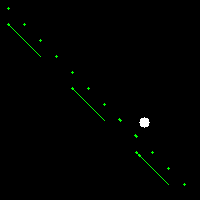

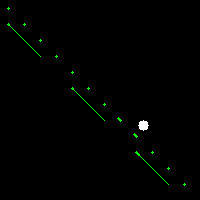

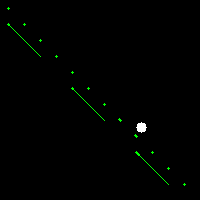

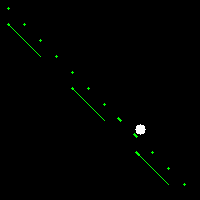

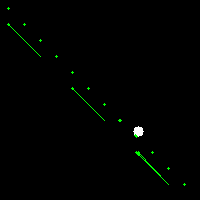

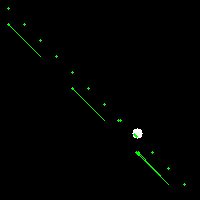

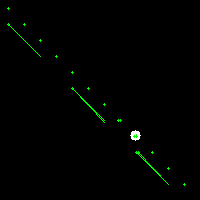

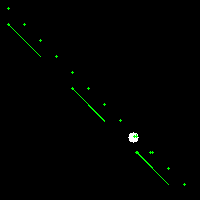

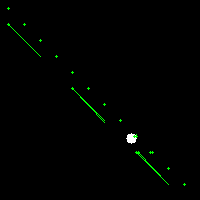

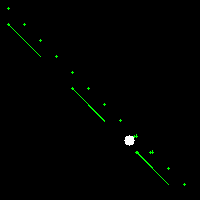

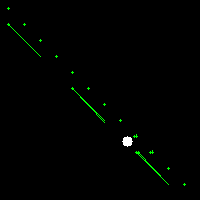

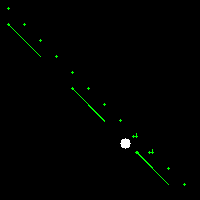

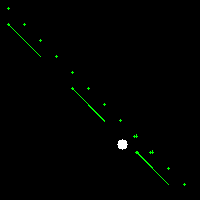

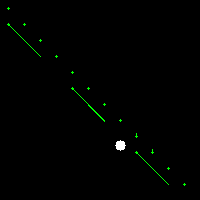

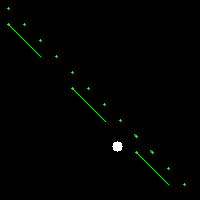

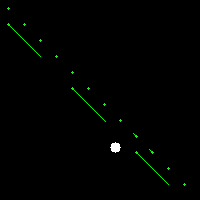

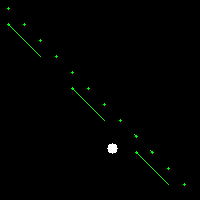

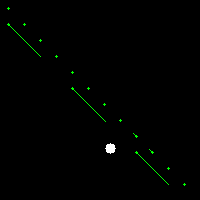

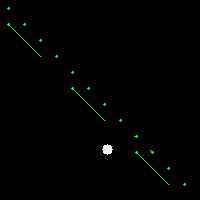

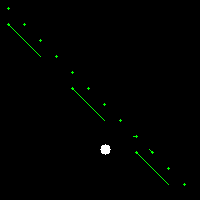

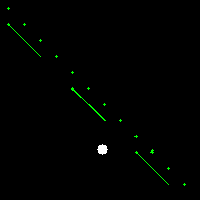

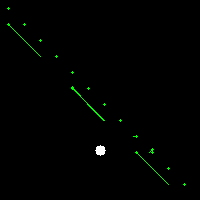

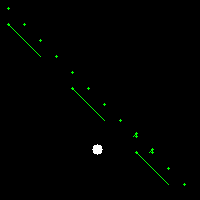

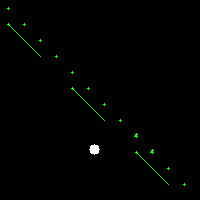

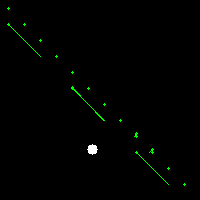

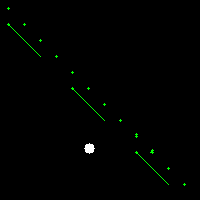

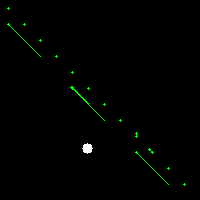

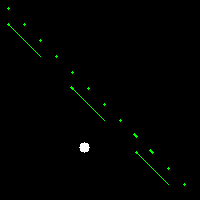

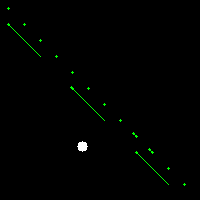

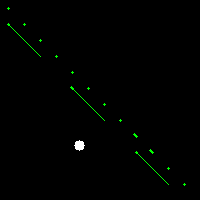

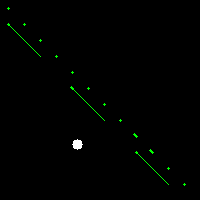

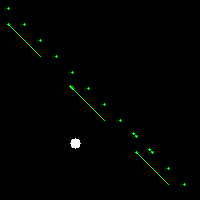

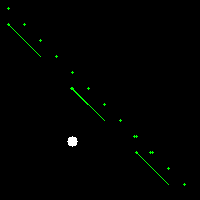

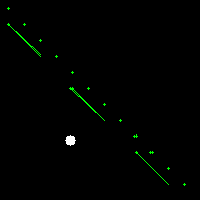

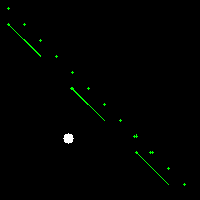

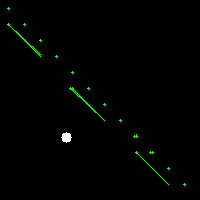

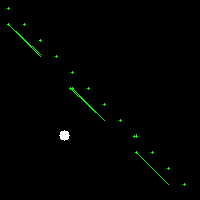

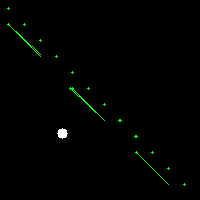

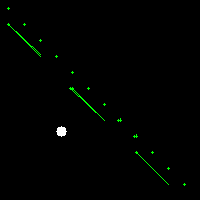

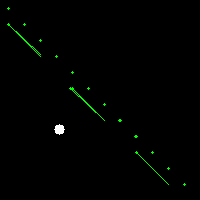

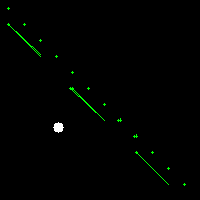

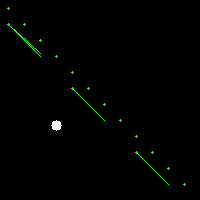

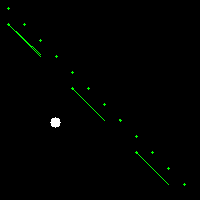

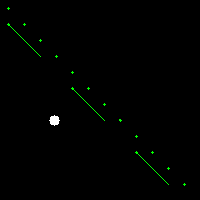

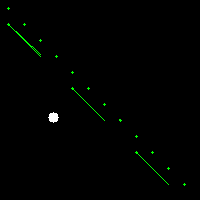

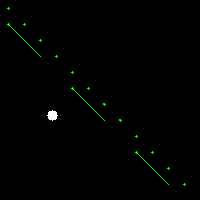

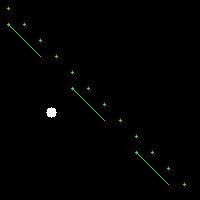

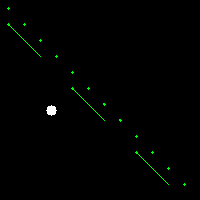

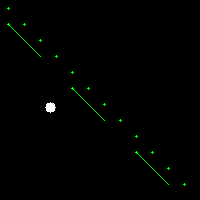

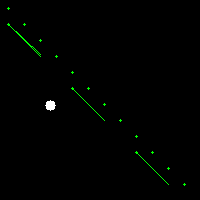

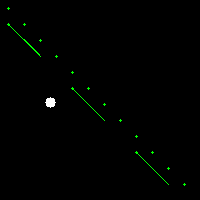

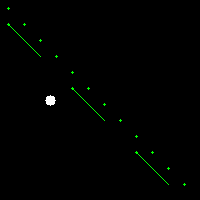

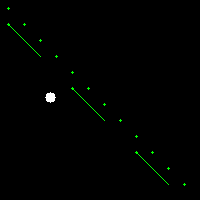

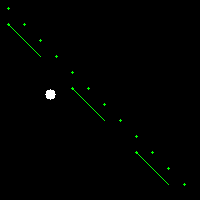

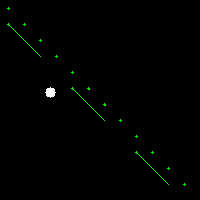

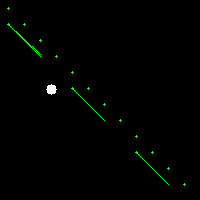

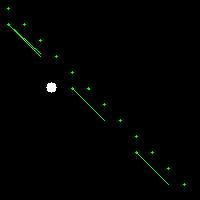

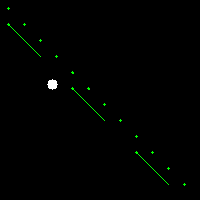

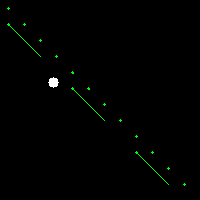

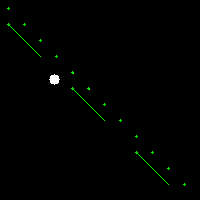

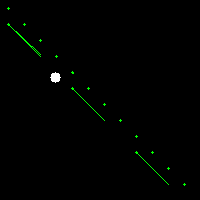

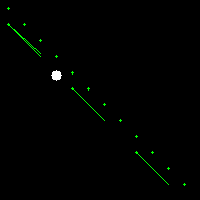

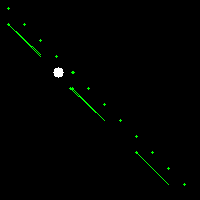

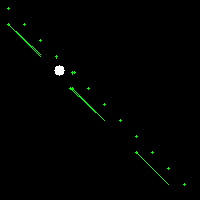

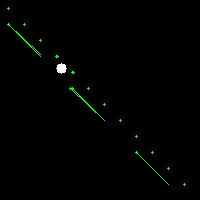

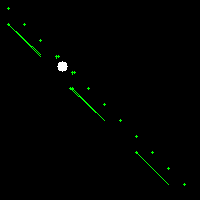

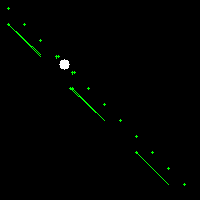

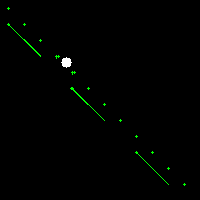

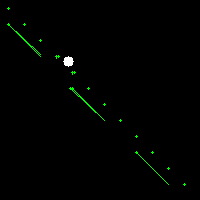

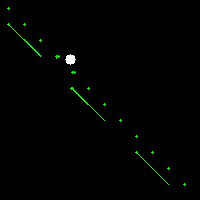

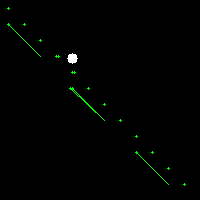

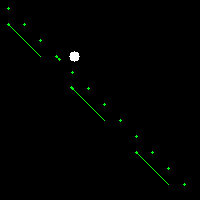

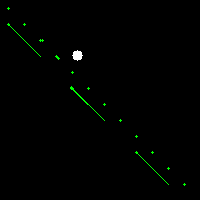

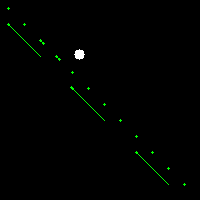

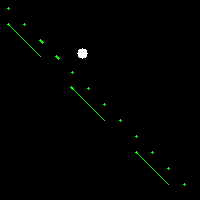

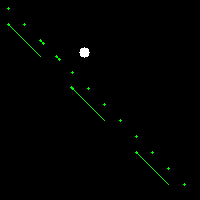

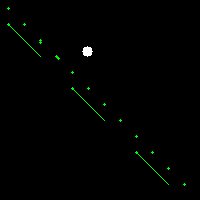

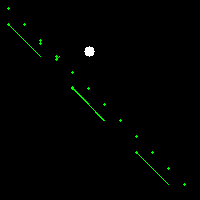

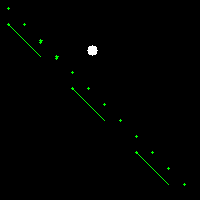

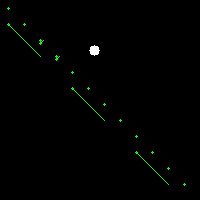

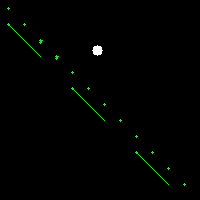

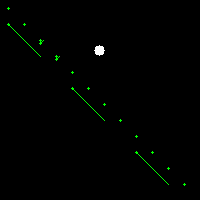

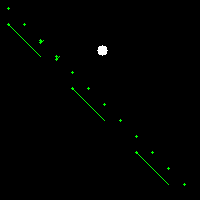

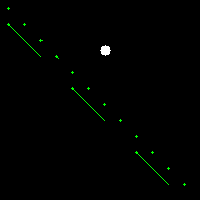

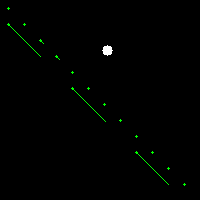

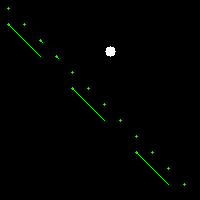

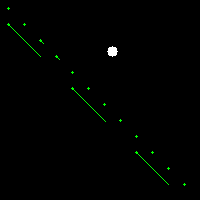

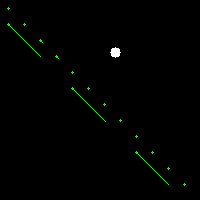

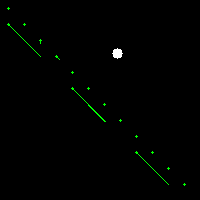

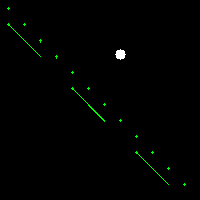

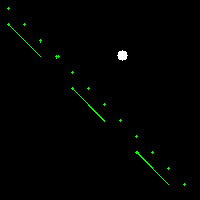

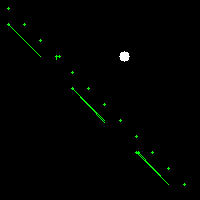

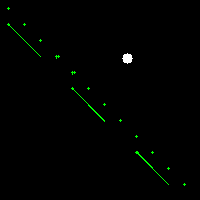

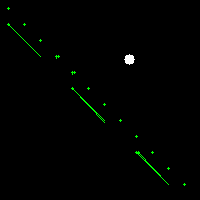

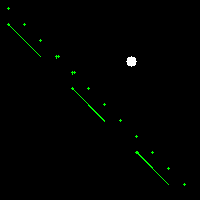

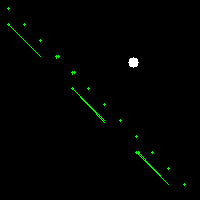

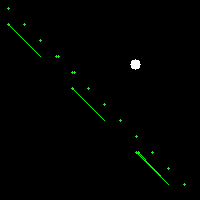

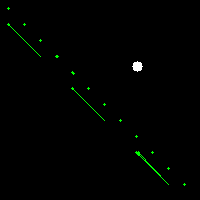

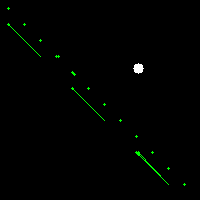

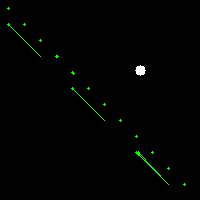

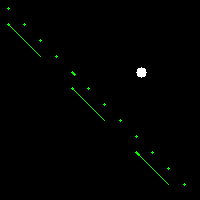

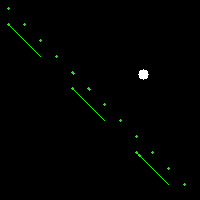

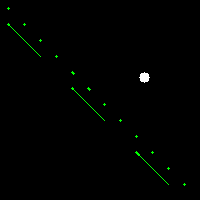

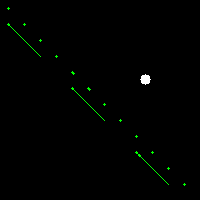

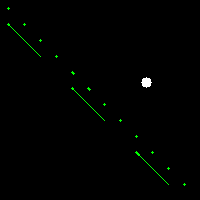

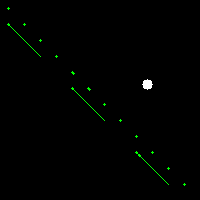

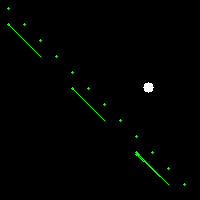

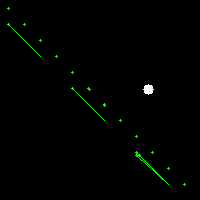

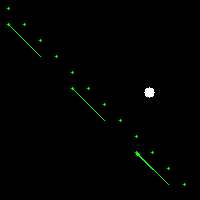

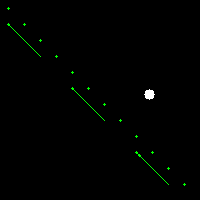

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - Can't parse 'center'. Sequence item with index 0 has a wrong type
>  - Can't parse 'center'. Sequence item with index 0 has a wrong type


In [ ]:
import cv2
import numpy as np

# シミュレーションパラメータ
num_frames = 120  # フレーム数を増やしてフレーム間の変位を小さくする
frame_size = (200, 200)
radius = 50
center = (100, 100)
omega = 2 * np.pi / num_frames  # 一周するための角速度

# フレームの生成
frames = []
for t in range(num_frames):
    frame = np.zeros(frame_size, dtype=np.uint8)
    x = int(center[0] + radius * np.cos(omega * t))
    y = int(center[1] + radius * np.sin(omega * t))
    cv2.circle(frame, (x, y), 5, 255, -1)
    frames.append(frame)

# フレームの表示（確認用）
for frame in frames:
    cv2_imshow(frame)
    cv2.waitKey(50)  # フレームレートを上げる

# オプティカルフローの計算とベクトル表示
for i in range(num_frames - 1):
    frame1 = frames[i]
    frame2 = frames[i + 1]

    # オプティカルフローの計算
    flow = cv2.calcOpticalFlowFarneback(frame1, frame2, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    # ベクトルの表示
    h, w = frame1.shape
    step = 16
    y, x = np.mgrid[step/2:h:step, step/2:w:step].astype(np.int64)
    fx, fy = flow[y, x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = cv2.cvtColor(frame1, cv2.COLOR_GRAY2BGR)
    cv2.polylines(vis, lines, 0, (0, 255, 0))

    for (x1, y1), (x2, y2) in lines:
        cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)

    cv2_imshow(vis)
    cv2.waitKey(50)

cv2.destroyAllWindows()

# 特徴点の検出と追跡
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# 初期フレームの特徴点を検出
p0 = cv2.goodFeaturesToTrack(frames[0], mask=None, **feature_params)

# 特徴点の追跡
for i in range(1, num_frames):
    p1, st, err = cv2.calcOpticalFlowPyrLK(frames[i-1], frames[i], p0, None, **lk_params)

    # ベクトルの表示
    vis = cv2.cvtColor(frames[i], cv2.COLOR_GRAY2BGR)
    for pt in p1:
        x, y = pt.ravel()
        cv2.circle(vis, (x, y), 5, (0, 255, 0), -1)

    cv2_imshow(vis)
    cv2.waitKey(50)

cv2.destroyAllWindows()


In [ ]:
import cv2
import numpy as np

def create_gradient_mask(shape, center, radius):
    y, x = np.ogrid[:shape[0], :shape[1]]
    mask = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    mask = np.clip(mask, 0, radius)
    mask = (radius - mask) / radius
    mask = mask * 255  # マスクを0-255の範囲にスケーリング
    return mask.astype(np.uint8)

def apply_gradient_mask(image, mask):
    return (image * (mask.astype(np.float32) / 255.0)).astype(np.uint8)

def compute_optical_flow_at_centroid(image1, image2, cx, cy):
    # 画像の前処理
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # グラデーションマスクの作成
    radius = 50  # マスクの半径
    mask = create_gradient_mask(gray1.shape, (cx, cy), radius)

    # グラデーションマスクを適用
    masked_gray1 = apply_gradient_mask(gray1, mask)
    masked_gray2 = apply_gradient_mask(gray2, mask)

    # オプティカルフローの計算
    flow = cv2.calcOpticalFlowFarneback(masked_gray1, masked_gray2, None,
                                        pyr_scale=0.5, levels=3, winsize=15,
                                        iterations=3, poly_n=5, poly_sigma=1.2, flags=0)

    # サブピクセル精度での流れを取得
    u = cv2.getRectSubPix(flow[..., 0], (1, 1), (float(cx), float(cy)))[0, 0]
    v = cv2.getRectSubPix(flow[..., 1], (1, 1), (float(cx), float(cy)))[0, 0]

    # 大きさの計算
    magnitude = np.sqrt(u**2 + v**2)

    # 角度の計算
    angle = np.arctan2(v, u)  # ラジアン
    angle_degrees = np.degrees(angle)  # 度に変換

    return (cx, cy, u, v, magnitude, angle, angle_degrees)

def segment_and_compute_centroid(image):
    # 簡単な二値化によるセグメンテーション
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

    # 重心の計算
    moments = cv2.moments(binary)
    if moments['m00'] != 0:
        cx = moments['m10'] / moments['m00']
        cy = moments['m01'] / moments['m00']
    else:
        cx, cy = 0.0, 0.0

    return cx, cy

def compute_acceleration(result1, result2, dt):
    (cx1, cy1, u1, v1, mag1, ang1, ang_deg1) = result1
    (cx2, cy2, u2, v2, mag2, ang2, ang_deg2) = result2

    # 速度ベクトルの変化量
    du = (u2 - u1) / dt
    dv = (v2 - v1) / dt

    # 加速度ベクトルの大きさ
    accel_magnitude = np.sqrt(du**2 + dv**2)

    # 加速度ベクトルの角度
    accel_angle = np.arctan2(dv, du)
    accel_angle_degrees = np.degrees(accel_angle)

    return (cx2, cy2, du, dv, accel_magnitude, accel_angle, accel_angle_degrees)

# 画像が格納されているフォルダのパス
image_folder = 'newmethod'

# 画像ファイルをすべて取得
image_files = sorted(glob.glob(os.path.join(image_folder, '*.png')))

# フレーム間の時間差（秒）
dt = 1 / 30.0  # 例えば、30 FPS の動画の場合

# 初期フレームの重心を計算
initial_frame = cv2.imread(image_files[0])
prev_cx, prev_cy = segment_and_compute_centroid(initial_frame)

# すべてのフレームを処理
for i in range(len(image_files) - 2):
    image1 = cv2.imread(image_files[i])
    image2 = cv2.imread(image_files[i + 1])
    image3 = cv2.imread(image_files[i + 2])

    # 各画像の重心を計算
    cx1, cy1 = segment_and_compute_centroid(image1)
    cx2, cy2 = segment_and_compute_centroid(image2)
    cx3, cy3 = segment_and_compute_centroid(image3)

    # 重心におけるオプティカルフローを計算
    result1 = compute_optical_flow_at_centroid(image1, image2, cx1, cy1)
    result2 = compute_optical_flow_at_centroid(image2, image3, cx2, cy2)

    # 加速度ベクトルを計算
    acceleration = compute_acceleration(result1, result2, dt)

    # 結果の表示
    (cx1, cy1, u1, v1, mag1, ang1, ang_deg1) = result1
    (cx2, cy2, u2, v2, mag2, ang2, ang_deg2) = result2
    (cx3, cy3, du, dv, accel_magnitude, accel_angle, accel_angle_degrees) = acceleration

    # image1 にオプティカルフローを描画
    cv2.circle(image1, (int(cx1), int(cy1)), 5, (0, 255, 0), -1)
    point_st = (int(cx1), int(cy1))
    point_ed = (int(cx1 + u1 * 10), int(cy1 + v1 * 10))  # スケールを適切に調整
    cv2.line(image1, point_st, point_ed, (255, 0, 0), 2)
    print(f"Frame {i+1} to Frame {i+2}: KeyPoint ({cx1}, {cy1}): u={u1}, v={v1}, magnitude={mag1}, angle (radians)={ang1}, angle (degrees)={ang_deg1}")

    # image2 にオプティカルフローを描画
    cv2.circle(image2, (int(cx2), int(cy2)), 5, (0, 255, 0), -1)
    point_st = (int(cx2), int(cy2))
    point_ed = (int(cx2 + u2 * 10), int(cy2 + v2 * 10))  # スケールを適切に調整
    cv2.line(image2, point_st, point_ed, (255, 0, 0), 2)
    print(f"Frame {i+2} to Frame {i+3}: KeyPoint ({cx2}, {cy2}): u={u2}, v={v2}, magnitude={mag2}, angle (radians)={ang2}, angle (degrees)={ang_deg2}")

    # image2 に加速度ベクトルを描画
    cv2.circle(image2, (int(cx2), int(cy2)), 5, (0, 255, 255), -1)  # Yellow circle for acceleration
    point_st = (int(cx2), int(cy2))
    point_ed = (int(cx2 + du * 10), int(cy2 + dv * 10))  # スケールを適切に調整
    cv2.line(image2, point_st, point_ed, (0, 0, 255), 2)
    print(f"Acceleration: KeyPoint ({cx3}, {cy3}): du={du}, dv={dv}, magnitude={accel_magnitude}, angle (radians)={accel_angle}, angle (degrees)={accel_angle_degrees}")

    # 結果の画像を表示または保存
    # print(f'Result Frame {i+1}')
    # cv2_imshow(image1)
    print(f'Result Frame {i+2}')
    cv2_imshow(image2)
    cv2.waitKey(0)

    # 次のフレームのために重心を更新
    prev_cx, prev_cy = cx2, cy2

cv2.destroyAllWindows()



# 重心座標を浮動小数点として計算.

In [ ]:
import cv2
import numpy as np
import glob
import os
import pandas as pd

def create_gradient_mask(shape, center, radius):
    y, x = np.ogrid[:shape[0], :shape[1]]
    mask = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    mask = np.clip(mask, 0, radius)
    mask = (radius - mask) / radius
    mask = mask * 255  # マスクを0-255の範囲にスケーリング
    return mask.astype(np.uint8)

def apply_gradient_mask(image, mask):
    return (image * (mask.astype(np.float32) / 255.0)).astype(np.uint8)

def compute_optical_flow_at_centroid(image1, image2, cx, cy):
    # 画像の前処理
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # グラデーションマスクの作成
    radius = 50  # マスクの半径
    mask = create_gradient_mask(gray1.shape, (cx, cy), radius)

    # グラデーションマスクを適用
    masked_gray1 = apply_gradient_mask(gray1, mask)
    masked_gray2 = apply_gradient_mask(gray2, mask)

    # オプティカルフローの計算
    flow = cv2.calcOpticalFlowFarneback(masked_gray1, masked_gray2, None,
                                        pyr_scale=0.5, levels=3, winsize=15,
                                        iterations=3, poly_n=5, poly_sigma=1.2, flags=0)

    # サブピクセル精度での流れを取得
    u = cv2.getRectSubPix(flow[..., 0], (1, 1), (float(cx), float(cy)))[0, 0]
    v = cv2.getRectSubPix(flow[..., 1], (1, 1), (float(cx), float(cy)))[0, 0]

    # 大きさの計算
    magnitude = np.sqrt(u**2 + v**2)

    # 角度の計算
    angle = np.arctan2(v, u)  # ラジアン
    angle_degrees = np.degrees(angle)  # 度に変換

    return (cx, cy, u, v, magnitude, angle, angle_degrees)

def segment_and_compute_centroid(image):
    # 簡単な二値化によるセグメンテーション
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

    # 重心の計算
    moments = cv2.moments(binary)
    if moments['m00'] != 0:
        cx = moments['m10'] / moments['m00']
        cy = moments['m01'] / moments['m00']
    else:
        cx, cy = 0.0, 0.0

    return cx, cy

def compute_acceleration(result1, result2, dt):
    (cx1, cy1, u1, v1, mag1, ang1, ang_deg1) = result1
    (cx2, cy2, u2, v2, mag2, ang2, ang_deg2) = result2

    # 速度ベクトルの変化量
    du = (u2 - u1) / dt
    dv = (v2 - v1) / dt

    # 加速度ベクトルの大きさ
    accel_magnitude = np.sqrt(du**2 + dv**2)

    # 加速度ベクトルの角度
    accel_angle = np.arctan2(dv, du)
    accel_angle_degrees = np.degrees(accel_angle)

    return (cx2, cy2, du, dv, accel_magnitude, accel_angle, accel_angle_degrees)

def theoretical_values(fr, r, v):
    w = v / r
    x = r * np.cos(w * fr)
    y = r * np.sin(w * fr)
    Vx = -v * np.sin(w * fr)
    Vy = v * np.cos(w * fr)
    Ax = -v * w * np.cos(w * fr)
    Ay = -v * w * np.sin(w * fr)
    return x, y, Vx, Vy, Ax, Ay

# 画像が格納されているフォルダのパス
image_folder = 'newmethod'

# 画像ファイルをすべて取得
image_files = sorted(glob.glob(os.path.join(image_folder, '*.png')))

# フレーム間の時間差（秒）
dt = 1 / 30.0  # 例えば、30 FPS の動画の場合

# 初期フレームの重心を計算
initial_frame = cv2.imread(image_files[0])
prev_cx, prev_cy = segment_and_compute_centroid(initial_frame)

# 結果を格納するリスト
results = []

# すべてのフレームを処理
for i in range(len(image_files) - 2):
    image1 = cv2.imread(image_files[i])
    image2 = cv2.imread(image_files[i + 1])
    image3 = cv2.imread(image_files[i + 2])

    # 各画像の重心を計算
    cx1, cy1 = segment_and_compute_centroid(image1)
    cx2, cy2 = segment_and_compute_centroid(image2)
    cx3, cy3 = segment_and_compute_centroid(image3)

    # 重心におけるオプティカルフローを計算
    result1 = compute_optical_flow_at_centroid(image1, image2, cx1, cy1)
    result2 = compute_optical_flow_at_centroid(image2, image3, cx2, cy2)

    # 加速度ベクトルを計算
    acceleration = compute_acceleration(result1, result2, dt)

    # 理論値を計算
    theoX, theoY, theoVx, theoVy, theoAx, theoAy = theoretical_values(i+1, 200, 1.0)

    # 結果をリストに追加
    results.append([i+1, cx1, cy1, result1[2], result1[3], acceleration[2], acceleration[3],
                    theoX, theoY, theoVx, theoVy, theoAx, theoAy])

    # 次のフレームのために重心を更新
    prev_cx, prev_cy = cx2, cy2

# 結果をデータフレームに変換してCSVファイルに保存
df = pd.DataFrame(results, columns=['Frame', 'X', 'Y', 'Vx', 'Vy', 'Ax', 'Ay', 'TheoX', 'TheoY', 'TheoVx', 'TheoVy', 'TheoAx', 'TheoAy'])
df.to_csv('optical_flow_results.csv', index=False)

print("結果をoptical_flow_results.csvに保存しました。")


結果をoptical_flow_results.csvに保存しました。


# 重心と座標を用いて加速度オプティカルフローを求める.

In [ ]:
import cv2
import numpy as np
import glob
import os
import pandas as pd

def segment_and_compute_centroid(image):
    # 簡単な二値化によるセグメンテーション
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

    # 重心の計算
    moments = cv2.moments(binary)
    if moments['m00'] != 0:
        cx = moments['m10'] / moments['m00']
        cy = moments['m01'] / moments['m00']
    else:
        cx, cy = 0.0, 0.0

    return cx, cy

def compute_velocity_and_acceleration(centroid1, centroid2, centroid3, dt):
    cx1, cy1 = centroid1
    cx2, cy2 = centroid2
    cx3, cy3 = centroid3

    # 速度の計算
    Vx1 = (cx2 - cx1) / dt
    Vy1 = (cy2 - cy1) / dt
    Vx2 = (cx3 - cx2) / dt
    Vy2 = (cy3 - cy2) / dt

    # 加速度の計算
    Ax = (Vx2 - Vx1) / dt
    Ay = (Vy2 - Vy1) / dt

    return Vx1, Vy1, Ax, Ay

def theoretical_values(fr, r, v):
    w = v / r
    x = r * np.cos(w * fr)
    y = r * np.sin(w * fr)
    Vx = -v * np.sin(w * fr)
    Vy = v * np.cos(w * fr)
    Ax = -v * w * np.cos(w * fr)
    Ay = -v * w * np.sin(w * fr)
    return x, y, Vx, Vy, Ax, Ay

# 画像が格納されているフォルダのパス
image_folder = 'newmethod'

# 画像ファイルをすべて取得
image_files = sorted(glob.glob(os.path.join(image_folder, '*.png')))

# フレーム間の時間差（秒）
dt = 1 / 30.0  # 例えば、30 FPS の動画の場合

# 結果を格納するリスト
results = []

# すべてのフレームを処理
for i in range(len(image_files) - 2):
    image1 = cv2.imread(image_files[i])
    image2 = cv2.imread(image_files[i + 1])
    image3 = cv2.imread(image_files[i + 2])

    # 各画像の重心を計算
    cx1, cy1 = segment_and_compute_centroid(image1)
    cx2, cy2 = segment_and_compute_centroid(image2)
    cx3, cy3 = segment_and_compute_centroid(image3)

    # 重心の座標から速度と加速度を計算
    Vx, Vy, Ax, Ay = compute_velocity_and_acceleration((cx1, cy1), (cx2, cy2), (cx3, cy3), dt)

    # 理論値を計算
    theoX, theoY, theoVx, theoVy, theoAx, theoAy = theoretical_values(i+1, 200, 1.0)

    # 結果をリストに追加
    results.append([i+1, cx1, cy1, Vx, Vy, Ax, Ay, theoX, theoY, theoVx, theoVy, theoAx, theoAy])

# 結果をデータフレームに変換してCSVファイルに保存
df = pd.DataFrame(results, columns=['Frame', 'X', 'Y', 'Vx', 'Vy', 'Ax', 'Ay', 'TheoX', 'TheoY', 'TheoVx', 'TheoVy', 'TheoAx', 'TheoAy'])
df.to_csv('centroid_based_acceleration.csv', index=False)

print("結果をcentroid_based_acceleration.csvに保存しました。")


結果をcentroid_based_acceleration.csvに保存しました。


In [ ]:
import cv2
import numpy as np
import glob
import os
import pandas as pd

def segment_and_compute_centroid(image):
    # 簡単な二値化によるセグメンテーション
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

    # 重心の計算
    moments = cv2.moments(binary)
    if moments['m00'] != 0:
        cx = moments['m10'] / moments['m00']
        cy = moments['m01'] / moments['m00']
    else:
        cx, cy = 0.0, 0.0

    return cx, cy

def compute_velocity_and_acceleration(centroid1, centroid2, centroid3, dt):
    cx1, cy1 = centroid1
    cx2, cy2 = centroid2
    cx3, cy3 = centroid3

    # 速度の計算
    Vx1 = (cx2 - cx1) / dt
    Vy1 = (cy2 - cy1) / dt
    Vx2 = (cx3 - cx2) / dt
    Vy2 = (cy3 - cy2) / dt

    # 加速度の計算
    Ax = (Vx2 - Vx1) / dt
    Ay = (Vy2 - Vy1) / dt

    return Vx1, Vy1, Ax, Ay

def theoretical_values(fr, r, v):
    w = v / r
    x = r * np.cos(w * fr)
    y = r * np.sin(w * fr)
    Vx = -v * np.sin(w * fr)
    Vy = v * np.cos(w * fr)
    Ax = -v * w * np.cos(w * fr)
    Ay = -v * w * np.sin(w * fr)
    return x, y, Vx, Vy, Ax, Ay

# 画像が格納されているフォルダのパス
image_folder = 'newmethod'

# 画像ファイルをすべて取得
image_files = sorted(glob.glob(os.path.join(image_folder, '*.png')))

# フレーム間の時間差（秒）
dt = 1 / 30.0  # 例えば、30 FPS の動画の場合

# 結果を格納するリスト
results = []

# すべてのフレームを処理
for i in range(len(image_files) - 2):
    image1 = cv2.imread(image_files[i])
    image2 = cv2.imread(image_files[i + 1])
    image3 = cv2.imread(image_files[i + 2])

    # 各画像の重心を計算
    cx1, cy1 = segment_and_compute_centroid(image1)
    cx2, cy2 = segment_and_compute_centroid(image2)
    cx3, cy3 = segment_and_compute_centroid(image3)

    # 重心の座標から速度と加速度を計算
    Vx, Vy, Ax, Ay = compute_velocity_and_acceleration((cx1, cy1), (cx2, cy2), (cx3, cy3), dt)

    # 加速度ベクトルを描画
    start_point = (int(cx2), int(cy2))
    end_point = (int(cx2 + Ax * 10), int(cy2 + Ay * 10))
    cv2.arrowedLine(image2, start_point, end_point, (0, 0, 255), 2)

    # 結果をリストに追加
    results.append([i+1, cx1, cy1, Vx, Vy, Ax, Ay])

    # 描画されたフレームを保存
    cv2.imwrite(f'output_frame_{i+1}.png', image2)

# 結果をデータフレームに変換してCSVファイルに保存
df = pd.DataFrame(results, columns=['Frame', 'X', 'Y', 'Vx', 'Vy', 'Ax', 'Ay'])
df.to_csv('centroid_based_acceleration.csv', index=False)

print("結果をcentroid_based_acceleration.csvに保存し、フレームを保存しました。")


結果をcentroid_based_fall_acceleration.csvに保存し、フレームを保存しました。


In [ ]:
import cv2
import numpy as np
import glob
import os
import pandas as pd
from scipy.signal import savgol_filter

def segment_and_compute_centroid(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    moments = cv2.moments(binary)
    if moments['m00'] != 0:
        cx = moments['m10'] / moments['m00']
        cy = moments['m01'] / moments['m00']
    else:
        cx, cy = 0.0, 0.0
    return cx, cy

def compute_velocity_and_acceleration(centroid1, centroid2, centroid3, dt):
    cx1, cy1 = centroid1
    cx2, cy2 = centroid2
    cx3, cy3 = centroid3
    # Vx1 = (cx2 - cx1) / dt
    # Vy1 = (cy2 - cy1) / dt
    # Vx2 = (cx3 - cx2) / dt
    # Vy2 = (cy3 - cy2) / dt
    # Ax = (Vx2 - Vx1) / dt
    # Ay = (Vy2 - Vy1) / dt
    Vx1 = (cx2 - cx1)
    Vy1 = (cy2 - cy1)
    Vx2 = (cx3 - cx2)
    Vy2 = (cy3 - cy2)
    Ax = (Vx2 - Vx1)
    Ay = (Vy2 - Vy1)
    return Vx1, Vy1, Ax, Ay

def theoretical_values(fr, r, v):
    w = v / r
    x = r * np.cos(w * fr)
    y = r * np.sin(w * fr)
    Vx = -v * np.sin(w * fr)
    Vy = v * np.cos(w * fr)
    Ax = -v * w * np.cos(w * fr)
    Ay = -v * w * np.sin(w * fr)
    return x, y, Vx, Vy, Ax, Ay

image_folder = 'newmethod'
image_files = sorted(glob.glob(os.path.join(image_folder, '*.png')))
dt = 1 / 30.0

results = []
for i in range(len(image_files) - 2):
    image1 = cv2.imread(image_files[i])
    image2 = cv2.imread(image_files[i + 1])
    image3 = cv2.imread(image_files[i + 2])
    cx1, cy1 = segment_and_compute_centroid(image1)
    cx2, cy2 = segment_and_compute_centroid(image2)
    cx3, cy3 = segment_and_compute_centroid(image3)
    Vx, Vy, Ax, Ay = compute_velocity_and_acceleration((cx1, cy1), (cx2, cy2), (cx3, cy3), dt)
    results.append([i+1, cx1, cy1, Vx, Vy, Ax, Ay])

# データを平滑化
df = pd.DataFrame(results, columns=['Frame', 'X', 'Y', 'Vx', 'Vy', 'Ax', 'Ay'])
df['Vx_smooth'] = savgol_filter(df['Vx'], window_length=5, polyorder=2)
df['Vy_smooth'] = savgol_filter(df['Vy'], window_length=5, polyorder=2)

# 平滑化後の速度から加速度を再計算
df['Ax_smooth'] = df['Vx_smooth'].diff()
df['Ay_smooth'] = df['Vy_smooth'].diff()
# NaN値を0に置換
df.fillna(0, inplace=True)
# 各フレームに加速度ベクトルを描画
for i in range(len(image_files) - 2):
    image2 = cv2.imread(image_files[i + 1])
    cx2, cy2 = df.loc[i, ['X', 'Y']]
    Ax, Ay = df.loc[i, ['Ax_smooth', 'Ay_smooth']]
    start_point = (int(cx2), int(cy2))
    end_point = (int(cx2 + Ax * 10), int(cy2 + Ay * 10))
    cv2.arrowedLine(image2, start_point, end_point, (0, 0, 255), 2)
    cv2.imwrite(f'outputV2_frame_{i+1}.png', image2)

df.to_csv('centroid_based_acceleration_smoothV3.csv', index=False)
print("結果をcentroid_based_acceleration_smooth.csvに保存し、フレームを保存しました。")


結果をcentroid_based_acceleration_smooth.csvに保存し、フレームを保存しました。


In [ ]:
df.to_csv('centroid_based_acceleration_smoothV2.csv', index=False)

In [ ]:
!pip install filterpy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110459 sha256=9d8f0bfd312549d090cf81718314c5cea4346d2791a56a4bfe0c28167b150cf3
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy


In [ ]:
import cv2
import numpy as np
import glob
import os
import pandas as pd
from scipy.signal import savgol_filter, butter, filtfilt
from scipy.ndimage import gaussian_filter1d
from filterpy.kalman import KalmanFilter

def initialize_kalman_filter():
    """

    Returns:

    """
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.F = np.array([[1, 1], [0, 1]])  # 状態遷移行列
    kf.H = np.array([[1, 0]])          # 観測行列
    kf.P *= 1000.                      # 誤差共分散行列の初期設定
    kf.R = np.array([[5]])             # 観測ノイズの共分散
    kf.Q = np.array([[1, 0], [0, 1]])  # プロセスノイズの共分散
    kf.x = np.array([[0], [0]])        # 初期状態
    return kf

def kalman_filter_acceleration(data):
    """

    Args:
      data:

    Returns:

    """
    kf = initialize_kalman_filter()
    filtered_data = []
    for measurement in data:
        kf.predict()
        kf.update([measurement])
        filtered_data.append(kf.x[0][0])
    return np.array(filtered_data)

def segment_and_compute_centroid(image):
    """

    Args:
      image:

    Returns:

    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    moments = cv2.moments(binary)
    if moments['m00'] != 0:
        cx = moments['m10'] / moments['m00']
        cy = moments['m01'] / moments['m00']
    else:
        cx, cy = 0.0, 0.0
    return cx, cy

def compute_velocity_and_acceleration(centroid1, centroid2, centroid3, dt):
    """

    Args:
      centroid1:
      centroid2:
      centroid3:
      dt:

    Returns:

    """
    cx1, cy1 = centroid1
    cx2, cy2 = centroid2
    cx3, cy3 = centroid3

    # Vx1 = (cx2 - cx1) / dt
    # Vy1 = (cy2 - cy1) / dt
    # Vx2 = (cx3 - cx2) / dt
    # Vy2 = (cy3 - cy2) / dt

    # Ax = (Vx2 - Vx1) / dt
    # Ay = (Vy2 - Vy1) / dt

    Vx1 = (cx2 - cx1)
    Vy1 = (cy2 - cy1)
    Vx2 = (cx3 - cx2)
    Vy2 = (cy3 - cy2)

    Ax = (Vx2 - Vx1)
    Ay = (Vy2 - Vy1)

    return Vx1, Vy1, Ax, Ay

def theoretical_values(fr, r, v):
    """

    Args:
      fr:
      r:
      v:

    Returns:

    """
    w = v / r
    x = r * np.cos(w * fr)
    y = r * np.sin(w * fr)
    Vx = -v * np.sin(w * fr)
    Vy = v * np.cos(w * fr)
    Ax = -v * w * np.cos(w * fr)
    Ay = -v * w * np.sin(w * fr)
    return x, y, Vx, Vy, Ax, Ay

def butter_lowpass_filter(data, cutoff, fs, order=5):
    """

    Args:
      data:
      cutoff:
      fs:
      order:

    Returns:

    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

image_folder = 'newmethod'
image_files = sorted(glob.glob(os.path.join(image_folder, '*.png')))
dt = 1 / 30.0

results = []
for i in range(len(image_files) - 2):
    image1 = cv2.imread(image_files[i])
    image2 = cv2.imread(image_files[i + 1])
    image3 = cv2.imread(image_files[i + 2])
    cx1, cy1 = segment_and_compute_centroid(image1)
    cx2, cy2 = segment_and_compute_centroid(image2)
    cx3, cy3 = segment_and_compute_centroid(image3)
    Vx, Vy, Ax, Ay = compute_velocity_and_acceleration((cx1, cy1), (cx2, cy2), (cx3, cy3), dt)
    results.append([i+1, cx1, cy1, Vx, Vy, Ax, Ay])

df = pd.DataFrame(results, columns=['Frame', 'X', 'Y', 'Vx', 'Vy', 'Ax', 'Ay'])
window_length = min(7, len(df))

# Savitzky-Golay フィルタ
df['Vx_smooth_sg'] = savgol_filter(df['Vx'], window_length=window_length, polyorder=2)
df['Vy_smooth_sg'] = savgol_filter(df['Vy'], window_length=window_length, polyorder=2)

# バターワースフィルタ
cutoff = 2.0  # カットオフ周波数
fs = 30.0  # サンプリング周波数
df['Vx_smooth_butter'] = butter_lowpass_filter(df['Vx'], cutoff, fs)
df['Vy_smooth_butter'] = butter_lowpass_filter(df['Vy'], cutoff, fs)

# ガウシアンフィルタ
df['Vx_smooth_gaussian'] = gaussian_filter1d(df['Vx'], sigma=2)
df['Vy_smooth_gaussian'] = gaussian_filter1d(df['Vy'], sigma=2)

df.fillna(0, inplace=True)

# 平滑化後の速度から加速度を再計算
df['Ax_smooth'] = df['Vx_smooth_butter'].diff()
df['Ay_smooth'] = df['Vy_smooth_butter'].diff()
df['Ax_smooth'] = df['Ax_smooth'].fillna(0)
df['Ay_smooth'] = df['Ay_smooth'].fillna(0)
# df['Ax_smooth_gaussian'] = gaussian_filter1d(df['Ax_smooth'], sigma=40)
# df['Ay_smooth_gaussian'] = gaussian_filter1d(df['Ay_smooth'], sigma=40)
# Gaussian Filter with padding
sigma = 40  # Standard deviation for Gaussian filter
Ax_smooth_padded = np.pad(df['Ax_smooth'], (sigma, sigma), mode='reflect')
Ay_smooth_padded = np.pad(df['Ay_smooth'], (sigma, sigma), mode='reflect')

Ax_smooth_gaussian = gaussian_filter1d(Ax_smooth_padded, sigma=sigma)
Ay_smooth_gaussian = gaussian_filter1d(Ay_smooth_padded, sigma=sigma)
df['Ax_smooth_gaussian'] = Ax_smooth_gaussian[sigma:-sigma]
df['Ay_smooth_gaussian'] = Ay_smooth_gaussian[sigma:-sigma]

# Butterworth Filter
# df['Ax_smooth'] = df['Ax_smooth'].fillna(0)
# df['Ay_smooth'] = df['Ay_smooth'].fillna(0)
# N = 2  # Order of the filter
# Wn = 0.03  # Cutoff frequency
# b, a = butter(N, Wn)
# df['Ax_smooth_butter'] = filtfilt(b, a, df['Ax_smooth'])
# df['Ay_smooth_butter'] = filtfilt(b, a, df['Ay_smooth'])
# df['Ax_smooth_butter'] = butter_lowpass_filter(df['Ax_smooth'], cutoff, fs)
# df['Ay_smooth_butter'] = butter_lowpass_filter(df['Ay_smooth'], cutoff, fs)

df.fillna(0, inplace=True)

# 各フレームに加速度ベクトルを描画
for i in range(len(image_files) - 2):
    image2 = cv2.imread(image_files[i + 1])
    cx2, cy2 = df.loc[i, ['X', 'Y']]
    print(df.loc[i, ['Ax_smooth_gaussian', 'Ay_smooth_gaussian']])
    Ax, Ay = df.loc[i, ['Ax_smooth_gaussian', 'Ay_smooth_gaussian']]

    start_point = (int(cx2), int(cy2))
    end_point = (int(cx2 + Ax * 10 ** 4), int(cy2 + Ay * 10 ** 4))
    cv2.arrowedLine(image2, start_point, end_point, (0, 0, 255), 2)
    cv2.imwrite(f'./demo/output_frame_{i+1}.png', image2)

df.to_csv('centroid_based_acceleration_smoothV3.csv', index=False)
print("結果をcentroid_based_acceleration_smoothV3.csvに保存し、フレームを保存しました。")


Ax_smooth_gaussian   -0.005046
Ay_smooth_gaussian   -0.000689
Name: 0, dtype: float64
Ax_smooth_gaussian   -0.005044
Ay_smooth_gaussian   -0.000695
Name: 1, dtype: float64
Ax_smooth_gaussian   -0.005041
Ay_smooth_gaussian   -0.000701
Name: 2, dtype: float64
Ax_smooth_gaussian   -0.005038
Ay_smooth_gaussian   -0.000708
Name: 3, dtype: float64
Ax_smooth_gaussian   -0.005036
Ay_smooth_gaussian   -0.000715
Name: 4, dtype: float64
Ax_smooth_gaussian   -0.005033
Ay_smooth_gaussian   -0.000722
Name: 5, dtype: float64
Ax_smooth_gaussian   -0.005030
Ay_smooth_gaussian   -0.000729
Name: 6, dtype: float64
Ax_smooth_gaussian   -0.005027
Ay_smooth_gaussian   -0.000737
Name: 7, dtype: float64
Ax_smooth_gaussian   -0.005024
Ay_smooth_gaussian   -0.000745
Name: 8, dtype: float64
Ax_smooth_gaussian   -0.005021
Ay_smooth_gaussian   -0.000753
Name: 9, dtype: float64
Ax_smooth_gaussian   -0.005017
Ay_smooth_gaussian   -0.000762
Name: 10, dtype: float64
Ax_smooth_gaussian   -0.005014
Ay_smooth_gaussian   -

<Axes: >

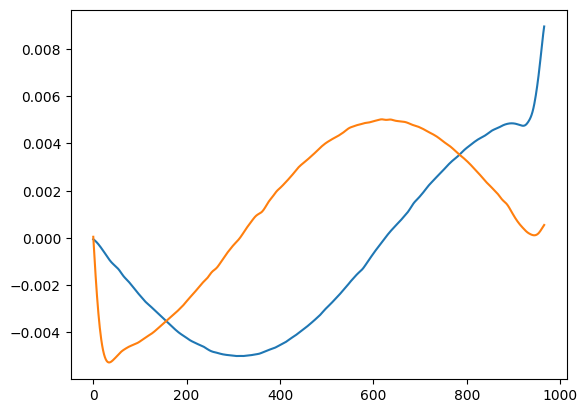

In [ ]:
df = pd.DataFrame(df)
# df.loc[10, ['Ax_smooth', 'Ay_smooth']]
df['Ay_smooth_butter'].plot()
df['Ax_smooth_butter'].plot()

In [ ]:
df['Ay_smooth_butter'].plot()

KeyError: 'Ay_smooth_butter'

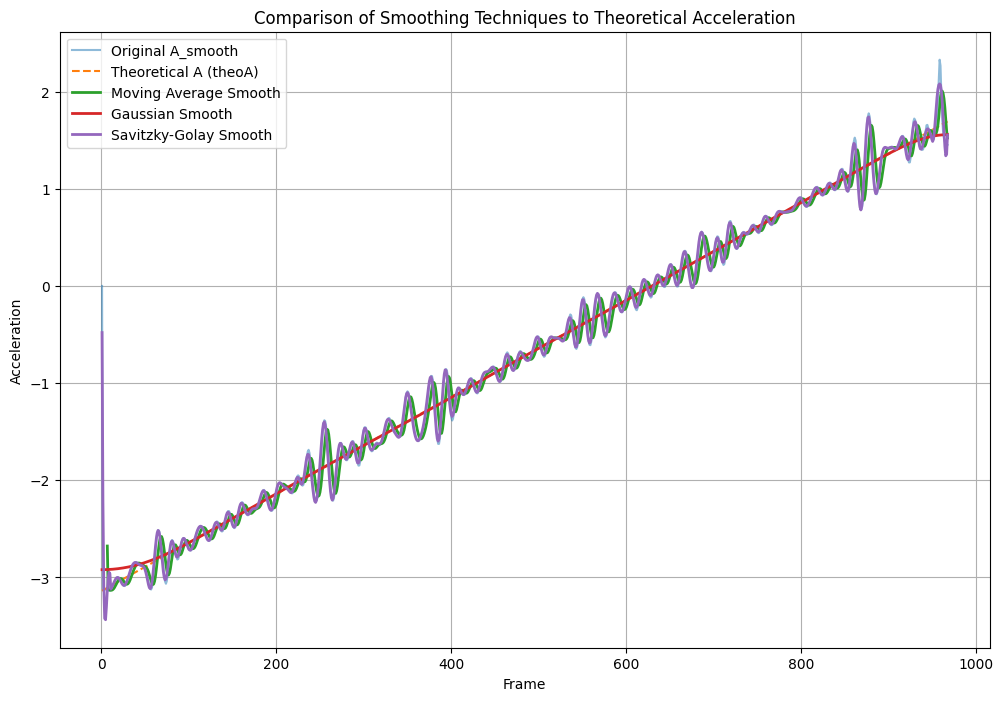

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter

# サンプルデータの作成
# data = {
#     'Frame': np.arange(0, 100),
#     'A_smooth': np.linspace(1, 3, 100) + 0.05 * np.sin(0.2 * np.pi * frames) + 0.05 * np.cos(0.3 * np.pi * frames),
#     'theoA': np.linspace(1, 3, 100)  # 理論値の線形補間
# }
read_csv = pd.read_csv('centroidBasedAccelerationSmoothV3.csv')
data = {
    'Frame': read_csv['Frame'],
    'A_smooth': read_csv['A_smooth'],
    'theoA': read_csv['theoA']
}
df = pd.DataFrame(data)

# データの抽出
frames = df['Frame']
A_smooth = df['A_smooth']
theoA = df['theoA']

# 平滑化手法の適用
# 移動平均
window_size = 7
A_smooth_moving_avg = A_smooth.rolling(window=window_size).mean()

# ガウシアンフィルタ
sigma = 40  # ガウシアンフィルタの標準偏差
A_smooth_gaussian = gaussian_filter1d(A_smooth, sigma=sigma)

# サビツキー・ゴレイフィルタ
window_length = 20
polyorder = 5
A_smooth_savgol = savgol_filter(A_smooth, window_length, polyorder)

# オリジナル、理論値、および平滑化されたデータのプロット
plt.figure(figsize=(12, 8))
plt.plot(frames, A_smooth, label='Original A_smooth', alpha=0.5)
plt.plot(frames, theoA, label='Theoretical A (theoA)', linestyle='--')
plt.plot(frames, A_smooth_moving_avg, label='Moving Average Smooth', linewidth=2)
plt.plot(frames, A_smooth_gaussian, label='Gaussian Smooth', linewidth=2)
plt.plot(frames, A_smooth_savgol, label='Savitzky-Golay Smooth', linewidth=2)
plt.xlabel('Frame')
plt.ylabel('Acceleration')
plt.title('Comparison of Smoothing Techniques to Theoretical Acceleration')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
!pip install ace_tools

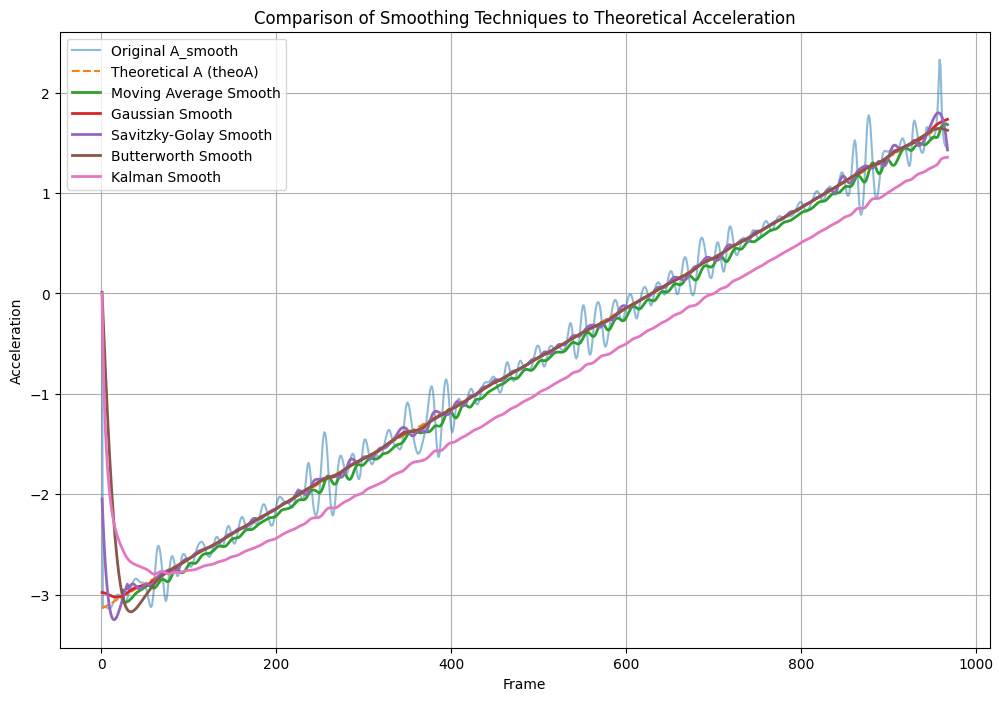

ModuleNotFoundError: No module named 'ace_tools'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter, butter, filtfilt

# Sample data generation with a specific pattern for A_smooth around theoA
# np.random.seed(42)
# frames = np.arange(0, 1000)
# theoA = np.linspace(1, 3, 1000)
# A_smooth = theoA + 0.3 * np.sin(0.2 * np.pi * frames) + 0.1 * np.random.randn(1000)

# Create DataFrame
# df = pd.DataFrame({
#     'Frame': frames,
#     'A_smooth': A_smooth,
#     'theoA': theoA
# })

read_csv = pd.read_csv('centroidBasedAccelerationSmoothV3.csv')
df = {
    'Frame': read_csv['Frame'],
    'A_smooth': read_csv['A_smooth'],
    'theoA': read_csv['theoA']
}

# Moving Average
window_size = 25
df['A_smooth_moving_avg'] = df['A_smooth'].rolling(window=window_size).mean()

# # Gaussian Filter
# sigma = 15  # Standard deviation for Gaussian filter
# df['A_smooth_gaussian'] = gaussian_filter1d(df['A_smooth'], sigma=sigma)

# Gaussian Filter with padding
sigma = 10  # Standard deviation for Gaussian filter
A_smooth_padded = np.pad(df['A_smooth'], pad_width=sigma, mode='reflect')
A_smooth_gaussian = gaussian_filter1d(A_smooth_padded, sigma=sigma)
df['A_smooth_gaussian'] = A_smooth_gaussian[sigma:-sigma]

# Savitzky-Golay Filter
window_length = 60
polyorder = 4
df['A_smooth_savgol'] = savgol_filter(df['A_smooth'], window_length, polyorder)

# Butterworth Filter
N = 2  # Order of the filter
Wn = 0.03  # Cutoff frequency
b, a = butter(N, Wn)
df['A_smooth_butter'] = filtfilt(b, a, df['A_smooth'])

# Kalman Filter Implementation
def kalman_filter(data, Q, R):
    n = len(data)
    x = np.zeros(n)
    P = np.zeros(n)
    x[0] = data[0]
    P[0] = 1.0
    for k in range(1, n):
        # Prediction step
        x_pred = x[k-1]
        P_pred = P[k-1] + Q
        # Update step
        K = P_pred / (P_pred + R)
        x[k] = x_pred + K * (data[k] - x_pred)
        P[k] = (1 - K) * P_pred
    return x

# Set process variance (Q) and measurement variance (R)
Q = 0.001  # Process variance (Adjusted)
R = 5.0  # Measurement variance (Adjusted)

# Apply Kalman Filter
df['A_smooth_kalman'] = kalman_filter(df['A_smooth'], Q, R)

# Plot the original, theoretical, and smoothed data
plt.figure(figsize=(12, 8))
plt.plot(df['Frame'], df['A_smooth'], label='Original A_smooth', alpha=0.5)
plt.plot(df['Frame'], df['theoA'], label='Theoretical A (theoA)', linestyle='--')
plt.plot(df['Frame'], df['A_smooth_moving_avg'], label='Moving Average Smooth', linewidth=2)
plt.plot(df['Frame'], df['A_smooth_gaussian'], label='Gaussian Smooth', linewidth=2)
plt.plot(df['Frame'], df['A_smooth_savgol'], label='Savitzky-Golay Smooth', linewidth=2)
plt.plot(df['Frame'], df['A_smooth_butter'], label='Butterworth Smooth', linewidth=2)
plt.plot(df['Frame'], df['A_smooth_kalman'], label='Kalman Smooth', linewidth=2)
plt.xlabel('Frame')
plt.ylabel('Acceleration')
plt.title('Comparison of Smoothing Techniques to Theoretical Acceleration')
plt.legend()
plt.grid(True)
plt.show()

import ace_tools as tools; tools.display_dataframe_to_user(name="Optimized Smoothing Techniques Data", dataframe=df)

df.head()



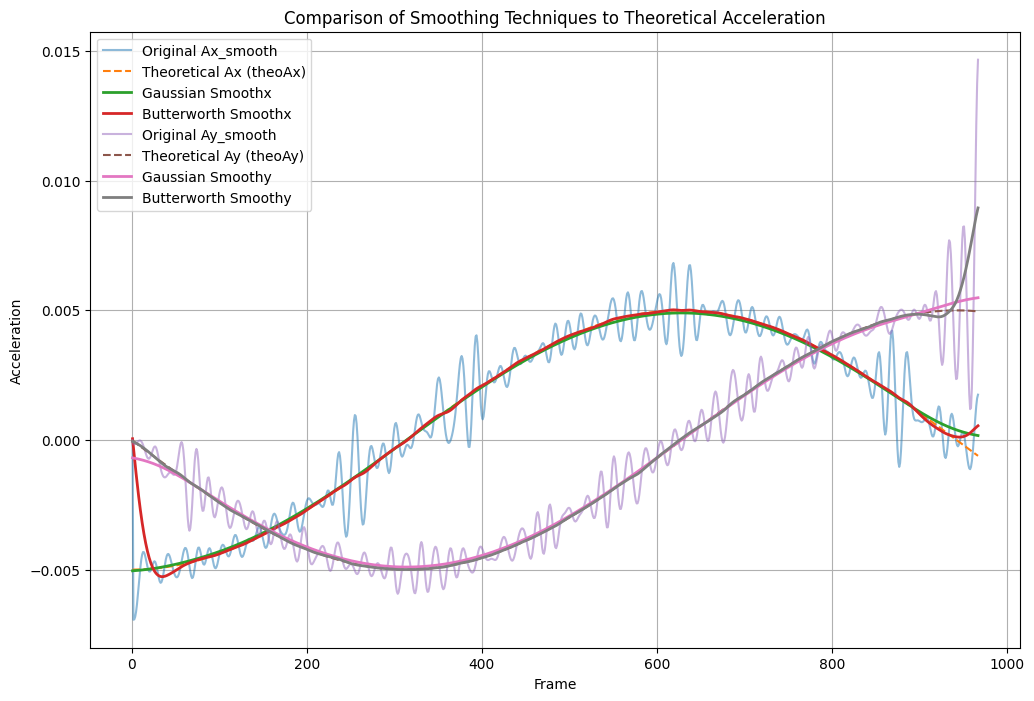

ModuleNotFoundError: No module named 'ace_tools'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter, butter, filtfilt

# Sample data generation with a specific pattern for A_smooth around theoA
# np.random.seed(42)
# frames = np.arange(0, 1000)
# theoA = np.linspace(1, 3, 1000)
# A_smooth = theoA + 0.3 * np.sin(0.2 * np.pi * frames) + 0.1 * np.random.randn(1000)

# Create DataFrame
# df = pd.DataFrame({
#     'Frame': frames,
#     'A_smooth': A_smooth,
#     'theoA': theoA
# })

read_csv = pd.read_csv('centroidBasedAccelerationSmoothV3.csv')
df = {
    'Frame': read_csv['Frame'],
    'TheoAy': read_csv['TheoAy'],
    'TheoAx': read_csv['TheoAx'],
    'Ay_smooth': read_csv['Ay_smooth'],
    'Ax_smooth': read_csv['Ax_smooth']
}

# Moving Average
window_size = 25
df['Ax_smooth_moving_avg'] = df['Ax_smooth'].rolling(window=window_size).mean()
df['Ay_smooth_moving_avg'] = df['Ay_smooth'].rolling(window=window_size).mean()


# Gaussian Filter with padding
sigma = 40  # Standard deviation for Gaussian filter
Ax_smooth_padded = np.pad(df['Ax_smooth'], (sigma, sigma), mode='reflect')
Ay_smooth_padded = np.pad(df['Ay_smooth'], (sigma, sigma), mode='reflect')

Ax_smooth_gaussian = gaussian_filter1d(Ax_smooth_padded, sigma=sigma)
Ay_smooth_gaussian = gaussian_filter1d(Ay_smooth_padded, sigma=sigma)
df['Ax_smooth_gaussian'] = Ax_smooth_gaussian[sigma:-sigma]
df['Ay_smooth_gaussian'] = Ay_smooth_gaussian[sigma:-sigma]


# Savitzky-Golay Filter
window_length = 60
polyorder = 4
df['Ax_smooth_savgol'] = savgol_filter(df['Ax_smooth'], window_length, polyorder)
df['Ay_smooth_savgol'] = savgol_filter(df['Ay_smooth'], window_length, polyorder)


# Butterworth Filter
N = 2  # Order of the filter
Wn = 0.03  # Cutoff frequency
b, a = butter(N, Wn)
df['Ax_smooth_butter'] = filtfilt(b, a, df['Ax_smooth'])
df['Ay_smooth_butter'] = filtfilt(b, a, df['Ay_smooth'])


# Kalman Filter Implementation
def kalman_filter(data, Q, R):
    n = len(data)
    x = np.zeros(n)
    P = np.zeros(n)
    x[0] = data[0]
    P[0] = 1.0
    for k in range(1, n):
        # Prediction step
        x_pred = x[k-1]
        P_pred = P[k-1] + Q
        # Update step
        K = P_pred / (P_pred + R)
        x[k] = x_pred + K * (data[k] - x_pred)
        P[k] = (1 - K) * P_pred
    return x

# Set process variance (Q) and measurement variance (R)
Q = 0.001  # Process variance (Adjusted)
R = 5.0  # Measurement variance (Adjusted)

# Apply Kalman Filter
df['Ax_smooth_kalman'] = kalman_filter(df['Ax_smooth'], Q, R)
df['Ay_smooth_kalman'] = kalman_filter(df['Ay_smooth'], Q, R)


# Plot the original, theoretical, and smoothed data
plt.figure(figsize=(12, 8))
plt.plot(df['Frame'], df['Ax_smooth'], label='Original Ax_smooth', alpha=0.5)
plt.plot(df['Frame'], df['TheoAx'], label='Theoretical Ax (theoAx)', linestyle='--')
# plt.plot(df['Frame'], df['Ax_smooth_moving_avg'], label='Moving Average Smoothx', linewidth=2)
plt.plot(df['Frame'], df['Ax_smooth_gaussian'], label='Gaussian Smoothx', linewidth=2)
# plt.plot(df['Frame'], df['Ax_smooth_savgol'], label='Savitzky-Golay Smoothx', linewidth=2)
plt.plot(df['Frame'], df['Ax_smooth_butter'], label='Butterworth Smoothx', linewidth=2)
# plt.plot(df['Frame'], df['Ax_smooth_kalman'], label='Kalman Smoothx', linewidth=2)
plt.plot(df['Frame'], df['Ay_smooth'], label='Original Ay_smooth', alpha=0.5)
plt.plot(df['Frame'], df['TheoAy'], label='Theoretical Ay (theoAy)', linestyle='--')
# plt.plot(df['Frame'], df['Ay_smooth_moving_avg'], label='Moving Average Smoothy', linewidth=2)
plt.plot(df['Frame'], df['Ay_smooth_gaussian'], label='Gaussian Smoothy', linewidth=2)
# plt.plot(df['Frame'], df['Ay_smooth_savgol'], label='Savitzky-Golay Smoothy', linewidth=2)
plt.plot(df['Frame'], df['Ay_smooth_butter'], label='Butterworth Smoothy', linewidth=2)
# plt.plot(df['Frame'], df['Ay_smooth_kalman'], label='Kalman Smoothy', linewidth=2)
plt.xlabel('Frame')
plt.ylabel('Acceleration')
plt.title('Comparison of Smoothing Techniques to Theoretical Acceleration')
plt.legend()
plt.grid(True)
plt.show()

import ace_tools as tools; tools.display_dataframe_to_user(name="Optimized Smoothing Techniques Data", dataframe=df)

df.head()


In [ ]:
df = pd.DataFrame(df)
df['Ax_smooth_gaussian'].head()

0   -0.005046
1   -0.005044
2   -0.005041
3   -0.005038
4   -0.005036
Name: Ax_smooth_gaussian, dtype: float64

In [ ]:
df['Ay_smooth_gaussian'].head()

0   -0.000689
1   -0.000695
2   -0.000701
3   -0.000708
4   -0.000715
Name: Ay_smooth_gaussian, dtype: float64

In [ ]:
import cv2
import numpy as np
import glob
import os
import pandas as pd
from scipy.signal import savgol_filter, butter, filtfilt
from scipy.ndimage import gaussian_filter1d
from filterpy.kalman import KalmanFilter

def initialize_kalman_filter():
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.F = np.array([[1, 1], [0, 1]])  # 状態遷移行列
    kf.H = np.array([[1, 0]])          # 観測行列
    kf.P *= 1000.                      # 誤差共分散行列の初期設定
    kf.R = np.array([[5]])             # 観測ノイズの共分散
    kf.Q = np.array([[1, 0], [0, 1]])  # プロセスノイズの共分散
    kf.x = np.array([[0], [0]])        # 初期状態
    return kf

def kalman_filter_acceleration(data):
    kf = initialize_kalman_filter()
    filtered_data = []
    for measurement in data:
        kf.predict()
        kf.update([measurement])
        filtered_data.append(kf.x[0][0])
    return np.array(filtered_data)

def segment_and_compute_centroid(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    moments = cv2.moments(binary)
    if moments['m00'] != 0:
        cx = moments['m10'] / moments['m00']
        cy = moments['m01'] / moments['m00']
    else:
        cx, cy = 0.0, 0.0
    return cx, cy

def compute_velocity_and_acceleration(centroid1, centroid2, centroid3, dt):
    cx1, cy1 = centroid1
    cx2, cy2 = centroid2
    cx3, cy3 = centroid3

    Vx1 = (cx2 - cx1) / dt
    Vy1 = (cy2 - cy1) / dt
    Vx2 = (cx3 - cx2) / dt
    Vy2 = (cy3 - cy2) / dt

    Ax = (Vx2 - Vx1) / dt
    Ay = (Vy2 - Vy1) / dt

    return Vx1, Vy1, Ax, Ay

def theoretical_values(fr, r, v):
    w = v / r
    x = r * np.cos(w * fr)
    y = r * np.sin(w * fr)
    Vx = -v * np.sin(w * fr)
    Vy = v * np.cos(w * fr)
    Ax = -v * w * np.cos(w * fr)
    Ay = -v * w * np.sin(w * fr)
    return x, y, Vx, Vy, Ax, Ay

def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

image_folder = 'newmethod'
image_files = sorted(glob.glob(os.path.join(image_folder, '*.png')))
dt = 1 / 30.0

results = []
for i in range(len(image_files) - 2):
    image1 = cv2.imread(image_files[i])
    image2 = cv2.imread(image_files[i + 1])
    image3 = cv2.imread(image_files[i + 2])
    cx1, cy1 = segment_and_compute_centroid(image1)
    cx2, cy2 = segment_and_compute_centroid(image2)
    cx3, cy3 = segment_and_compute_centroid(image3)
    Vx, Vy, Ax, Ay = compute_velocity_and_acceleration((cx1, cy1), (cx2, cy2), (cx3, cy3), dt)
    results.append([i+1, cx1, cy1, Vx, Vy, Ax, Ay])

df = pd.DataFrame(results, columns=['Frame', 'X', 'Y', 'Vx', 'Vy', 'Ax', 'Ay'])

# Savitzky-Golay フィルタ
window_length = min(7, len(df))
df['Vx_smooth_sg'] = savgol_filter(df['Vx'], window_length=window_length, polyorder=2)
df['Vy_smooth_sg'] = savgol_filter(df['Vy'], window_length=window_length, polyorder=2)

# バターワースフィルタ
cutoff = 2.0  # カットオフ周波数
fs = 30.0  # サンプリング周波数
df['Vx_smooth_butter'] = butter_lowpass_filter(df['Vx'], cutoff, fs)
df['Vy_smooth_butter'] = butter_lowpass_filter(df['Vy'], cutoff, fs)

# ガウシアンフィルタ
df['Vx_smooth_gaussian'] = gaussian_filter1d(df['Vx'], sigma=2)
df['Vy_smooth_gaussian'] = gaussian_filter1d(df['Vy'], sigma=2)

df.fillna(0, inplace=True)

# 平滑化後の速度から加速度を再計算
df['Ax_smooth'] = df['Vx_smooth_butter'].diff() / dt
df['Ay_smooth'] = df['Vy_smooth_butter'].diff() / dt

df['Ax_smooth'] = df['Ax_smooth'].fillna(0)
df['Ay_smooth'] = df['Ay_smooth'].fillna(0)
sigma = 40  # Standard deviation for Gaussian filter
Ax_smooth_padded = np.pad(df['Ax_smooth'], (sigma, sigma), mode='reflect')
Ay_smooth_padded = np.pad(df['Ay_smooth'], (sigma, sigma), mode='reflect')

Ax_smooth_gaussian = gaussian_filter1d(Ax_smooth_padded, sigma=sigma)
Ay_smooth_gaussian = gaussian_filter1d(Ay_smooth_padded, sigma=sigma)
df['Ax_smooth_gaussian'] = Ax_smooth_gaussian[sigma:-sigma]
df['Ay_smooth_gaussian'] = Ay_smooth_gaussian[sigma:-sigma]
# df['Ax_smooth_butter'] = butter_lowpass_filter(df['Ax_smooth'], cutoff, fs)
# df['Ay_smooth_butter'] = butter_lowpass_filter(df['Ay_smooth'], cutoff, fs)

# 動画ライターの初期化
output_video = 'output_video.avi'
frame_width = int(image2.shape[1])
frame_height = int(image2.shape[0])
out = cv2.VideoWriter(output_video, cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))

# 各フレームに加速度ベクトルを描画
for i in range(len(image_files) - 2):
    image2 = cv2.imread(image_files[i + 1])
    cx2, cy2 = df.loc[i, ['X', 'Y']]
    Ax, Ay = df.loc[i, ['Ax_smooth_gaussianr', 'Ay_smooth_gaussian']]

    start_point = (int(cx2), int(cy2))
    end_point = (int(cx2 + Ax * 10), int(cy2 + Ay * 10))
    cv2.arrowedLine(image2, start_point, end_point, (0, 0, 255), 2)

    # フレームを動画に追加
    out.write(image2)

# 動画ライターを解放
out.release()

df.to_csv('centroid_based_acceleration_smoothV3.csv', index=False)
print("結果をcentroid_based_acceleration_smoothV3.csvに保存し、動画を生成しました。")


# 動画書き起こし

In [ ]:
import cv2
import glob
import os

def create_video_from_frames(image_folder, output_video, fps=30):
    # 画像ファイルを取得
    image_files = sorted(glob.glob(os.path.join(image_folder, '*.png')))

    # 最初のフレームを読み込み、フレームのサイズを取得
    first_frame = cv2.imread(image_files[0])
    frame_height, frame_width, _ = first_frame.shape

    # 動画ライターの初期化
    out = cv2.VideoWriter(output_video, cv2.VideoWriter_fourcc(*'XVID'), fps, (frame_width, frame_height))

    # 各画像を動画に追加
    for image_file in image_files:
        frame = cv2.imread(image_file)
        out.write(frame)

    # 動画ライターを解放
    out.release()
    print(f"動画ファイル {output_video} を作成しました。")

# 使用例
image_folder = 'demo'  # 画像が保存されているフォルダのパス
output_video = './output_video.avi'      # 作成する動画ファイルの名前
fps = 30                              # フレームレート

create_video_from_frames(image_folder, output_video, fps)


動画ファイル ./output_video.avi を作成しました。


In [ ]:
import decimal
import math

# decimal のコンテキスト設定
decimal.getcontext().prec = 50  # 精度を50桁に設定

# 円運動のパラメータ
r = decimal.Decimal('1.0')  # 半径
omega = decimal.Decimal('1.0')  # 角速度

# 時間の変化
dt = decimal.Decimal('0.01')  # 時間の微小変化

# 速度の計算
# 速度ベクトル v(t) = (-r * omega * sin(omega * t), r * omega * cos(omega * t))
def velocity(t):
    vx = -r * omega * decimal.Decimal(math.sin(float(omega * t)))
    vy = r * omega * decimal.Decimal(math.cos(float(omega * t)))
    return (vx, vy)

# 速度ベクトルの差分を求める
t1 = decimal.Decimal('0.0')  # 時刻 t1
t2 = t1 + dt  # 時刻 t2

v1 = velocity(t1)  # 時刻 t1 の速度
v2 = velocity(t2)  # 時刻 t2 の速度

# 速度ベクトルの差分
dvx = v2[0] - v1[0]
dvy = v2[1] - v1[1]

# 加速度ベクトル (a = dv/dt)
ax = dvx / dt
ay = dvy / dt

print("速度ベクトルの差分:")
print(f"dvx: {dvx}")
print(f"dvy: {dvy}")

print("加速度ベクトル:")
print(f"ax: {ax}")
print(f"ay: {ay}")


速度ベクトルの差分:
dvx: -0.0099998333341666644641376748836592014413326978683472
dvy: -0.00004999958333473664140456094173714518547058105469
加速度ベクトル:
ax: -0.99998333341666644641376748836592014413326978683472
ay: -0.004999958333473664140456094173714518547058105469
